# 📚 Chapter 1: Foundations of Computational Data Science

**STAT 418: Computational Methods in Data Science**

---

This chapter establishes the mathematical, philosophical, and computational foundations for modern data science methods.

| Section | Topics |
|---------|--------|
| **1.1 Probability Paradigms** | Kolmogorov axioms, Frequentist vs Bayesian inference |
| **1.2 Probability Distributions** | Discrete and continuous distributions, relationships |
| **1.3 Python Random Generation** | NumPy Generator API, scipy.stats, reproducibility |
| **1.4 Chapter Summary** | Integration, synthesis exercises |

---

### 🧭 Learning Outcomes

- **LO 1**: Apply simulation techniques (Monte Carlo, transformations, rejection sampling)
- **LO 2**: Compare Frequentist and Bayesian inference; explain modeling roles and tradeoffs
- **LO 3**: Implement resampling (bootstrap, jackknife, cross-validation) for variability, CIs, bias correction


In [49]:
# =============================================================================
# Standard imports for Chapter 1
# =============================================================================
from typing import Dict, List, Union, Callable
from math import factorial
from collections import Counter

import numpy as np
import pandas as pd

import random
import scipy
from scipy import stats
from scipy.stats import rv_discrete

import matplotlib.pyplot as plt


# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Create a Generator for reproducibility (NumPy >= 1.17)
rng = np.random.default_rng(seed=42)

print("Chapter 1 Environment Ready")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}")

Chapter 1 Environment Ready
NumPy version: 1.26.4
SciPy version: 1.12.0



---
---

# Section 1.1: Paradigms of Probability and Statistical Inference

---


---
---

<h2 align="center">📐 The Mathematical Foundation: Kolmogorov's Axioms</h2>

<hr>

In 1933, Andrey Kolmogorov provided a rigorous axiomatic framework that unified centuries of probabilistic thinking. **All modern approaches accept these axioms**, regardless of their philosophical interpretation.

### The Probability Space

A **probability space** consists of:

| Component | Symbol | Description | Examples |
|-----------|--------|-------------|----------|
| Sample Space | $\Omega$ | Set of all possible outcomes | Coin: $\{H, T\}$, Die: $\{1,2,3,4,5,6\}$ |
| Events | Subsets of $\Omega$ | Collections of outcomes we care about | "Roll > 4" = $\{5, 6\}$ |
| Probability Measure | $P$ | Function assigning probabilities to events | $P(\{5,6\}) = 1/3$ |

### Kolmogorov's Three Axioms

**Axiom 1 (Non-negativity):** For any event $E$:
$$P(E) \geq 0$$

**Axiom 2 (Normalization):** The probability of the entire sample space is unity:
$$P(\Omega) = 1$$

**Axiom 3 (Countable Additivity):** For pairwise disjoint events $E_1, E_2, E_3, \ldots$:
$$P\left(\bigcup_{i=1}^{\infty} E_i\right) = \sum_{i=1}^{\infty} P(E_i)$$

From these three axioms, we can derive all familiar properties:
- $P(\emptyset) = 0$
- $0 \leq P(E) \leq 1$
- $P(E^c) = 1 - P(E)$
- $P(A \cup B) = P(A) + P(B) - P(A \cap B)$

In [2]:
class DiscreteProbabilitySpace:
    """
    Probability space for finite sample spaces.
    Stores PMF as dictionary, verifies axioms exactly.
    """
    
    def __init__(self, outcomes, probabilities, tol=1e-10):
        self.outcomes = list(outcomes)
        self.pmf = dict(zip(outcomes, probabilities))
        self._verify_axioms(tol)
    
    def _verify_axioms(self, tol):
        # Axiom 1: Non-negativity
        for outcome, prob in self.pmf.items():
            if prob < 0:
                raise ValueError(
                    f"Axiom 1 violated: P({outcome}) = {prob} < 0"
                )
        # Axiom 2: Normalization
        total = sum(self.pmf.values())
        if abs(total - 1.0) > tol:
            raise ValueError(
                f"Axiom 2 violated: sum = {total} != 1"
            )
    
    def prob(self, event):
        """
        Compute P(X in event).
        
        Parameters
        ----------
        event : set or callable
            If set: compute P(X in event)
            If callable: compute P(event(X) is True)
        
        Returns
        -------
        float
            Probability of the event
        """
        if callable(event):
            return sum(p for w, p in self.pmf.items() 
                       if event(w))
        return sum(self.pmf.get(w, 0) for w in event)

In [3]:
# Example: Fair six-sided die
die = DiscreteProbabilitySpace(
    outcomes=[1, 2, 3, 4, 5, 6],
    probabilities=[1/6] * 6
)

# Calculate some probabilities
print("Fair Die Probability Space")
print("=" * 40)
print(f"P(roll = 3)     = {die.prob([3]):.4f}")
print(f"P(roll > 4)     = {die.prob([5, 6]):.4f}")
print(f"P(roll is even) = {die.prob([2, 4, 6]):.4f}")
print(f"P(roll ≤ 6)     = {die.prob([1,2,3,4,5,6]):.4f}  [Axiom 2]")
print(f"P(X is even) = {die.prob(lambda x: x % 2 == 0)}") # Use function approach

Fair Die Probability Space
P(roll = 3)     = 0.1667
P(roll > 4)     = 0.3333
P(roll is even) = 0.5000
P(roll ≤ 6)     = 1.0000  [Axiom 2]
P(X is even) = 0.5


In [4]:
# Demonstrate axiom violation detection
print("Testing Axiom Violations")
print("=" * 40)

# Try to create invalid probability space (negative probability)
try:
    invalid = DiscreteProbabilitySpace(
        outcomes=['A', 'B', 'C'],
        probabilities=[0.5, 0.7, -0.2]  # Axiom 1 violation
    )
except ValueError as e:
    print(f"✗ {e}")

# Try to create invalid probability space (doesn't sum to 1)
try:
    invalid = DiscreteProbabilitySpace(
        outcomes=['A', 'B', 'C'],
        probabilities=[0.3, 0.3, 0.3]  # Axiom 2 violation
    )
except ValueError as e:
    print(f"✗ {e}")

Testing Axiom Violations
✗ Axiom 1 violated: P(C) = -0.2 < 0
✗ Axiom 2 violated: sum = 0.8999999999999999 != 1


In [5]:
class CountableDistribution:
    """
    Distribution over countably infinite support.
    PMF defined as function, not enumerated.
    This is only provided as an example. 
    Use libraries and mathematical identities to compute probabilities.
    """
    
    def __init__(self, pmf_func, in_support, name=""):
        """
        Parameters
        ----------
        pmf_func : callable
            Function p(k) returning probability at k
        in_support : callable
            Returns True if k is in the support
        name : str, optional
            Name for display purposes
        """
        self.pmf = pmf_func
        self.in_support = in_support
        self.name = name
    
    def prob(self, k):
        """P(X = k)"""
        if not self.in_support(k):
            return 0.0
        return self.pmf(k)
    
    def prob_set(self, ks):
        """P(X in ks) for finite set ks."""
        return sum(self.prob(k) for k in ks)
    
    def prob_range(self, a, b):
        """P(a <= X <= b) for integers a, b."""
        return sum(self.prob(k) for k in range(a, b + 1))
    
    def verify_normalization(self, max_k=1000, tol=1e-6):
        """
        Approximate normalization check.
        Cannot verify exactly for infinite support.
        """
        partial = sum(self.pmf(k) for k in range(max_k + 1)
                      if self.in_support(k))
        remainder = 1.0 - partial
        
        print(f"Σ p(k) for k=0 to {max_k}: {partial:.10f}")
        print(f"Remainder (tail probability): {remainder:.2e}")
        
        if remainder < 0:
            print("⚠️  Warning: Sum exceeds 1!")
        elif remainder > tol:
            print(f"ℹ️  Tail mass {remainder:.2e} > tol; increase max_k")
        else:
            print("✓ Approximately normalized")
        
        return partial

In [6]:
# =============================================================================
# Example: Poisson(λ=3)
# =============================================================================

poisson3 = CountableDistribution(
    pmf_func=lambda k: np.exp(-3) * (3**k) / factorial(k),
    in_support=lambda k: isinstance(k, int) and k >= 0,
    name="Poisson(λ=3)"
)

# Verify normalization (approximate)
poisson3.verify_normalization(max_k=20)

print("\n--- Probabilities ---")
print(f"P(X = 0) = {poisson3.prob(0):.6f}")
print(f"P(X = 3) = {poisson3.prob(3):.6f}")
print(f"P(X = 5) = {poisson3.prob(5):.6f}")
print(f"P(X ∈ {{0,1,2}}) = {poisson3.prob_set({0, 1, 2}):.6f}")
print(f"P(2 ≤ X ≤ 5) = {poisson3.prob_range(2, 5):.6f}")

# Compare with SciPy
print("\n--- Comparison with SciPy ---")
X = stats.poisson(mu=3)
print(f"SciPy P(X = 5): {X.pmf(5):.6f}")
print(f"Ours  P(X = 5): {poisson3.prob(5):.6f}")

Σ p(k) for k=0 to 20: 1.0000000000
Remainder (tail probability): 1.18e-11
✓ Approximately normalized

--- Probabilities ---
P(X = 0) = 0.049787
P(X = 3) = 0.224042
P(X = 5) = 0.100819
P(X ∈ {0,1,2}) = 0.423190
P(2 ≤ X ≤ 5) = 0.716934

--- Comparison with SciPy ---
SciPy P(X = 5): 0.100819
Ours  P(X = 5): 0.100819


In [7]:
# =============================================================================
# Example: Geometric(p=0.3) — number of failures before first success
# =============================================================================

geometric = CountableDistribution(
    pmf_func=lambda k: 0.3 * (0.7**(k-1)),
    in_support=lambda k: isinstance(k, int) and k >= 1,
    name="Geometric(p=0.3)"
)

print("\n--- Geometric(p=0.3) ---")
geometric.verify_normalization(max_k=100)
print(f"P(X = 1) = {geometric.prob(1):.6f}")  # First try success
print(f"P(X = 5) = {geometric.prob(5):.6f}")  # 4 failures then success

# Compare with SciPy
print("\n--- Comparison with SciPy ---")
X = stats.geom(p = 0.3)
print(f"SciPy P(X = 5): {X.pmf(5):.6f}")
print(f"Ours  P(X = 5): {geometric.prob(5):.6f}")


--- Geometric(p=0.3) ---
Σ p(k) for k=0 to 100: 1.0000000000
Remainder (tail probability): 5.55e-16
✓ Approximately normalized
P(X = 1) = 0.300000
P(X = 5) = 0.072030

--- Comparison with SciPy ---
SciPy P(X = 5): 0.072030
Ours  P(X = 5): 0.072030


## Custom Discrete Distributions with SciPy

### Motivation

Scipy allows us to create custom distributions more concisely. Many real-world problems often require distributions beyond the standard named distributions:

- **Mixture models**: "50% of customers follow pattern A, 50% follow pattern B"
- **Empirical distributions**: "Use the exact distribution observed in our data"
- **Theoretical constructions**: "What if the PMF is proportional to 1/(k+1)³?"

SciPy's `rv_discrete` class lets you define *any* discrete distribution by specifying only the PMF. SciPy then automatically provides the CDF, quantile function, random sampling, moments, and more.

### The `rv_discrete` Base Class

To create a custom distribution, subclass `rv_discrete` and implement the `_pmf` method:
```python
from scipy.stats import rv_discrete
import numpy as np

class my_distribution_gen(rv_discrete):
    """Describe your distribution here."""
    
    def _pmf(self, k, *args):
        # Return P(X = k)
        # Must return 0 for k outside support
        pass
```

Key parameters when instantiating:
- `a`: Lower bound of support (default: 0)
- `b`: Upper bound of support (default: infinity)
- `name`: Name for documentation


### What SciPy Provides Automatically

When you define only `_pmf`, SciPy derives:

| Method | Description |
|--------|-------------|
| `pmf(k)` | Probability mass function (your implementation) |
| `cdf(k)` | Cumulative distribution function |
| `sf(k)` | Survival function: 1 - CDF |
| `ppf(q)` | Percent point function (quantile/inverse CDF) |
| `mean()` | Expected value |
| `var()` | Variance |
| `std()` | Standard deviation |
| `entropy()` | Shannon entropy |
| `rvs(size)` | Random variates (samples) |
| `interval(alpha)` | Confidence interval |

For better performance with infinite-support distributions, you can optionally override `_cdf` or `_stats` with closed-form implementations.

### Common Pitfall: Docstring Formatting

If your docstring contains `%` characters, escape them as `%%`:
```python
# WRONG — causes ValueError
class bad_gen(rv_discrete):
    """50% component A + 50% component B"""  # % interpreted as format spec
    
# CORRECT
class good_gen(rv_discrete):
    """50%% component A + 50%% component B"""  # Escaped
```

### Key Takeaways

1. **`rv_discrete`** lets you create any discrete distribution by defining only the PMF
2. **Finite support**: Use `values=([outcomes], [probs])` directly
3. **Infinite support**: Subclass and implement `_pmf`
4. **SciPy derives** CDF, quantiles, moments, and sampling automatically
5. **Watch for convergence** warnings with heavy-tailed distributions

In [11]:
# =============================================================================
# Define distributions
# =============================================================================

# 1. Custom 1/(k+1)^3 distribution
class custom_dist_gen(rv_discrete):
    """PMF proportional to 1/(k+1)^3"""
    def _pmf(self, k):
        zeta3 = 1.2020569031595942
        return 1 / (zeta3 * (k + 1)**3)

custom = custom_dist_gen(a=0, name='custom')()

# 2. Poisson mixture
class poisson_mixture_gen(rv_discrete):
    """Poisson mixture: 0.5*Poisson(2) + 0.5*Poisson(8)"""
    def _pmf(self, k):
        return 0.5 * stats.poisson.pmf(k, mu=2) + 0.5 * stats.poisson.pmf(k, mu=16)

mixture = poisson_mixture_gen(a=0, name='mixture')()


# =============================================================================
# Plot function
# =============================================================================

def plot_distribution(dist, k_range, title='Distribution'):
    """Plot PMF and CDF for a discrete distribution."""
    k = np.arange(k_range[0], k_range[1] + 1)
    pmf_vals = dist.pmf(k)
    cdf_vals = dist.cdf(k)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # PMF
    ax1.bar(k, pmf_vals, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('k')
    ax1.set_ylabel('P(X = k)')
    ax1.set_title(f'{title} — PMF')
    ax1.grid(True, alpha=0.3)
    
    # CDF
    ax2.step(k, cdf_vals, where='mid', color='steelblue', linewidth=2)
    ax2.scatter(k, cdf_vals, color='steelblue', s=30, zorder=5)
    ax2.set_xlabel('k')
    ax2.set_ylabel('P(X ≤ k)')
    ax2.set_title(f'{title} — CDF')
    ax2.set_ylim(-0.05, 1.05)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Custom 1/(k+1)² distribution:
  P(X=0) = 0.8319
  P(X=5) = 0.0039
  P(X≤10) = 0.9969
  E[X] = 0.3676
  Samples: [0 1 2 0 0]


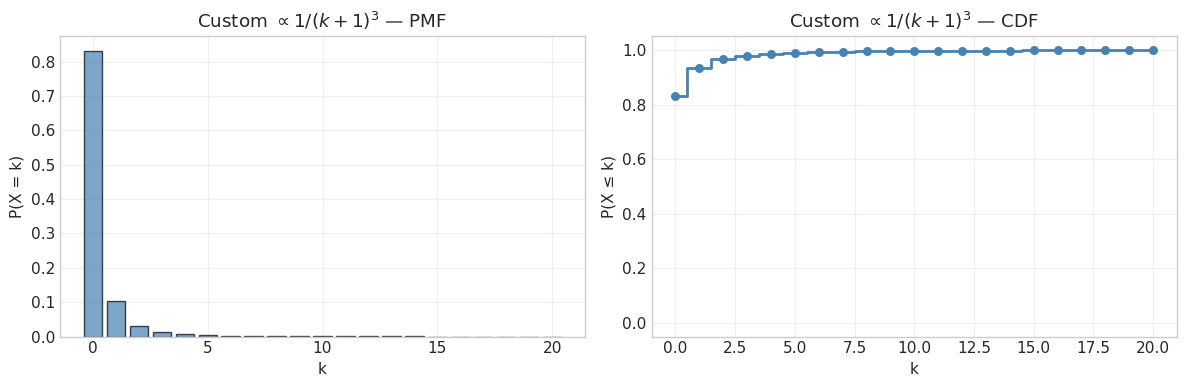

In [12]:
print("Custom 1/(k+1)² distribution:")
print(f"  P(X=0) = {custom.pmf(0):.4f}")
print(f"  P(X=5) = {custom.pmf(5):.4f}")
print(f"  P(X≤10) = {custom.cdf(10):.4f}")
print(f"  E[X] = {custom.mean():.4f}")
print(f"  Samples: {custom.rvs(size=5)}")
plot_distribution(custom, (0, 20), title=r'Custom $\propto 1/(k+1)^3$')

Poisson mixture (bimodal):
  P(Y=2) = 0.1353
  P(Y=8) = 0.0064
  E[Y] = 9.0000
  Samples: [15  1 16  3  3 25 17  4  1  1]


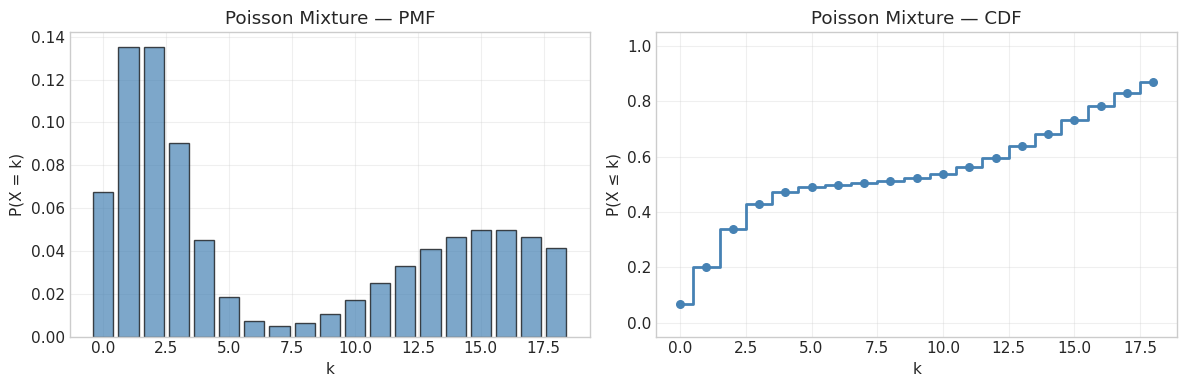

In [13]:
print("Poisson mixture (bimodal):")
print(f"  P(Y=2) = {mixture.pmf(2):.4f}")
print(f"  P(Y=8) = {mixture.pmf(8):.4f}")
print(f"  E[Y] = {mixture.mean():.4f}")
print(f"  Samples: {mixture.rvs(size=10)}")

plot_distribution(mixture, (0, 18), title='Poisson Mixture')

---
<h2 align="center">🔮 Interpretations of Probability</h2>
<hr>

Within classical probability theory, all major schools accept Kolmogorov's axioms but disagree about what probability **means**. These disagreements lead to fundamentally different approaches to statistical inference.

| Interpretation | Key Question | Probability Represents |
|----------------|--------------|------------------------|
| **Frequentist** | "What happens in the long run?" | Limiting relative frequency |
| **Bayesian** | "What should I believe?" | Degree of belief |
| **Likelihood** | "What does the data say?" | Relative support for hypotheses |

> **Note**: Alternative frameworks (quantum probability, Dempster-Shafer belief functions, imprecise probability) modify or reject these axioms. For classical statistical inference—the focus of this course—Kolmogorov's axioms provide the foundation.

### 📊 The Frequentist Interpretation

The frequentist view defines probability as the **limiting relative frequency** in repeated trials:

$$P(A) = \lim_{n \to \infty} \frac{\text{\# of times } A \text{ occurs}}{n}$$

**Key principles:**
- Probability is an objective property of the physical world
- Parameters are **fixed but unknown** constants
- Only data are random (through the sampling process)
- Inference focuses on **procedures** with good long-run properties

### Frequentist Confidence Intervals

A **95% confidence interval** is a procedure that, if repeated many times, would contain the true parameter in 95% of cases.

> **Interpretation:** "In 95% of repeated samples, the interval constructed by this procedure would contain the true parameter."

This is **not** the same as "95% probability the parameter is in this interval" (that's Bayesian).

---

### 🧠 The Bayesian Interpretation

The Bayesian view treats probability as a **degree of belief** that can apply to any uncertain proposition, including fixed parameters.

**Bayes' Theorem** provides the mechanism for updating beliefs:

$$P(\theta | \text{data}) = \frac{P(\text{data} | \theta) \cdot P(\theta)}{P(\text{data})}$$

| Component | Name | Role |
|-----------|------|------|
| $P(\theta)$ | Prior | What we believed before seeing data |
| $P(\text{data} \| \theta)$ | Likelihood | How probable is the data given $\theta$ |
| $P(\theta \| \text{data})$ | Posterior | Updated beliefs after seeing data |
| $P(\text{data})$ | Evidence | Normalizing constant |

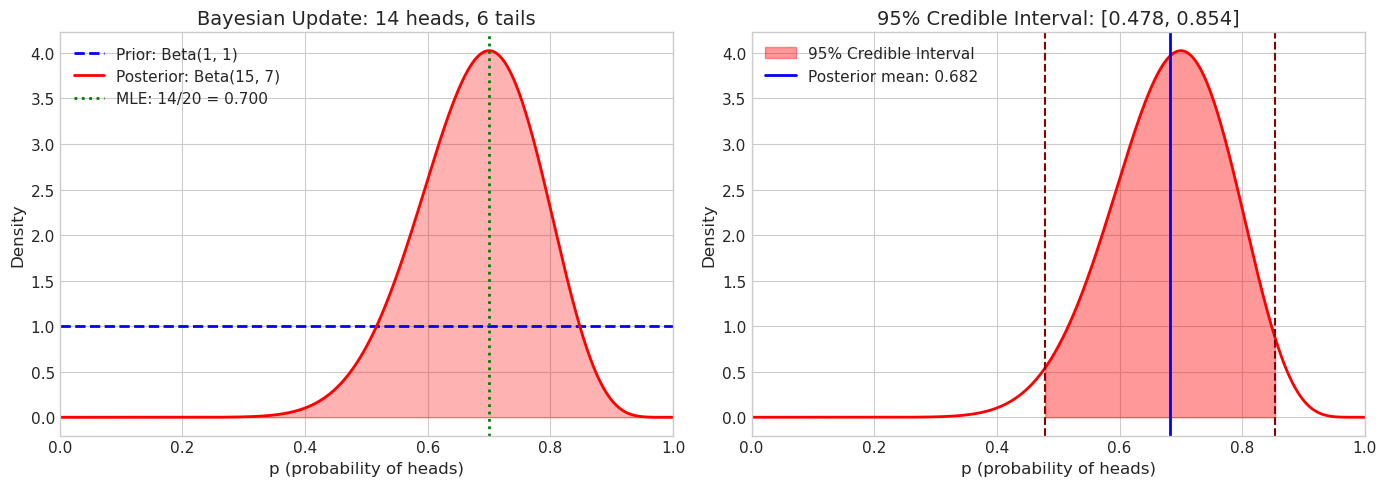


Bayesian Inference Summary
Data: 14 heads, 6 tails (n=20)

Prior: Beta(1, 1)
  Mean: 0.5000, Std: 0.2887

Posterior: Beta(15, 7)
  Mean: 0.6818, Std: 0.0971
  95% CI: [0.4782, 0.8541]

P(p > 0.5 | data) = 0.9608


In [15]:
def bayesian_coin_inference(n_heads: int, n_tails: int, 
                            prior_alpha: float = 1.0, prior_beta: float = 1.0):
    """
    Bayesian inference for coin bias using Beta-Binomial conjugacy.
    
    Prior: Beta(alpha, beta)
    Likelihood: Binomial(n_heads | n_heads + n_tails, p)
    Posterior: Beta(alpha + n_heads, beta + n_tails)
    """
    n_total = n_heads + n_tails
    
    # Posterior parameters (conjugate update)
    post_alpha = prior_alpha + n_heads
    post_beta = prior_beta + n_tails
    
    # Create distributions
    prior = stats.beta(prior_alpha, prior_beta)
    posterior = stats.beta(post_alpha, post_beta)
    
    # Grid for plotting
    p_grid = np.linspace(0, 1, 500)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Prior and Posterior
    ax1 = axes[0]
    ax1.plot(p_grid, prior.pdf(p_grid), 'b--', linewidth=2, 
             label=f'Prior: Beta({prior_alpha}, {prior_beta})')
    ax1.plot(p_grid, posterior.pdf(p_grid), 'r-', linewidth=2,
             label=f'Posterior: Beta({post_alpha}, {post_beta})')
    ax1.axvline(x=n_heads/n_total, color='green', linestyle=':', linewidth=2,
               label=f'MLE: {n_heads}/{n_total} = {n_heads/n_total:.3f}')
    ax1.fill_between(p_grid, posterior.pdf(p_grid), alpha=0.3, color='red')
    ax1.set_xlabel('p (probability of heads)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title(f'Bayesian Update: {n_heads} heads, {n_tails} tails', fontsize=14)
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 1)
    
    # Right: Credible interval
    ax2 = axes[1]
    ci_lower, ci_upper = posterior.ppf([0.025, 0.975])
    
    ax2.plot(p_grid, posterior.pdf(p_grid), 'r-', linewidth=2)
    mask = (p_grid >= ci_lower) & (p_grid <= ci_upper)
    ax2.fill_between(p_grid[mask], posterior.pdf(p_grid[mask]), 
                     alpha=0.4, color='red', label='95% Credible Interval')
    ax2.axvline(x=ci_lower, color='darkred', linestyle='--', linewidth=1.5)
    ax2.axvline(x=ci_upper, color='darkred', linestyle='--', linewidth=1.5)
    ax2.axvline(x=posterior.mean(), color='blue', linestyle='-', linewidth=2,
               label=f'Posterior mean: {posterior.mean():.3f}')
    ax2.set_xlabel('p (probability of heads)', fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.set_title(f'95% Credible Interval: [{ci_lower:.3f}, {ci_upper:.3f}]', fontsize=14)
    ax2.legend(loc='upper left')
    ax2.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nBayesian Inference Summary")
    print("=" * 50)
    print(f"Data: {n_heads} heads, {n_tails} tails (n={n_total})")
    print(f"\nPrior: Beta({prior_alpha}, {prior_beta})")
    print(f"  Mean: {prior.mean():.4f}, Std: {prior.std():.4f}")
    print(f"\nPosterior: Beta({post_alpha}, {post_beta})")
    print(f"  Mean: {posterior.mean():.4f}, Std: {posterior.std():.4f}")
    print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"\nP(p > 0.5 | data) = {1 - posterior.cdf(0.5):.4f}")
    
    return posterior

# Example: 14 heads out of 20 flips with uniform prior
posterior = bayesian_coin_inference(n_heads=14, n_tails=6, 
                                    prior_alpha=1, prior_beta=1)

### Sequential Bayesian Updating

One powerful feature of Bayesian inference: we can **update sequentially** as data arrives. The posterior from one update becomes the prior for the next.

---
---

<h2 align="center">⚖️ Frequentist vs. Bayesian: A Side-by-Side Comparison</h2>

<hr>

| Aspect | Frequentist | Bayesian |
|--------|-------------|----------|
| **Parameters** | Fixed but unknown constants | Random variables with distributions |
| **Probability** | Long-run frequency only | Degree of belief (any uncertainty) |
| **Goal** | Procedures with good error rates | Update beliefs with data |
| **Prior information** | Not formally incorporated | Explicitly via prior distribution |
| **Interval interpretation** | "95% of such intervals contain θ" | "95% probability θ ∈ [a,b] given data" |
| **Hypothesis testing** | P-values: P(data or more extreme \| H₀) | Posterior probabilities: P(H₀ \| data) |

In [16]:
def compare_paradigms(n_heads: int = 14, n_total: int = 20):
    """
    Compare frequentist and Bayesian analysis of the same data.
    """
    n_tails = n_total - n_heads
    p_hat = n_heads / n_total  # MLE
    
    print("PARADIGM COMPARISON")
    print("=" * 60)
    print(f"Data: {n_heads} heads in {n_total} flips")
    print()
    
    # ─────────────────────────────────────────
    # FREQUENTIST ANALYSIS
    # ─────────────────────────────────────────
    print("FREQUENTIST ANALYSIS")
    print("-" * 40)
    
    # Wald (Normal approximation) CI
    se = np.sqrt(p_hat * (1 - p_hat) / n_total)
    z = stats.norm.ppf(0.975)
    wald_ci = (p_hat - z*se, p_hat + z*se)
    print(f"Point estimate (MLE): p̂ = {p_hat:.4f}")
    print(f"95% Wald CI: [{wald_ci[0]:.4f}, {wald_ci[1]:.4f}]")
    
    # Exact (Clopper-Pearson) CI using Beta distribution
    # Lower bound: Beta(x, n-x+1) quantile at α/2
    # Upper bound: Beta(x+1, n-x) quantile at 1-α/2
    cp_lower = stats.beta.ppf(0.025, n_heads, n_tails + 1)
    cp_upper = stats.beta.ppf(0.975, n_heads + 1, n_tails)
    print(f"95% Clopper-Pearson CI: [{cp_lower:.4f}, {cp_upper:.4f}]")
    
    # Hypothesis test: H₀: p = 0.5
    # Two-sided binomial test
    test_result = stats.binomtest(n_heads, n_total, 0.5, alternative='two-sided')
    pvalue = test_result.pvalue  # Extract p-value from BinomTestResult object
    print(f"\nTest H₀: p = 0.5")
    print(f"P-value = {pvalue:.4f}")
    print(f"Interpretation: If p=0.5, probability of {n_heads}+ or {n_tails}- heads")
    print(f"                in {n_total} flips is {pvalue:.1%}")
    
    # ─────────────────────────────────────────
    # BAYESIAN ANALYSIS
    # ─────────────────────────────────────────
    print()
    print("BAYESIAN ANALYSIS (with uniform prior)")
    print("-" * 40)
    
    # Uniform prior → Beta(1,1)
    posterior = stats.beta(1 + n_heads, 1 + n_tails)
    
    print(f"Posterior: Beta({1+n_heads}, {1+n_tails})")
    print(f"Posterior mean: {posterior.mean():.4f}")
    print(f"Posterior median: {posterior.median():.4f}")
    print(f"Posterior mode (MAP): {(n_heads)/(n_total):.4f}")
    
    cred_ci = posterior.ppf([0.025, 0.975])
    print(f"95% Credible Interval: [{cred_ci[0]:.4f}, {cred_ci[1]:.4f}]")
    
    prob_greater_half = 1 - posterior.cdf(0.5)
    print(f"\nP(p > 0.5 | data) = {prob_greater_half:.4f}")
    print(f"Interpretation: Given the data, there's a {prob_greater_half:.1%} probability")
    print(f"                that the coin is biased toward heads.")
    
    # ─────────────────────────────────────────
    # KEY DIFFERENCES
    # ─────────────────────────────────────────
    print()
    print("KEY INTERPRETIVE DIFFERENCES")
    print("-" * 40)
    print("\nQuestion: 'What's the probability that p > 0.5?'")
    print()
    print("Frequentist: 'That question is meaningless. p is a fixed constant,'")
    print("             'not a random variable. It either is or isn't > 0.5.'")
    print(f"             'I can only say: if p=0.5, data this extreme has P={pvalue:.3f}'")
    print()
    print(f"Bayesian:    'Given the data and uniform prior, P(p > 0.5) = {prob_greater_half:.3f}'")
    print("             'This is my degree of belief that the coin favors heads.'")

compare_paradigms(n_heads=14, n_total=20)

PARADIGM COMPARISON
Data: 14 heads in 20 flips

FREQUENTIST ANALYSIS
----------------------------------------
Point estimate (MLE): p̂ = 0.7000
95% Wald CI: [0.4992, 0.9008]
95% Clopper-Pearson CI: [0.4572, 0.8811]

Test H₀: p = 0.5
P-value = 0.1153
Interpretation: If p=0.5, probability of 14+ or 6- heads
                in 20 flips is 11.5%

BAYESIAN ANALYSIS (with uniform prior)
----------------------------------------
Posterior: Beta(15, 7)
Posterior mean: 0.6818
Posterior median: 0.6874
Posterior mode (MAP): 0.7000
95% Credible Interval: [0.4782, 0.8541]

P(p > 0.5 | data) = 0.9608
Interpretation: Given the data, there's a 96.1% probability
                that the coin is biased toward heads.

KEY INTERPRETIVE DIFFERENCES
----------------------------------------

Question: 'What's the probability that p > 0.5?'

Frequentist: 'That question is meaningless. p is a fixed constant,'
             'not a random variable. It either is or isn't > 0.5.'
             'I can only say: if p=0

---

### 🔬 Prior Sensitivity Analysis

A common critique of Bayesian methods: results depend on the prior. Let's examine this sensitivity.

Prior Sensitivity Analysis
Data: 14 heads, 6 tails
MLE: 0.7000

Uniform: Beta(1,1)
  Posterior mean: 0.6818, 95% CI: [0.4782, 0.8541]
Jeffreys: Beta(0.5, 0.5)
  Posterior mean: 0.6905, 95% CI: [0.4828, 0.8639]
Weak toward 0.5: Beta(2,2)
  Posterior mean: 0.6667, 95% CI: [0.4708, 0.8362]
Moderate toward 0.5: Beta(5,5)
  Posterior mean: 0.6333, 95% CI: [0.4567, 0.7931]
Prior favors heads: Beta(10,2)
  Posterior mean: 0.7500, 95% CI: [0.5890, 0.8814]
Prior favors tails: Beta(2,10)
  Posterior mean: 0.5000, 95% CI: [0.3306, 0.6694]


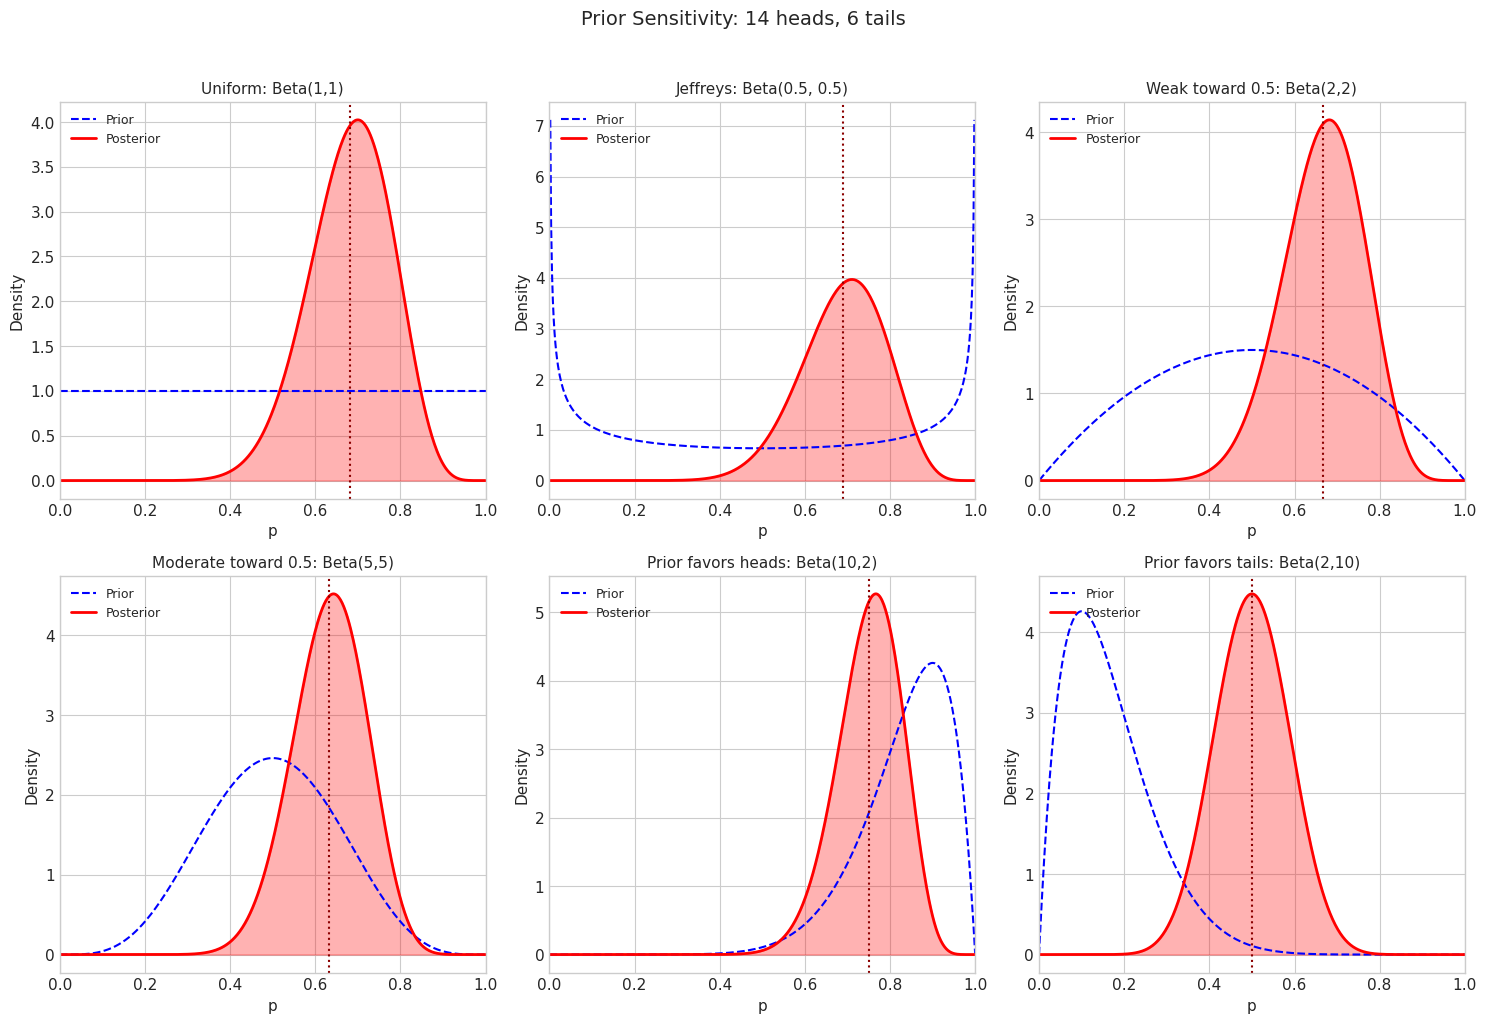

In [18]:
def prior_sensitivity(n_heads: int = 14, n_tails: int = 6):
    """
    Show how different priors lead to different posteriors.
    """
    p_grid = np.linspace(0, 1, 500)
    
    # Different priors
    priors = [
        (1, 1, 'Uniform: Beta(1,1)'),
        (0.5, 0.5, 'Jeffreys: Beta(0.5, 0.5)'),
        (2, 2, 'Weak toward 0.5: Beta(2,2)'),
        (5, 5, 'Moderate toward 0.5: Beta(5,5)'),
        (10, 2, 'Prior favors heads: Beta(10,2)'),
        (2, 10, 'Prior favors tails: Beta(2,10)'),
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    print("Prior Sensitivity Analysis")
    print("=" * 60)
    print(f"Data: {n_heads} heads, {n_tails} tails")
    print(f"MLE: {n_heads/(n_heads+n_tails):.4f}")
    print()
    
    for i, (a, b, name) in enumerate(priors):
        ax = axes[i]
        
        prior = stats.beta(a, b)
        posterior = stats.beta(a + n_heads, b + n_tails)
        
        ax.plot(p_grid, prior.pdf(p_grid), 'b--', linewidth=1.5, label='Prior')
        ax.plot(p_grid, posterior.pdf(p_grid), 'r-', linewidth=2, label='Posterior')
        ax.fill_between(p_grid, posterior.pdf(p_grid), alpha=0.3, color='red')
        
        ci = posterior.ppf([0.025, 0.975])
        ax.axvline(x=posterior.mean(), color='darkred', linestyle=':', linewidth=1.5)
        
        ax.set_title(name, fontsize=11)
        ax.set_xlabel('p')
        ax.set_ylabel('Density')
        ax.legend(loc='upper left', fontsize=9)
        ax.set_xlim(0, 1)
        
        print(f"{name}")
        print(f"  Posterior mean: {posterior.mean():.4f}, 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
    
    plt.suptitle(f'Prior Sensitivity: {n_heads} heads, {n_tails} tails', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

prior_sensitivity(n_heads=14, n_tails=6)


WITH MORE DATA (140 heads, 60 tails):
Prior Sensitivity Analysis
Data: 140 heads, 60 tails
MLE: 0.7000

Uniform: Beta(1,1)
  Posterior mean: 0.6980, 95% CI: [0.6331, 0.7592]
Jeffreys: Beta(0.5, 0.5)
  Posterior mean: 0.6990, 95% CI: [0.6340, 0.7603]
Weak toward 0.5: Beta(2,2)
  Posterior mean: 0.6961, 95% CI: [0.6314, 0.7571]
Moderate toward 0.5: Beta(5,5)
  Posterior mean: 0.6905, 95% CI: [0.6265, 0.7511]
Prior favors heads: Beta(10,2)
  Posterior mean: 0.7075, 95% CI: [0.6447, 0.7667]
Prior favors tails: Beta(2,10)
  Posterior mean: 0.6698, 95% CI: [0.6052, 0.7314]


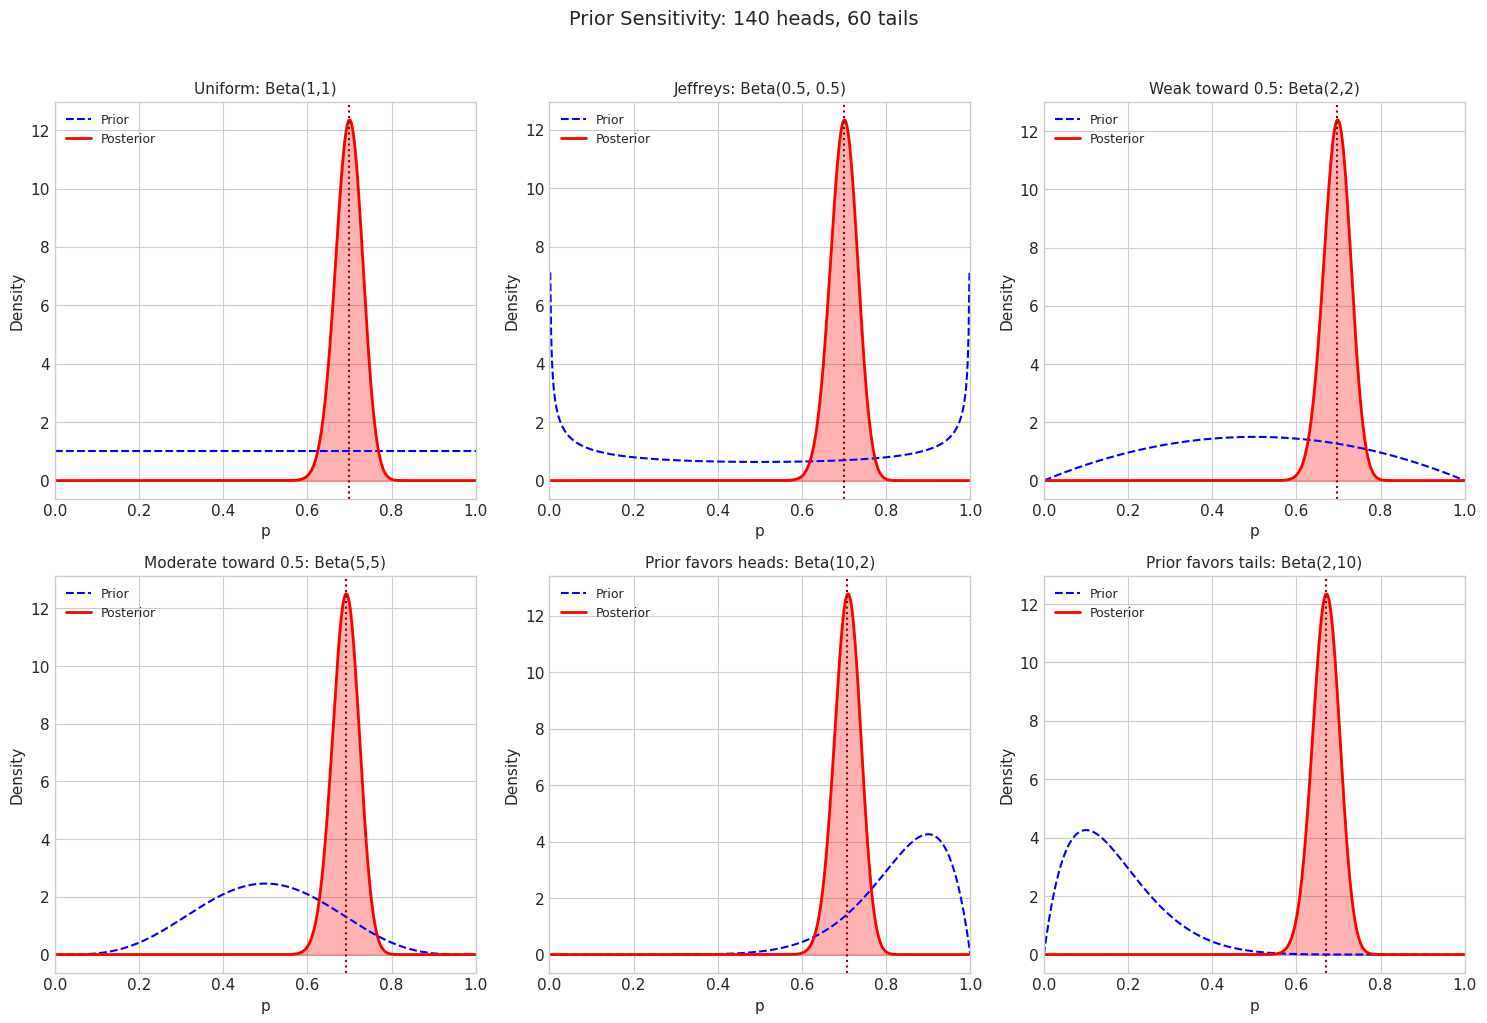

In [19]:
# With more data, the prior matters less
print("\n" + "="*60)
print("WITH MORE DATA (140 heads, 60 tails):")
print("="*60)
prior_sensitivity(n_heads=140, n_tails=60)

---
---

<h2 align="center">✏️ Exercises</h2>

<hr>

### Exercise 1: Axiom Verification

Create a probability space for a loaded die where face 6 appears with probability 0.25 and all other faces are equally likely. Verify it satisfies Kolmogorov's axioms.

### Exercise 2: Frequentist Coverage

Modify `frequentist_ci_demonstration` to use sample standard deviation (unknown σ) and t-distribution critical values. How does coverage change?

### Exercise 3: Bayesian Hypothesis Testing

Given 8 heads in 10 flips and a Beta(1,1) prior:
1. Calculate P(p > 0.5 | data)
2. Calculate the Bayes factor for H₁: p > 0.5 vs H₀: p ≤ 0.5
3. Compare with the frequentist p-value

### Exercise 4: Prior Elicitation

You believe a coin is fair but want to express uncertainty. Design a Beta prior such that:
- Prior mean = 0.5
- Prior 95% interval is approximately [0.3, 0.7]

What values of α and β achieve this?

In [20]:
# Exercise 1 Solution Scaffold
# loaded_die = DiscreteProbabilitySpace(
#     outcomes=[1, 2, 3, 4, 5, 6],
#     probabilities=[?, ?, ?, ?, ?, 0.25]  # Fill in the ?s
# )

# Exercise 4 Solution Scaffold
# For Beta(α, β): mean = α/(α+β), so α = β for mean = 0.5
# Find α such that the 95% interval is approximately [0.3, 0.7]

def find_prior_params(target_lower=0.3, target_upper=0.7):
    """Find Beta(α, α) parameters to achieve target credible interval."""
    for alpha in np.arange(1, 50, 0.5):
        dist = stats.beta(alpha, alpha)
        lower, upper = dist.ppf([0.025, 0.975])
        if abs(lower - target_lower) < 0.02 and abs(upper - target_upper) < 0.02:
            print(f"Beta({alpha}, {alpha}): 95% CI = [{lower:.3f}, {upper:.3f}]")
            return alpha
    return None

# Uncomment to run:
# find_prior_params()


---
---

# Section 1.2: Probability Distributions Review

---


---
---

<h2 align="center">🐍 The Python Ecosystem for Probability</h2>

<hr>

SciPy provides a unified interface for all distributions through `scipy.stats`:

| Method | Purpose | Example |
|--------|---------|--------|
| `.pdf(x)` / `.pmf(x)` | Density/mass at x | P(X = x) for discrete |
| `.cdf(x)` | Cumulative probability | P(X ≤ x) |
| `.ppf(q)` | Quantile function | Find x such that P(X ≤ x) = q |
| `.sf(x)` | Survival function | P(X > x) = 1 - CDF(x) |
| `.rvs(size)` | Random samples | Generate n random values |
| `.mean()`, `.var()` | Moments | Theoretical mean and variance |

In [21]:
# Example: Normal distribution N(μ=0, σ=1)
dist = stats.norm(loc=0, scale=1)

print("Standard Normal Distribution N(0, 1)")
print("=" * 45)

x = 1.96
print(f"PDF at x={x}:        φ({x}) = {dist.pdf(x):.6f}")
print(f"CDF at x={x}:        Φ({x}) = {dist.cdf(x):.6f}")
print(f"Survival at x={x}:   P(X > {x}) = {dist.sf(x):.6f}")
print(f"")
print(f"95th percentile:     Φ⁻¹(0.95) = {dist.ppf(0.95):.6f}")
print(f"")
print(f"Theoretical mean:    {dist.mean():.6f}")
print(f"Theoretical variance: {dist.var():.6f}")

# Sample and verify
samples = dist.rvs(size=10000, random_state=42)
print(f"")
print(f"Sample mean (n=10000):     {samples.mean():.6f}")
print(f"Sample variance (n=10000): {samples.var():.6f}")

Standard Normal Distribution N(0, 1)
PDF at x=1.96:        φ(1.96) = 0.058441
CDF at x=1.96:        Φ(1.96) = 0.975002
Survival at x=1.96:   P(X > 1.96) = 0.024998

95th percentile:     Φ⁻¹(0.95) = 1.644854

Theoretical mean:    0.000000
Theoretical variance: 1.000000

Sample mean (n=10000):     -0.002136
Sample variance (n=10000): 1.006836


---
---

<h2 align="center">🎲 Discrete Distributions</h2>

<hr>

Discrete distributions model **counts** and **categorical outcomes**. They assign probability to individual values rather than intervals.

### Bernoulli Distribution

The simplest random variable: a single trial with two outcomes.

$$X \sim \text{Bernoulli}(p) \quad \Rightarrow \quad P(X = 1) = p, \quad P(X = 0) = 1-p$$

| Property | Value |
|----------|-------|
| Support | $\{0, 1\}$ |
| Mean | $p$ |
| Variance | $p(1-p)$ |

In [22]:
# Bernoulli distribution
p = 0.7
bern = stats.bernoulli(p)

print(f"Bernoulli(p={p})")
print(f"P(X=0) = {bern.pmf(0):.4f}")
print(f"P(X=1) = {bern.pmf(1):.4f}")
print(f"Mean = {bern.mean():.4f}, Variance = {bern.var():.4f}")

# Simulate many trials
samples = bern.rvs(size=10000, random_state=42)
print(f"\nSimulation (n=10000): {samples.sum()} successes ({samples.mean()*100:.1f}%)")

Bernoulli(p=0.7)
P(X=0) = 0.3000
P(X=1) = 0.7000
Mean = 0.7000, Variance = 0.2100

Simulation (n=10000): 7113 successes (71.1%)


### Binomial Distribution

The sum of $n$ independent Bernoulli trials.

$$X \sim \text{Binomial}(n, p) \quad \Rightarrow \quad P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}$$

| Property | Value |
|----------|-------|
| Support | $\{0, 1, 2, \ldots, n\}$ |
| Mean | $np$ |
| Variance | $np(1-p)$ |

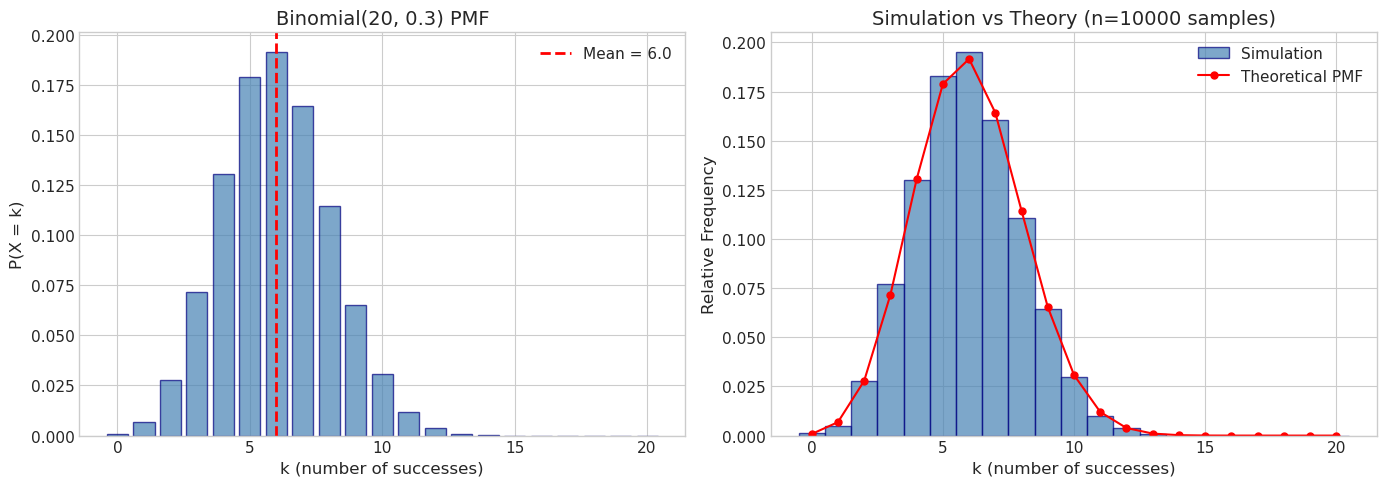

Binomial(n=20, p=0.3)
  Mean: 6.0000 (sample: 5.9563)
  Variance: 4.2000 (sample: 4.1164)


In [23]:
def visualize_binomial(n: int, p: float):
    """Visualize binomial distribution with PMF and simulation."""
    binom = stats.binom(n, p)
    
    k = np.arange(0, n + 1)
    pmf = binom.pmf(k)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: PMF
    ax1 = axes[0]
    ax1.bar(k, pmf, color='steelblue', alpha=0.7, edgecolor='navy')
    ax1.axvline(x=n*p, color='red', linestyle='--', linewidth=2, label=f'Mean = {n*p}')
    ax1.set_xlabel('k (number of successes)', fontsize=12)
    ax1.set_ylabel('P(X = k)', fontsize=12)
    ax1.set_title(f'Binomial({n}, {p}) PMF', fontsize=14)
    ax1.legend()
    
    # Right: Simulation histogram
    ax2 = axes[1]
    samples = binom.rvs(size=10000, random_state=42)
    ax2.hist(samples, bins=np.arange(-0.5, n + 1.5), density=True, 
             color='steelblue', alpha=0.7, edgecolor='navy', label='Simulation')
    ax2.plot(k, pmf, 'ro-', markersize=5, linewidth=1.5, label='Theoretical PMF')
    ax2.set_xlabel('k (number of successes)', fontsize=12)
    ax2.set_ylabel('Relative Frequency', fontsize=12)
    ax2.set_title(f'Simulation vs Theory (n=10000 samples)', fontsize=14)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Binomial(n={n}, p={p})")
    print(f"  Mean: {binom.mean():.4f} (sample: {samples.mean():.4f})")
    print(f"  Variance: {binom.var():.4f} (sample: {samples.var():.4f})")

visualize_binomial(n=20, p=0.3)

### Poisson Distribution

Models the count of events in a fixed interval when events occur independently at a constant average rate.

$$X \sim \text{Poisson}(\lambda) \quad \Rightarrow \quad P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

| Property | Value |
|----------|-------|
| Support | $\{0, 1, 2, \ldots\}$ |
| Mean | $\lambda$ |
| Variance | $\lambda$ |

**Key property**: Mean equals variance!

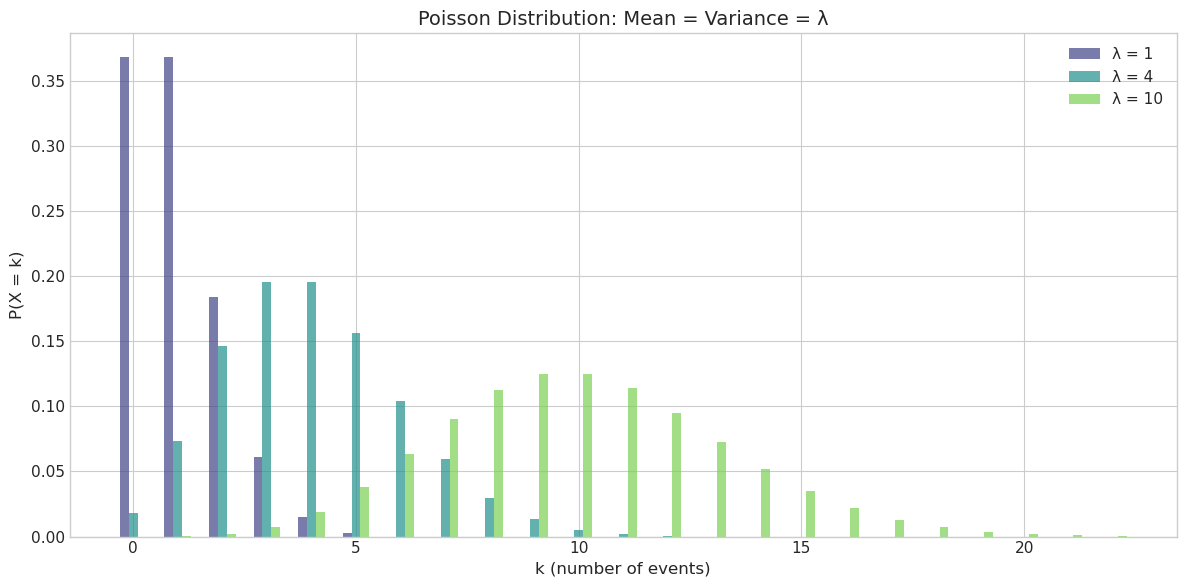

Poisson Distribution Properties:
----------------------------------------
λ =  1: Mean = 0.995, Var = 0.988
λ =  4: Mean = 3.984, Var = 3.939
λ = 10: Mean = 10.019, Var = 9.890


In [25]:
def visualize_poisson(lambdas: list = [1, 4, 10]):
    """Compare Poisson distributions with different rate parameters."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(lambdas)))
    
    for lam, color in zip(lambdas, colors):
        pois = stats.poisson(lam)
        k_max = int(lam + 4*np.sqrt(lam)) + 1
        k = np.arange(0, k_max)
        pmf = pois.pmf(k)
        
        ax.bar(k + 0.2*(lambdas.index(lam) - 1), pmf, width=0.2, 
               color=color, alpha=0.7, label=f'λ = {lam}')
    
    ax.set_xlabel('k (number of events)', fontsize=12)
    ax.set_ylabel('P(X = k)', fontsize=12)
    ax.set_title('Poisson Distribution: Mean = Variance = λ', fontsize=14)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Poisson Distribution Properties:")
    print("-" * 40)
    for lam in lambdas:
        pois = stats.poisson(lam)
        samples = pois.rvs(size=10000, random_state=42)
        print(f"λ = {lam:2d}: Mean = {samples.mean():.3f}, Var = {samples.var():.3f}")

visualize_poisson([1, 4, 10])

### Poisson as Limit of Binomial

When $n \to \infty$ and $p \to 0$ such that $np = \lambda$ remains constant:

$$\text{Binomial}(n, \lambda/n) \xrightarrow{n \to \infty} \text{Poisson}(\lambda)$$

This is the **Law of Rare Events**: many trials with small probability of success.

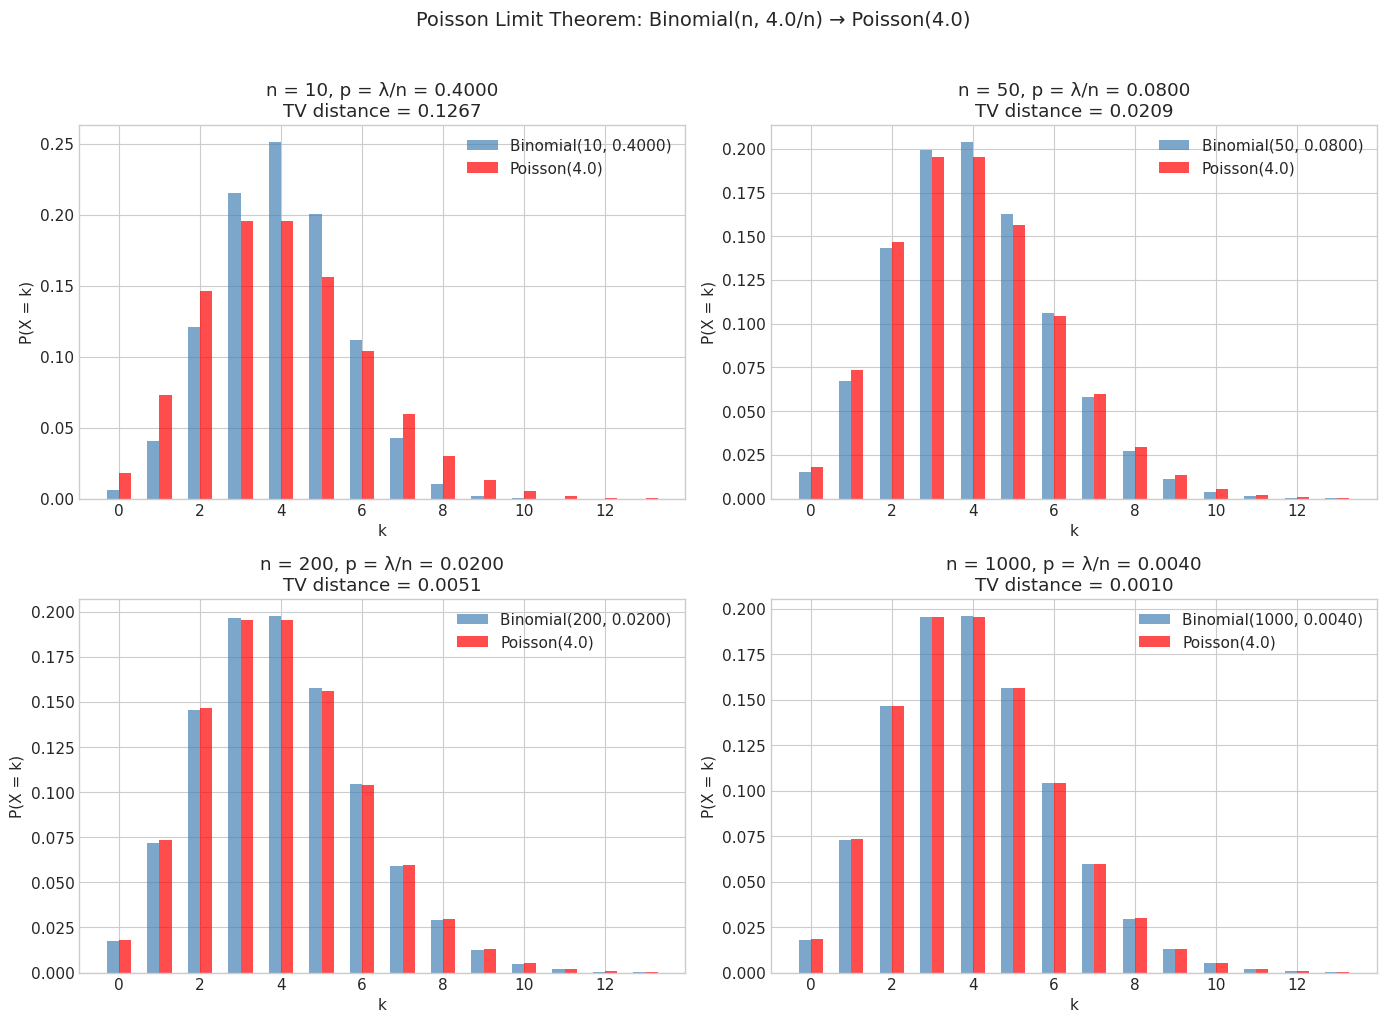

In [26]:
def poisson_limit_theorem(lam: float = 4.0, n_values: list = [10, 50, 200, 1000]):
    """Demonstrate Binomial converging to Poisson."""
    
    k_max = int(lam + 4*np.sqrt(lam)) + 2
    k = np.arange(0, k_max)
    
    # True Poisson PMF
    pois = stats.poisson(lam)
    poisson_pmf = pois.pmf(k)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, n in enumerate(n_values):
        ax = axes[idx]
        p = lam / n
        binom = stats.binom(n, p)
        binom_pmf = binom.pmf(k)
        
        ax.bar(k - 0.15, binom_pmf, width=0.3, color='steelblue', 
               alpha=0.7, label=f'Binomial({n}, {p:.4f})')
        ax.bar(k + 0.15, poisson_pmf, width=0.3, color='red', 
               alpha=0.7, label=f'Poisson({lam})')
        
        # Compute total variation distance
        tv_dist = 0.5 * np.sum(np.abs(binom_pmf - poisson_pmf))
        
        ax.set_xlabel('k')
        ax.set_ylabel('P(X = k)')
        ax.set_title(f'n = {n}, p = λ/n = {p:.4f}\nTV distance = {tv_dist:.4f}')
        ax.legend(loc='upper right')
    
    plt.suptitle(f'Poisson Limit Theorem: Binomial(n, {lam}/n) → Poisson({lam})', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

poisson_limit_theorem(lam=4.0)

---
---

<h2 align="center">📈 Continuous Distributions</h2>

<hr>

Continuous distributions model **measurements** on a continuous scale. Probability is assigned to intervals, not individual points.

### Uniform Distribution

Equal probability across an interval—the foundation of random number generation.

$$X \sim \text{Uniform}(a, b) \quad \Rightarrow \quad f(x) = \frac{1}{b-a} \text{ for } x \in [a, b]$$

| Property | Value |
|----------|-------|
| Support | $[a, b]$ |
| Mean | $(a + b)/2$ |
| Variance | $(b - a)^2/12$ |

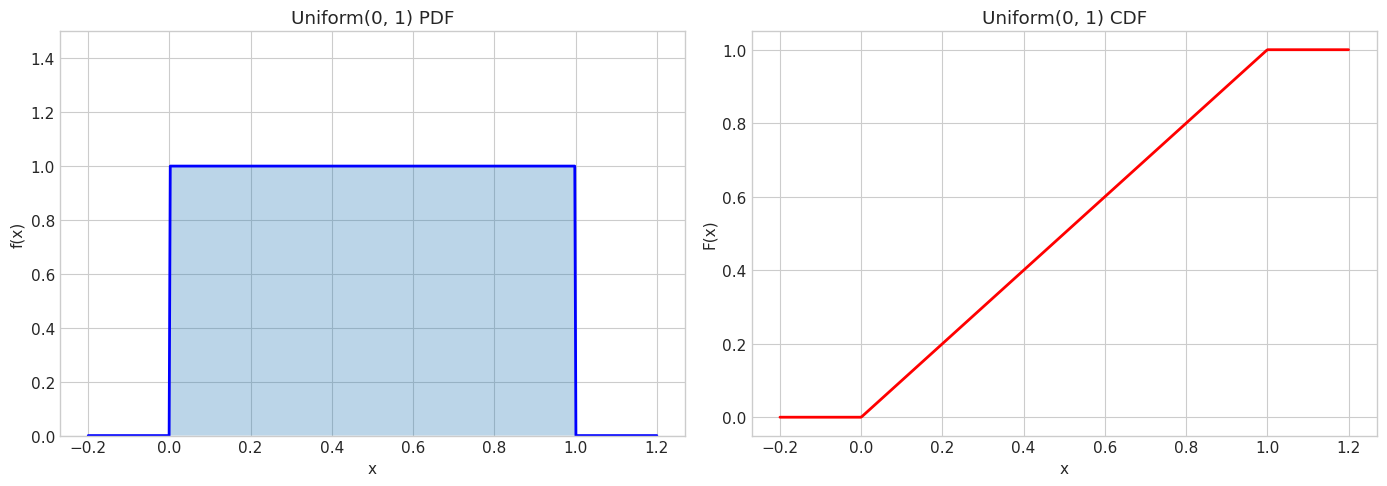

Uniform(0, 1):
  Theoretical mean: 0.5000, sample mean: 0.4942
  Theoretical var:  0.0833, sample var:  0.0827


In [27]:
# Uniform distribution
a, b = 0, 1
unif = stats.uniform(loc=a, scale=b-a)  # Note: SciPy uses loc, scale

x = np.linspace(-0.2, 1.2, 500)
samples = unif.rvs(size=10000, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PDF
ax1 = axes[0]
ax1.plot(x, unif.pdf(x), 'b-', linewidth=2, label='PDF')
ax1.fill_between(x, unif.pdf(x), alpha=0.3)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.set_title('Uniform(0, 1) PDF')
ax1.set_ylim(0, 1.5)

# CDF
ax2 = axes[1]
ax2.plot(x, unif.cdf(x), 'r-', linewidth=2, label='CDF')
ax2.set_xlabel('x')
ax2.set_ylabel('F(x)')
ax2.set_title('Uniform(0, 1) CDF')

plt.tight_layout()
plt.show()

print(f"Uniform({a}, {b}):")
print(f"  Theoretical mean: {(a+b)/2:.4f}, sample mean: {samples.mean():.4f}")
print(f"  Theoretical var:  {(b-a)**2/12:.4f}, sample var:  {samples.var():.4f}")

### Normal (Gaussian) Distribution

The most important distribution in statistics, arising from the Central Limit Theorem.

$$X \sim \mathcal{N}(\mu, \sigma^2) \quad \Rightarrow \quad f(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$

| Property | Value |
|----------|-------|
| Support | $(-\infty, \infty)$ |
| Mean | $\mu$ |
| Variance | $\sigma^2$ |
| Skewness | 0 |
| Kurtosis | 3 |

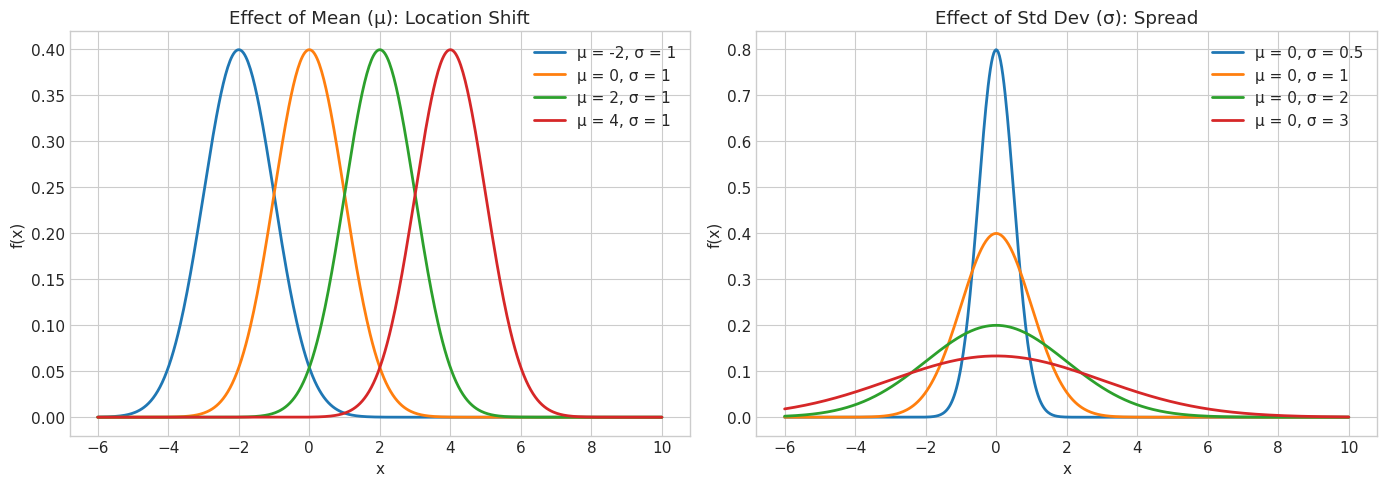

In [28]:
def visualize_normal_family():
    """Visualize normal distributions with different parameters."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    x = np.linspace(-6, 10, 500)
    
    # Left: Different means
    ax1 = axes[0]
    for mu in [-2, 0, 2, 4]:
        norm = stats.norm(loc=mu, scale=1)
        ax1.plot(x, norm.pdf(x), linewidth=2, label=f'μ = {mu}, σ = 1')
    ax1.set_xlabel('x')
    ax1.set_ylabel('f(x)')
    ax1.set_title('Effect of Mean (μ): Location Shift')
    ax1.legend()
    
    # Right: Different standard deviations
    ax2 = axes[1]
    for sigma in [0.5, 1, 2, 3]:
        norm = stats.norm(loc=0, scale=sigma)
        ax2.plot(x, norm.pdf(x), linewidth=2, label=f'μ = 0, σ = {sigma}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.set_title('Effect of Std Dev (σ): Spread')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

visualize_normal_family()

In [29]:
# The 68-95-99.7 Rule (Empirical Rule)
print("The Empirical Rule for Normal Distributions")
print("=" * 50)

standard_normal = stats.norm(0, 1)

for k, expected in [(1, 68.27), (2, 95.45), (3, 99.73)]:
    prob = standard_normal.cdf(k) - standard_normal.cdf(-k)
    print(f"P(-{k}σ < X < {k}σ) = {prob*100:.2f}% (expected: {expected}%)")

The Empirical Rule for Normal Distributions
P(-1σ < X < 1σ) = 68.27% (expected: 68.27%)
P(-2σ < X < 2σ) = 95.45% (expected: 95.45%)
P(-3σ < X < 3σ) = 99.73% (expected: 99.73%)


### Exponential Distribution

Models waiting times between events in a Poisson process. **Uniquely memoryless** among continuous distributions.

$$X \sim \text{Exponential}(\lambda) \quad \Rightarrow \quad f(x) = \lambda e^{-\lambda x} \text{ for } x \geq 0$$

| Property | Value |
|----------|-------|
| Support | $[0, \infty)$ |
| Mean | $1/\lambda$ |
| Variance | $1/\lambda^2$ |

**⚠️ Parameterization Warning**: SciPy uses *scale* = 1/λ, not *rate* = λ!

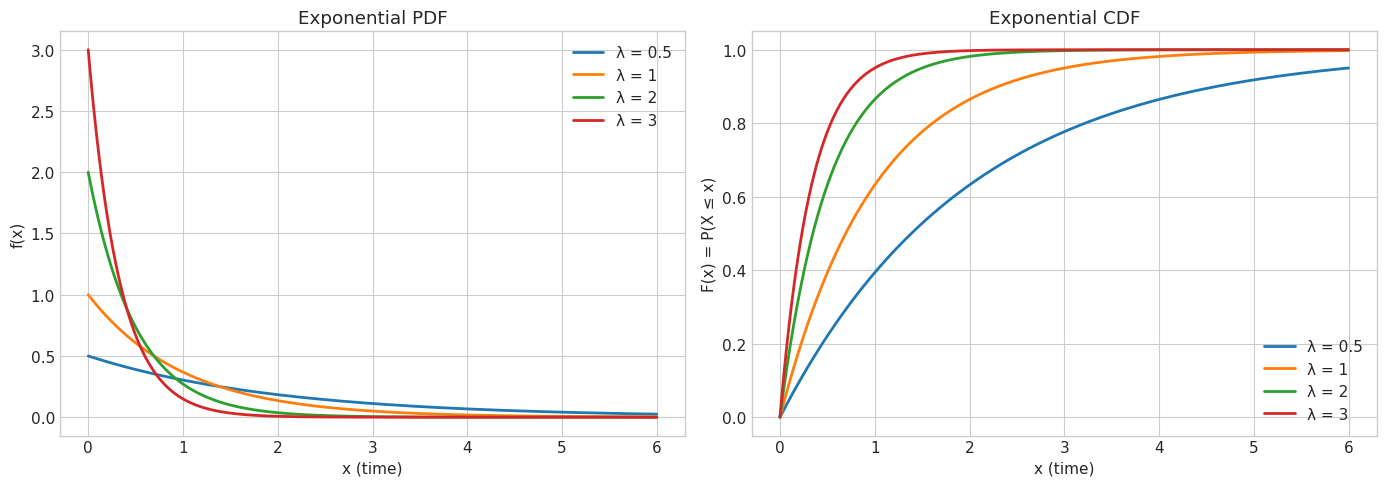

In [30]:
def visualize_exponential(lambdas: list = [0.5, 1, 2, 3]):
    """Visualize exponential distributions with different rates."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    x = np.linspace(0, 6, 500)
    
    for lam in lambdas:
        # SciPy uses scale = 1/rate
        exp = stats.expon(scale=1/lam)
        axes[0].plot(x, exp.pdf(x), linewidth=2, label=f'λ = {lam}')
        axes[1].plot(x, exp.cdf(x), linewidth=2, label=f'λ = {lam}')
    
    axes[0].set_xlabel('x (time)')
    axes[0].set_ylabel('f(x)')
    axes[0].set_title('Exponential PDF')
    axes[0].legend()
    
    axes[1].set_xlabel('x (time)')
    axes[1].set_ylabel('F(x) = P(X ≤ x)')
    axes[1].set_title('Exponential CDF')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

visualize_exponential()

In [31]:
def demonstrate_memoryless(lam: float = 2.0, s: float = 1.0, t: float = 0.5):
    """
    Demonstrate the memoryless property:
    P(X > s + t | X > s) = P(X > t)
    
    "If you've waited s time units, the expected additional wait is the same 
    as if you just started."
    """
    exp = stats.expon(scale=1/lam)
    
    # Theoretical calculation
    P_X_greater_t = exp.sf(t)  # P(X > t)
    P_X_greater_s_plus_t_given_s = exp.sf(s + t) / exp.sf(s)  # Conditional
    
    print("Memoryless Property of Exponential Distribution")
    print("=" * 55)
    print(f"λ = {lam}, s = {s}, t = {t}")
    print()
    print(f"P(X > t) = P(X > {t}) = {P_X_greater_t:.6f}")
    print(f"P(X > s+t | X > s) = P(X > {s+t} | X > {s}) = {P_X_greater_s_plus_t_given_s:.6f}")
    print()
    print("These are equal! The exponential 'forgets' how long it's waited.")
    
    # Simulation verification
    print("\n" + "-"*55)
    print("Simulation Verification (n = 100,000):")
    
    samples = exp.rvs(size=100000, random_state=42)
    
    # Empirical P(X > t)
    empirical_P_t = np.mean(samples > t)
    
    # Empirical P(X > s+t | X > s)
    survived_s = samples[samples > s]
    empirical_conditional = np.mean(survived_s > s + t)
    
    print(f"Empirical P(X > {t}) = {empirical_P_t:.6f}")
    print(f"Empirical P(X > {s+t} | X > {s}) = {empirical_conditional:.6f}")

demonstrate_memoryless()

Memoryless Property of Exponential Distribution
λ = 2.0, s = 1.0, t = 0.5

P(X > t) = P(X > 0.5) = 0.367879
P(X > s+t | X > s) = P(X > 1.5 | X > 1.0) = 0.367879

These are equal! The exponential 'forgets' how long it's waited.

-------------------------------------------------------
Simulation Verification (n = 100,000):
Empirical P(X > 0.5) = 0.367390
Empirical P(X > 1.5 | X > 1.0) = 0.361623


### Gamma Distribution

Generalizes the exponential; models the sum of α independent exponential waiting times.

$$X \sim \text{Gamma}(\alpha, \beta) \quad \Rightarrow \quad f(x) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x}$$

| Property | Value |
|----------|-------|
| Support | $(0, \infty)$ |
| Mean | $\alpha/\beta$ |
| Variance | $\alpha/\beta^2$ |

**Special cases**:
- Gamma(1, β) = Exponential(β)
- Gamma(k/2, 1/2) = Chi-squared(k)

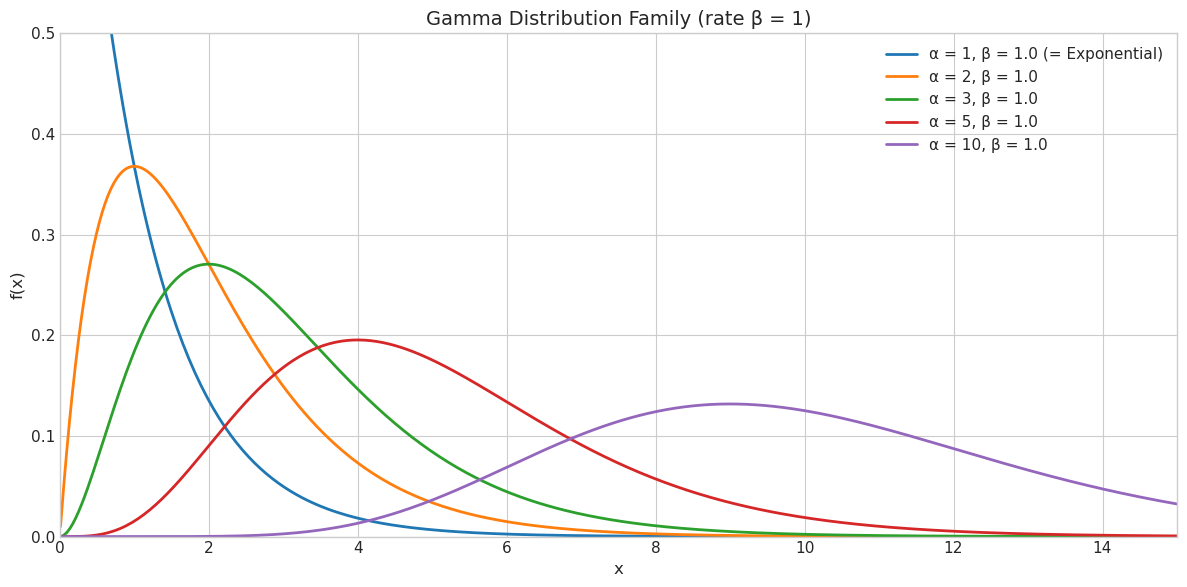


Verification: Gamma(1, 1) = Exponential(1)
----------------------------------------
x = 0.5: Gamma PDF = 0.606531, Exp PDF = 0.606531
x = 1.0: Gamma PDF = 0.367879, Exp PDF = 0.367879
x = 2.0: Gamma PDF = 0.135335, Exp PDF = 0.135335


In [33]:
def visualize_gamma_family():
    """Visualize Gamma distributions with different shape parameters."""
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.linspace(0.01, 20, 500)
    
    # Different shape parameters, same rate
    beta = 1.0  # rate
    shapes = [1, 2, 3, 5, 10]
    
    for alpha in shapes:
        # SciPy uses (shape a, scale=1/beta)
        gamma_dist = stats.gamma(a=alpha, scale=1/beta)
        label = f'α = {alpha}, β = {beta}' + (' (= Exponential)' if alpha == 1 else '')
        ax.plot(x, gamma_dist.pdf(x), linewidth=2, label=label)
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('f(x)', fontsize=12)
    ax.set_title('Gamma Distribution Family (rate β = 1)', fontsize=14)
    ax.legend(loc='upper right')
    ax.set_ylim(0, 0.5)
    ax.set_xlim(0, 15)
    
    plt.tight_layout()
    plt.show()
    
    # Verify Gamma(1, β) = Exponential(β)
    print("\nVerification: Gamma(1, 1) = Exponential(1)")
    print("-" * 40)
    test_points = [0.5, 1.0, 2.0]
    gamma_1_1 = stats.gamma(a=1, scale=1)
    exp_1 = stats.expon(scale=1)
    for x in test_points:
        print(f"x = {x}: Gamma PDF = {gamma_1_1.pdf(x):.6f}, Exp PDF = {exp_1.pdf(x):.6f}")

visualize_gamma_family()

### Beta Distribution

The natural distribution for **proportions** and **probabilities** on [0, 1]. Conjugate prior for binomial likelihood.

$$X \sim \text{Beta}(\alpha, \beta) \quad \Rightarrow \quad f(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}$$

| Property | Value |
|----------|-------|
| Support | $(0, 1)$ |
| Mean | $\alpha/(\alpha + \beta)$ |
| Variance | $\alpha\beta/[(\alpha+\beta)^2(\alpha+\beta+1)]$ |

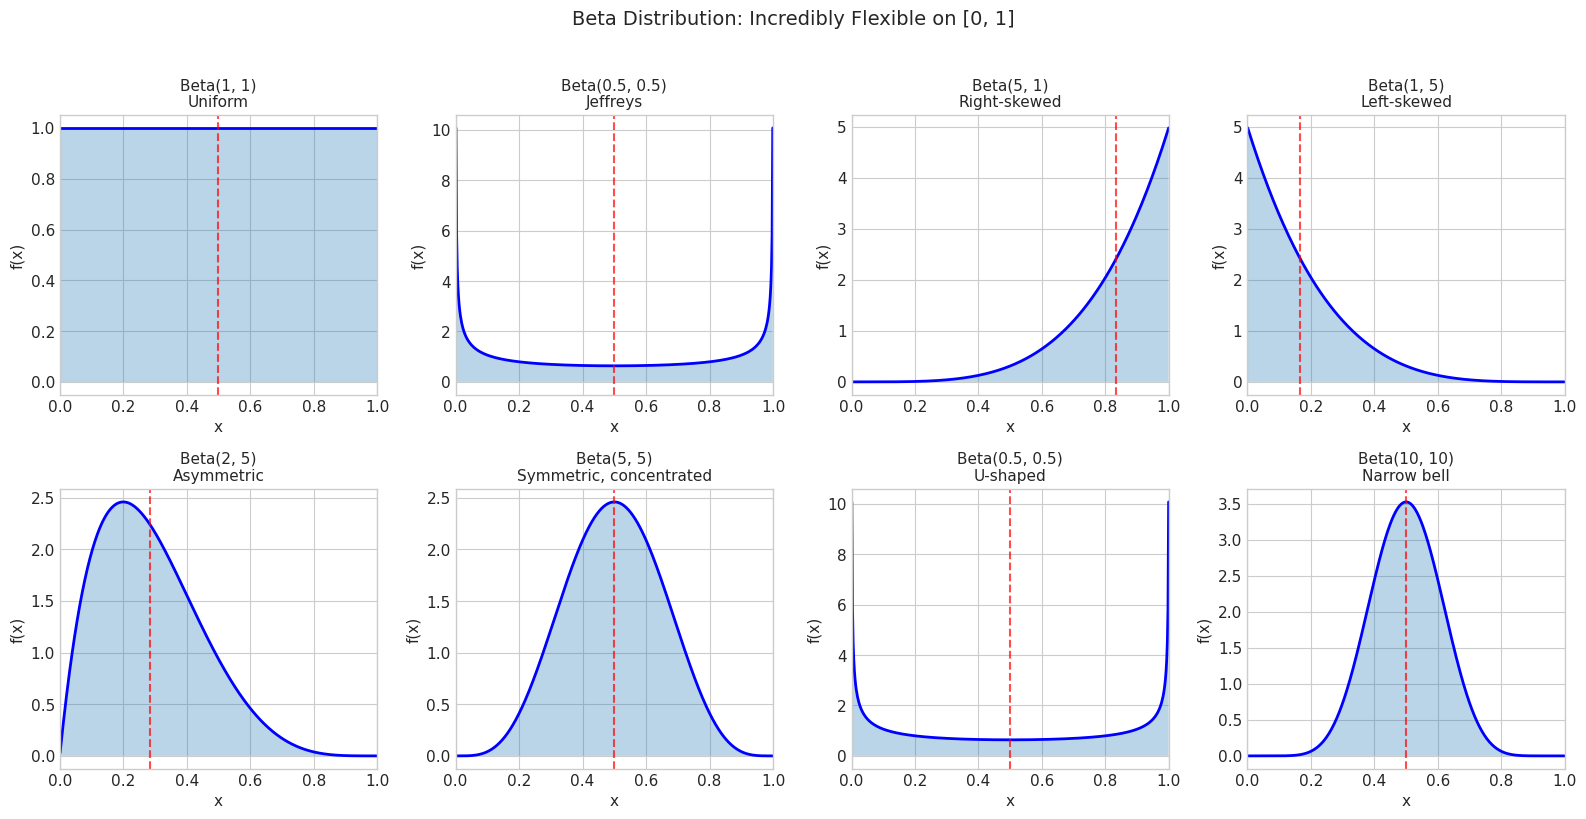

In [34]:
def visualize_beta_family():
    """Visualize the incredible flexibility of the Beta distribution."""
    
    params = [
        (1, 1, 'Uniform'),
        (0.5, 0.5, 'Jeffreys'),
        (5, 1, 'Right-skewed'),
        (1, 5, 'Left-skewed'),
        (2, 5, 'Asymmetric'),
        (5, 5, 'Symmetric, concentrated'),
        (0.5, 0.5, 'U-shaped'),
        (10, 10, 'Narrow bell'),
    ]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    x = np.linspace(0.001, 0.999, 500)
    
    for idx, (a, b, name) in enumerate(params):
        ax = axes[idx]
        beta_dist = stats.beta(a, b)
        ax.plot(x, beta_dist.pdf(x), 'b-', linewidth=2)
        ax.fill_between(x, beta_dist.pdf(x), alpha=0.3)
        ax.set_title(f'Beta({a}, {b})\n{name}', fontsize=11)
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_xlim(0, 1)
        
        # Show mean
        mean = a / (a + b)
        ax.axvline(x=mean, color='red', linestyle='--', alpha=0.7)
    
    plt.suptitle('Beta Distribution: Incredibly Flexible on [0, 1]', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

visualize_beta_family()

---
---

<h2 align="center">📊 Inference Distributions</h2>

<hr>

These distributions arise naturally when making inferences about normal populations with estimated variance.

### Chi-Squared Distribution

The distribution of the sum of squared standard normal variables.

$$X \sim \chi^2(k) \quad \Leftrightarrow \quad X = \sum_{i=1}^{k} Z_i^2 \text{ where } Z_i \sim \mathcal{N}(0,1)$$

| Property | Value |
|----------|-------|
| Support | $(0, \infty)$ |
| Mean | $k$ |
| Variance | $2k$ |

### Student's t-Distribution

The distribution of a standardized normal divided by the square root of a chi-squared divided by its degrees of freedom.

$$T = \frac{Z}{\sqrt{V/\nu}} \sim t(\nu) \quad \text{where } Z \sim \mathcal{N}(0,1), \, V \sim \chi^2(\nu)$$

| Property | Value |
|----------|-------|
| Support | $(-\infty, \infty)$ |
| Mean | $0$ (for $\nu > 1$) |
| Variance | $\nu/(\nu-2)$ (for $\nu > 2$) |

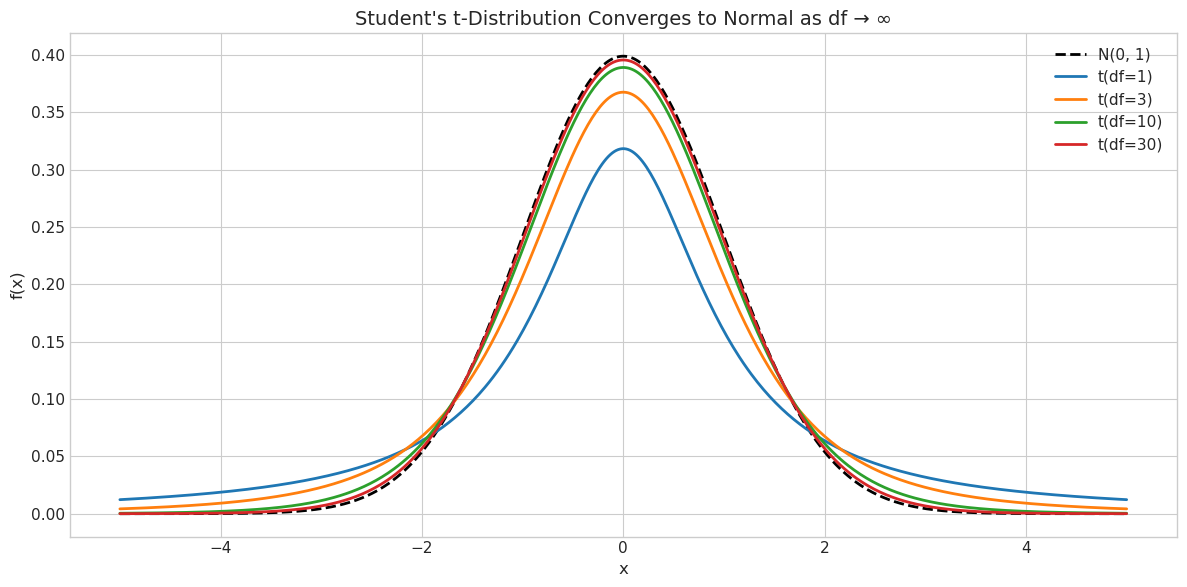

Heavy Tails: t vs Normal
----------------------------------------
P(|X| > 2) for different distributions:
  Normal:   0.0455
  t(df=3):  0.1393
  t(df=10): 0.0734
  t(df=30): 0.0546


In [35]:
def visualize_t_distribution():
    """Visualize t-distributions converging to normal."""
    
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.linspace(-5, 5, 500)
    
    # Standard normal for comparison
    ax.plot(x, stats.norm.pdf(x), 'k--', linewidth=2, label='N(0, 1)')
    
    # t-distributions with increasing df
    for df in [1, 3, 10, 30]:
        t_dist = stats.t(df)
        ax.plot(x, t_dist.pdf(x), linewidth=2, label=f't(df={df})')
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('f(x)', fontsize=12)
    ax.set_title('Student\'s t-Distribution Converges to Normal as df → ∞', fontsize=14)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Heavy tails comparison
    print("Heavy Tails: t vs Normal")
    print("-" * 40)
    print("P(|X| > 2) for different distributions:")
    print(f"  Normal:   {2 * stats.norm.sf(2):.4f}")
    print(f"  t(df=3):  {2 * stats.t(3).sf(2):.4f}")
    print(f"  t(df=10): {2 * stats.t(10).sf(2):.4f}")
    print(f"  t(df=30): {2 * stats.t(30).sf(2):.4f}")

visualize_t_distribution()

---
---

<h2 align="center">🔄 Central Limit Theorem</h2>

<hr>

The **Central Limit Theorem** is arguably the most important result in statistics: the sum (or mean) of many independent random variables tends toward a normal distribution, regardless of the original distribution.

$$\frac{\bar{X}_n - \mu}{\sigma/\sqrt{n}} \xrightarrow{d} \mathcal{N}(0, 1) \text{ as } n \to \infty$$

In [39]:
def demonstrate_clt(dist_name: str, dist, n_values: list = [1, 2, 5, 30]):
    """
    Demonstrate the Central Limit Theorem for any distribution.
    
    Shows how the distribution of sample means approaches normal.
    """
    n_simulations = 10000
    rng = np.random.default_rng(42)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    mu = dist.mean()
    sigma = dist.std()
    
    for idx, n in enumerate(n_values):
        ax = axes[idx]
        
        # Generate sample means
        sample_means = np.array([
            dist.rvs(size=n, random_state=rng).mean() 
            for _ in range(n_simulations)
        ])
        
        # Standardize
        standardized = (sample_means - mu) / (sigma / np.sqrt(n))
        
        # Plot histogram of standardized means
        ax.hist(standardized, bins=50, density=True, alpha=0.7, 
                color='steelblue', edgecolor='navy')
        
        # Overlay standard normal
        x = np.linspace(-4, 4, 200)
        ax.plot(x, stats.norm.pdf(x), 'r-', linewidth=2, label='N(0,1)')
        
        ax.set_xlabel('Standardized Sample Mean')
        ax.set_ylabel('Density')
        ax.set_title(f'n = {n}')
        ax.legend()
        ax.set_xlim(-4, 4)
    
    plt.suptitle(f'Central Limit Theorem: {dist_name}\n'
                 r'Distribution of $(\bar{X}_n - \mu)/(\sigma/\sqrt{n})$',
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

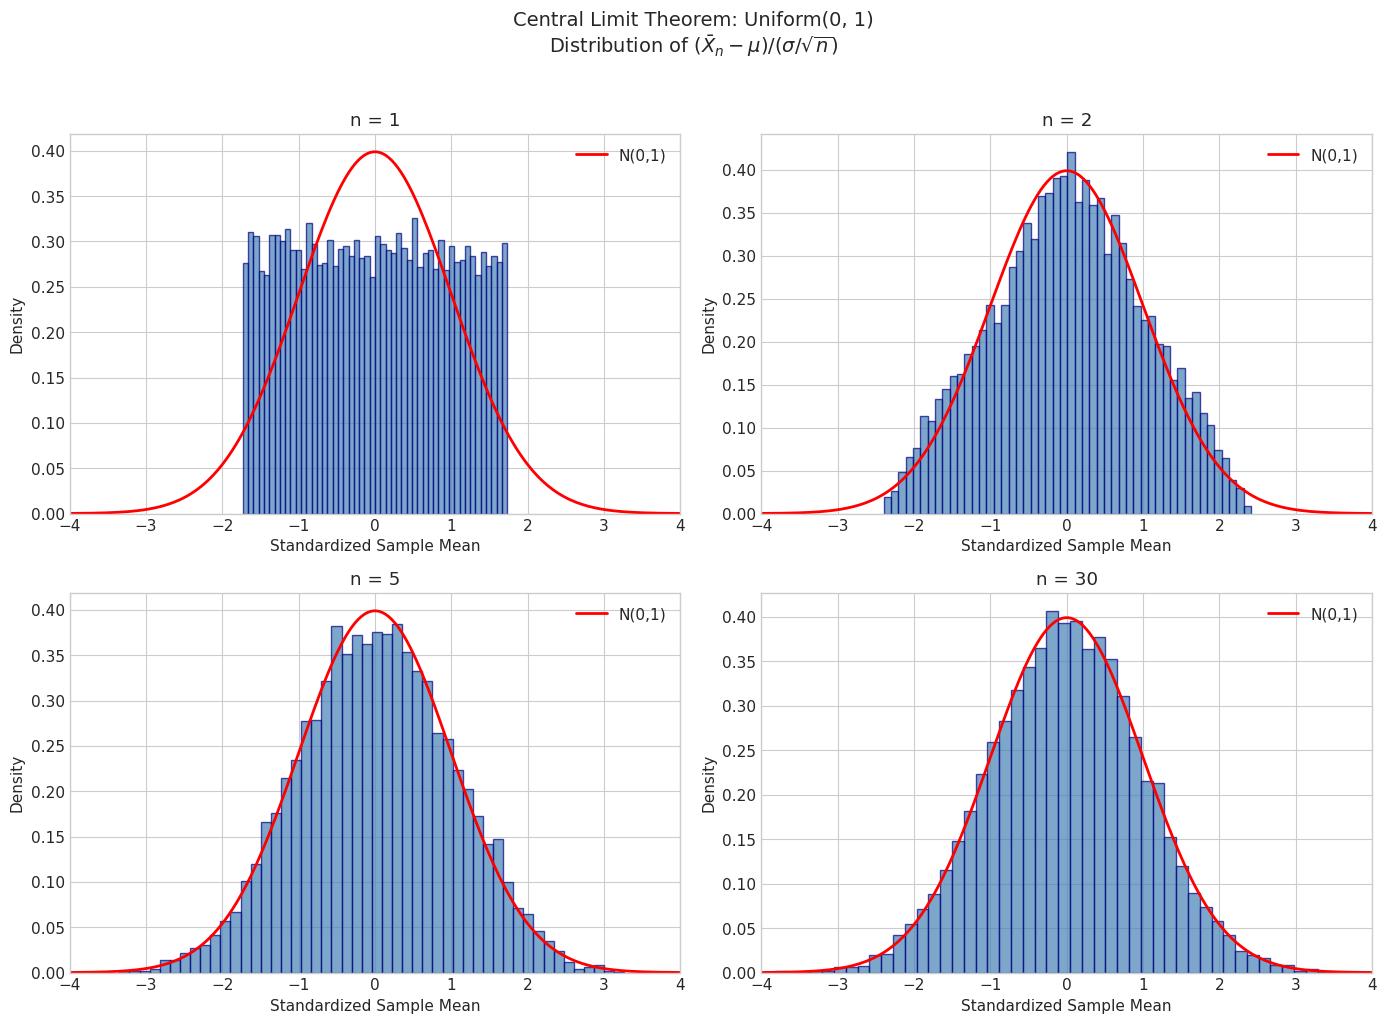

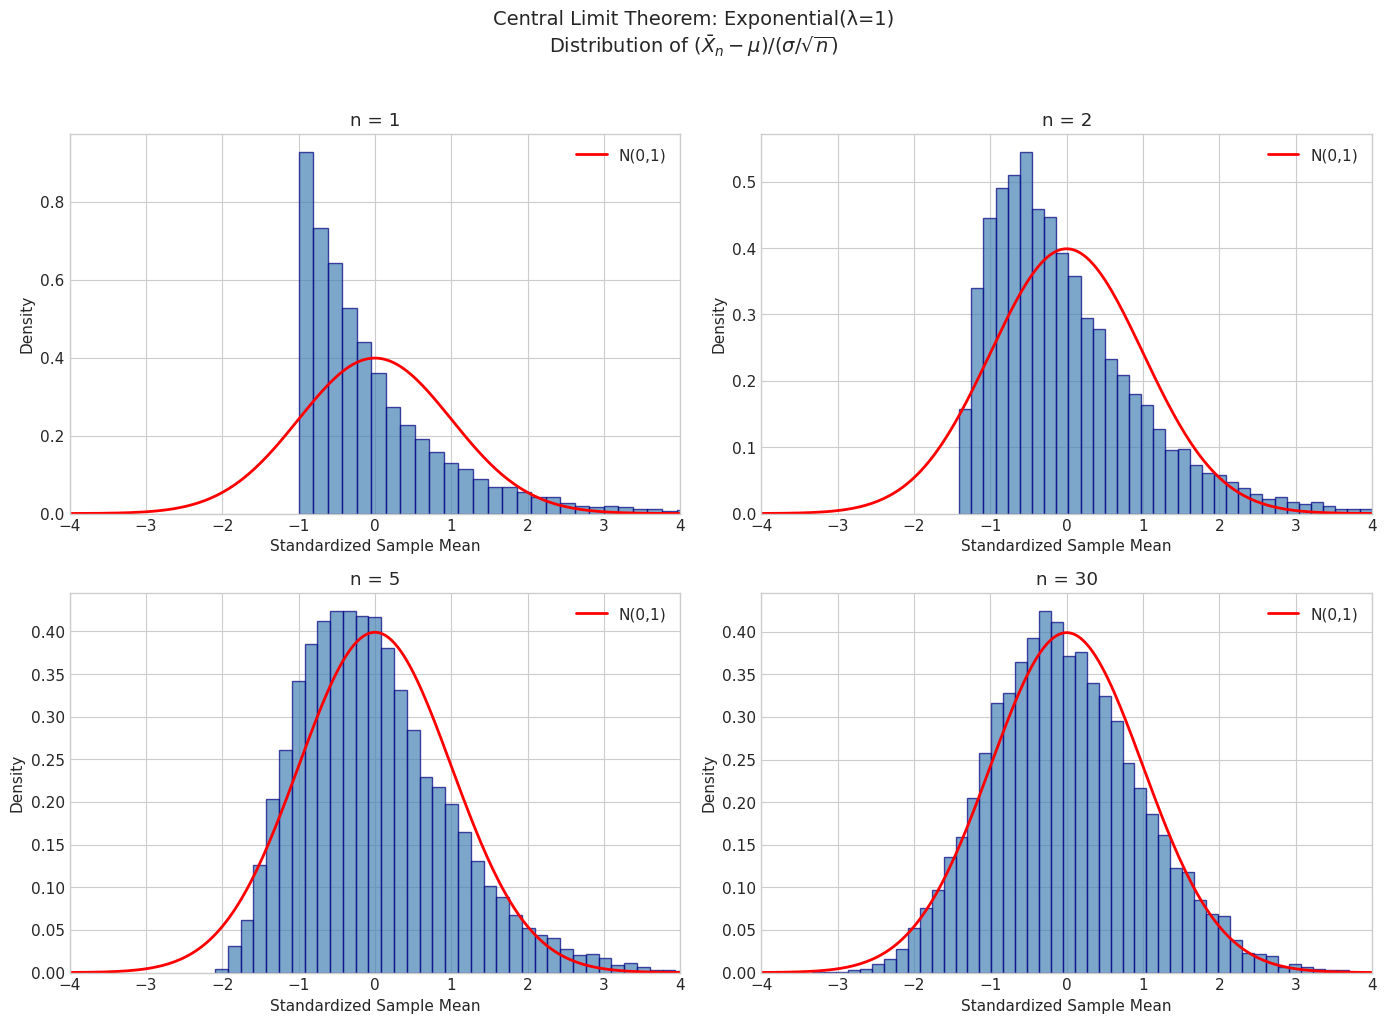

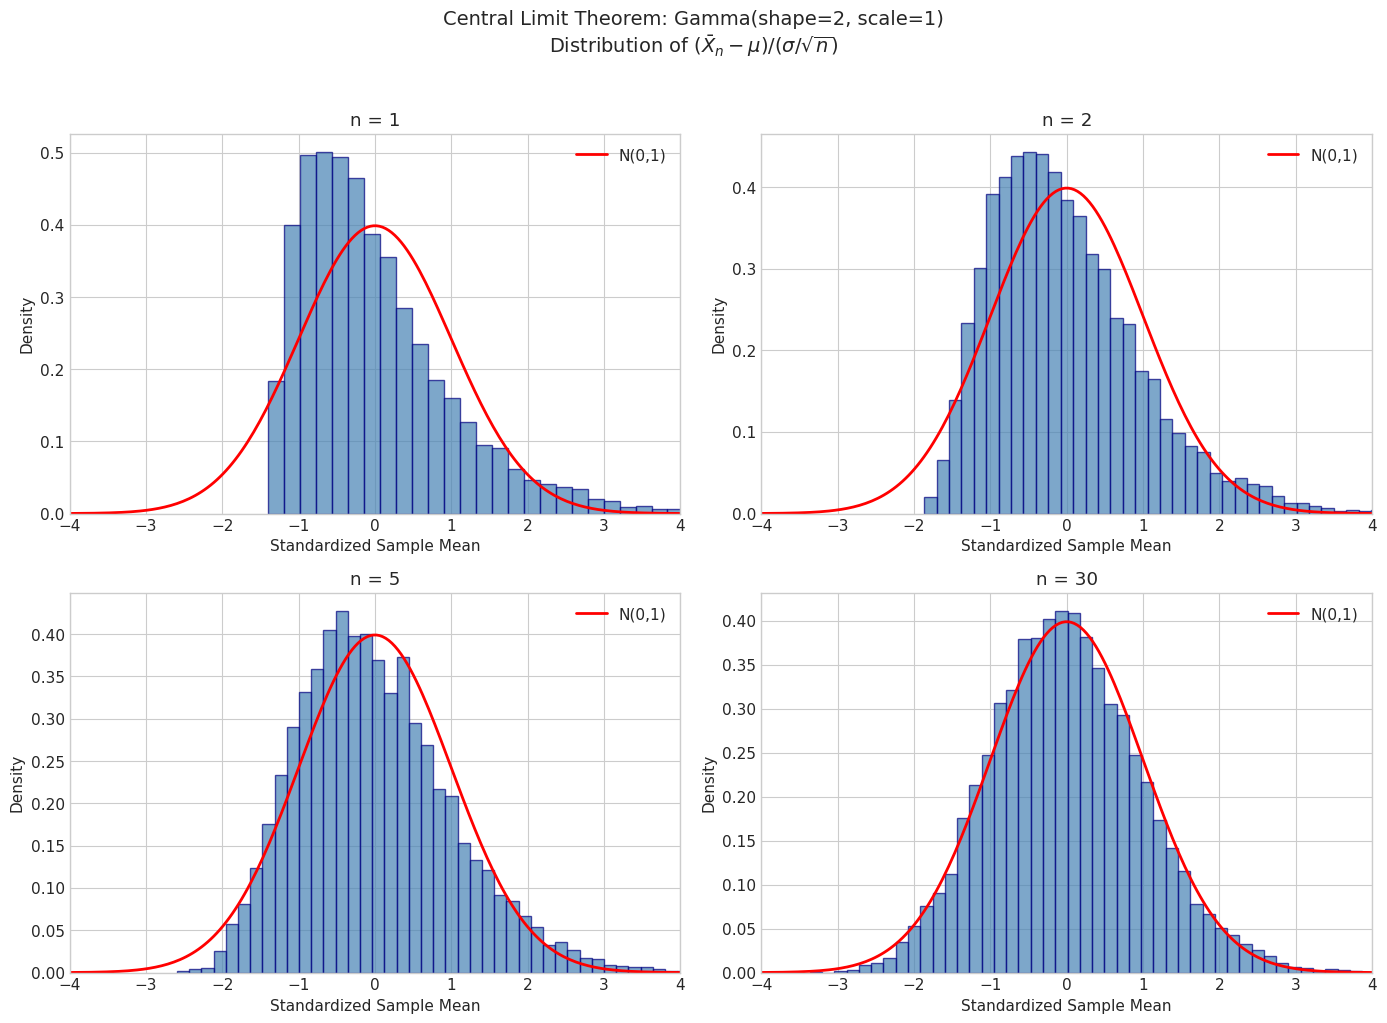

In [42]:
# CLT for uniform distribution (symmetric)
demonstrate_clt('Uniform(0, 1)', stats.uniform(0, 1))

# CLT for exponential (highly skewed)
demonstrate_clt('Exponential(λ=1)', stats.expon(scale=1))

# CLT for Gamma (moderately skewed)
demonstrate_clt('Gamma(shape=2, scale=1)', stats.gamma(a=2, scale=1))

---
---

<h2 align="center">🔗 Distribution Relationships</h2>

<hr>

Understanding how distributions relate helps in choosing models and deriving results.

| Relationship | Formula |
|--------------|----------|
| Bernoulli → Binomial | Sum of n Bernoulli(p) = Binomial(n, p) |
| Binomial → Poisson | Binomial(n, λ/n) → Poisson(λ) as n → ∞ |
| Exponential → Gamma | Sum of n Exponential(λ) = Gamma(n, λ) |
| Normal² → Chi-squared | Sum of k N(0,1)² = χ²(k) |
| Normal/Chi → t | N(0,1)/√(χ²(ν)/ν) = t(ν) |
| Beta(1,1) → Uniform | Beta(1,1) = Uniform(0,1) |

In [41]:
# Exercise 3 Solution
print("t vs Normal Critical Values (97.5th percentile)")
print("=" * 50)
print(f"{'df':<10} {'t(df)':<12} {'Difference from Normal':<20}")
print("-" * 50)

z_crit = stats.norm.ppf(0.975)
print(f"{'∞ (Normal)':<10} {z_crit:<12.4f} {'0 (reference)':<20}")

for df in [5, 10, 30, 100]:
    t_crit = stats.t(df).ppf(0.975)
    diff = t_crit - z_crit
    print(f"{df:<10} {t_crit:<12.4f} {diff:<20.4f}")

t vs Normal Critical Values (97.5th percentile)
df         t(df)        Difference from Normal
--------------------------------------------------
∞ (Normal) 1.9600       0 (reference)       
5          2.5706       0.6106              
10         2.2281       0.2682              
30         2.0423       0.0823              
100        1.9840       0.0240              



---
---

# Section 1.3: Random Number Generation with Python

---


---
---

<h2 align="center">🗺️ The Python Ecosystem at a Glance</h2>

<hr>

| Library | Best For | Key Advantage |
|---------|----------|---------------|
| `random` (stdlib) | Teaching, prototyping | Zero dependencies |
| `numpy.random` | Large-scale simulation | 10-100× faster, vectorized |
| `scipy.stats` | Statistical modeling | 100+ distributions, fitting, tests |
| PyTorch/TensorFlow | Deep learning | GPU acceleration |
| PyMC/Pyro/Stan | Bayesian models | MCMC & variational inference |

**Rule of thumb**:
- Need a few random numbers? → `random`
- Need arrays of random numbers fast? → NumPy `Generator`
- Need PDF/CDF/quantile calculations? → `scipy.stats`

---
---

<h2 align="center">🎰 Understanding Pseudo-Random Number Generation</h2>

<hr>

Computers are deterministic machines—given the same input, they produce the same output. So how do they generate "random" numbers?

**Pseudo-random number generators (PRNGs)** are deterministic algorithms that produce sequences of numbers which pass statistical tests for randomness, even though they're entirely predictable given the algorithm and starting point.

### Why Pseudo-Randomness is Actually Good

| Feature | Benefit |
|---------|--------|
| **Reproducibility** | Same seed → same sequence → reproducible science |
| **Debugging** | Fix the seed to reproduce problematic runs |
| **Testing** | Deterministic pass/fail criteria for stochastic code |

In [45]:
# Demonstrating reproducibility with seeds
print("Reproducibility with Seeds")
print("=" * 50)

# Same seed → same sequence
random.seed(42)
seq1 = [random.random() for _ in range(5)]

random.seed(42)  # Reset to same seed
seq2 = [random.random() for _ in range(5)]

print(f"Sequence 1: {[f'{x:.4f}' for x in seq1]}")
print(f"Sequence 2: {[f'{x:.4f}' for x in seq2]}")
print(f"Identical? {seq1 == seq2}")

# Different seed → different sequence
random.seed(123)
seq3 = [random.random() for _ in range(5)]
print(f"\nSequence 3 (seed=123): {[f'{x:.4f}' for x in seq3]}")

Reproducibility with Seeds
Sequence 1: ['0.6394', '0.0250', '0.2750', '0.2232', '0.7365']
Sequence 2: ['0.6394', '0.0250', '0.2750', '0.2232', '0.7365']
Identical? True

Sequence 3 (seed=123): ['0.0524', '0.0872', '0.4072', '0.1077', '0.9012']


### The Mersenne Twister (Python's Default)

Python's `random` module uses the **Mersenne Twister** (MT19937):

| Property | Value |
|----------|-------|
| Period | $2^{19937} - 1$ (≈ $10^{6001}$) |
| State size | 624 × 32-bit integers |
| Equidistribution | 623-dimensional |
| Security | **NOT cryptographically secure** |

### NumPy's PCG64 (Modern Default)

NumPy's `Generator` uses **PCG64** (Permuted Congruential Generator):

| Property | Value |
|----------|-------|
| Period | $2^{128}$ |
| State size | 128 bits (much smaller) |
| Statistical quality | Passes more stringent tests |
| Jumpable | Can efficiently skip ahead |

---
---

<h2 align="center">🎲 The Standard Library: `random` Module</h2>

<hr>

Ships with every Python installation—**zero external dependencies**.

### Basic Random Number Functions

| Function | Output | Domain | Notes |
|----------|--------|--------|-------|
| `random()` | float | [0, 1) | Fundamental building block |
| `uniform(a, b)` | float | [a, b] | `a + (b-a) * random()` |
| `randint(a, b)` | int | [a, b] | **Inclusive** on both ends |
| `randrange(a, b)` | int | [a, b) | **Exclusive** on right end |

In [50]:
from statistics import mean, pvariance

random.seed(42)

print("Basic Random Number Generation")
print("=" * 50)

# U(0,1) samples
n = 10000
u01_samples = [random.random() for _ in range(n)]
print(f"\nU(0,1) samples (n={n}):")
print(f"  Mean:     {mean(u01_samples):.5f} (theory: 0.5)")
print(f"  Variance: {pvariance(u01_samples):.5f} (theory: 0.0833)")

# U(a,b) samples
a, b = 5, 15
uab_samples = [random.uniform(a, b) for _ in range(n)]
print(f"\nU({a},{b}) samples (n={n}):")
print(f"  Mean:     {mean(uab_samples):.5f} (theory: {(a+b)/2})")
print(f"  Variance: {pvariance(uab_samples):.5f} (theory: {(b-a)**2/12:.4f})")

# Discrete uniform (dice)
dice_rolls = [random.randint(1, 6) for _ in range(n)]
print(f"\nDice rolls (n={n}):")
print(f"  Mean:     {mean(dice_rolls):.5f} (theory: 3.5)")
counts = Counter(dice_rolls)
print(f"  Distribution: {dict(sorted(counts.items()))}")

Basic Random Number Generation

U(0,1) samples (n=10000):
  Mean:     0.50025 (theory: 0.5)
  Variance: 0.08276 (theory: 0.0833)

U(5,15) samples (n=10000):
  Mean:     10.02484 (theory: 10.0)
  Variance: 8.40129 (theory: 8.3333)

Dice rolls (n=10000):
  Mean:     3.50030 (theory: 3.5)
  Distribution: {1: 1647, 2: 1679, 3: 1646, 4: 1722, 5: 1664, 6: 1642}


### Sequence Operations

| Function | Purpose | With Replacement? |
|----------|---------|-------------------|
| `choice(seq)` | Pick one element | Yes (single draw) |
| `choices(seq, k=n)` | Pick n elements | Yes |
| `sample(seq, k=n)` | Pick n elements | **No** |
| `shuffle(seq)` | Reorder in-place | N/A |

In [51]:
random.seed(42)

deck = list(range(1, 14)) * 4  # 52-card deck (values 1-13, 4 suits)
colors = ['red', 'blue', 'green', 'yellow']

print("Sequence Operations")
print("=" * 50)

# Single choice
print(f"\nrandom.choice(colors): {random.choice(colors)}")

# Multiple with replacement
print(f"random.choices(colors, k=10): {random.choices(colors, k=10)}")

# Multiple without replacement
print(f"random.sample(colors, k=3): {random.sample(colors, k=3)}")

# Weighted sampling
weights = [0.1, 0.2, 0.3, 0.4]  # yellow is most likely
weighted_draws = random.choices(colors, weights=weights, k=1000)
print(f"\nWeighted sampling (1000 draws):")
print(f"  Weights: {dict(zip(colors, weights))}")
print(f"  Counts:  {dict(Counter(weighted_draws))}")

# Shuffle
hand = deck[:5]
print(f"\nOriginal hand: {hand}")
random.shuffle(hand)
print(f"Shuffled hand: {hand}")

Sequence Operations

random.choice(colors): red
random.choices(colors, k=10): ['red', 'blue', 'red', 'green', 'green', 'yellow', 'red', 'blue', 'red', 'red']
random.sample(colors, k=3): ['red', 'green', 'yellow']

Weighted sampling (1000 draws):
  Weights: {'red': 0.1, 'blue': 0.2, 'green': 0.3, 'yellow': 0.4}
  Counts:  {'yellow': 399, 'green': 302, 'blue': 201, 'red': 98}

Original hand: [1, 2, 3, 4, 5]
Shuffled hand: [2, 4, 5, 3, 1]


### Distribution Functions in `random`

| Function | Distribution | Parameters |
|----------|--------------|------------|
| `gauss(mu, sigma)` | Normal | mean, std dev |
| `expovariate(lambd)` | Exponential | **rate** λ (not scale!) |
| `betavariate(alpha, beta)` | Beta | shape parameters |
| `gammavariate(alpha, beta)` | Gamma | shape, **rate** |
| `triangular(low, high, mode)` | Triangular | bounds, peak |

In [52]:
random.seed(42)
n = 10000

print("Standard Library Distribution Functions")
print("=" * 50)

# Normal distribution
mu, sigma = 5, 2
normal_samples = [random.gauss(mu, sigma) for _ in range(n)]
print(f"\nGauss(μ={mu}, σ={sigma}):")
print(f"  Sample mean: {mean(normal_samples):.4f} (theory: {mu})")
print(f"  Sample std:  {pvariance(normal_samples)**0.5:.4f} (theory: {sigma})")

# Exponential distribution
rate = 0.5  # mean = 1/rate = 2
exp_samples = [random.expovariate(rate) for _ in range(n)]
print(f"\nExponential(λ={rate}):")
print(f"  Sample mean: {mean(exp_samples):.4f} (theory: {1/rate})")

# Beta distribution
alpha, beta = 2, 5
beta_samples = [random.betavariate(alpha, beta) for _ in range(n)]
print(f"\nBeta(α={alpha}, β={beta}):")
print(f"  Sample mean: {mean(beta_samples):.4f} (theory: {alpha/(alpha+beta):.4f})")

Standard Library Distribution Functions

Gauss(μ=5, σ=2):
  Sample mean: 4.9765 (theory: 5)
  Sample std:  1.9991 (theory: 2)

Exponential(λ=0.5):
  Sample mean: 2.0114 (theory: 2.0)

Beta(α=2, β=5):
  Sample mean: 0.2875 (theory: 0.2857)


---
---

<h2 align="center">⚡ NumPy: High-Performance Random Generation</h2>

<hr>

NumPy's `Generator` API (introduced in v1.17) is the modern way to generate random numbers:
- **10-100× faster** than Python loops
- **Vectorized** operations return arrays
- **Better statistical properties** (PCG64 default)
- **Parallel-safe** with `SeedSequence.spawn()`

### NumPy Distribution Methods

| Method | Distribution | Notes |
|--------|--------------|-------|
| `rng.uniform(low, high, size)` | Uniform | Both bounds as args |
| `rng.normal(loc, scale, size)` | Normal | loc=μ, scale=σ |
| `rng.exponential(scale, size)` | Exponential | **scale = 1/rate** |
| `rng.gamma(shape, scale, size)` | Gamma | scale = 1/rate |
| `rng.beta(a, b, size)` | Beta | shape parameters |
| `rng.poisson(lam, size)` | Poisson | rate parameter |
| `rng.binomial(n, p, size)` | Binomial | trials, probability |

### Parallel Random Streams

For parallel computing, each worker needs an **independent** random stream. NumPy's `SeedSequence.spawn()` creates provably independent child streams.

In [53]:
from numpy.random import SeedSequence, default_rng

# Create independent streams for parallel workers
n_workers = 4
parent_seed = SeedSequence(42)
child_seeds = parent_seed.spawn(n_workers)
rngs = [default_rng(seed) for seed in child_seeds]

print("Parallel Random Streams")
print("=" * 50)

# Each worker generates samples
samples_per_worker = 10000
results = [rng.standard_normal(samples_per_worker) for rng in rngs]

# Verify independence: check correlation between workers
print("\nCorrelation between worker streams:")
for i in range(n_workers):
    for j in range(i+1, n_workers):
        corr = np.corrcoef(results[i], results[j])[0, 1]
        print(f"  Workers {i} & {j}: r = {corr:.6f}")

print("\n(Values near 0 indicate independence)")

Parallel Random Streams

Correlation between worker streams:
  Workers 0 & 1: r = 0.000949
  Workers 0 & 2: r = -0.009865
  Workers 0 & 3: r = -0.002701
  Workers 1 & 2: r = 0.001987
  Workers 1 & 3: r = -0.009509
  Workers 2 & 3: r = -0.000983

(Values near 0 indicate independence)


---
---

<h2 align="center">📊 SciPy: The Complete Statistical Toolkit</h2>

<hr>

`scipy.stats` provides **100+ distributions** with a unified interface:
- PDF/PMF, CDF, quantile (inverse CDF)
- Random sampling
- Parameter estimation (fitting)
- Statistical tests

In [54]:
# SciPy's unified interface
print("SciPy Unified Distribution Interface")
print("=" * 50)

# Create a distribution object
dist = stats.norm(loc=0, scale=1)  # Standard normal

print("\nMethods available for any distribution:")
print(f"  dist.pdf(x)  - Probability density at x")
print(f"  dist.cdf(x)  - Cumulative probability P(X ≤ x)")
print(f"  dist.ppf(q)  - Quantile (inverse CDF)")
print(f"  dist.sf(x)   - Survival function P(X > x)")
print(f"  dist.rvs(n)  - Random samples")
print(f"  dist.mean()  - Theoretical mean")
print(f"  dist.var()   - Theoretical variance")

# Demonstrate
x = 1.96
print(f"\nFor N(0,1) at x = {x}:")
print(f"  PDF:  {dist.pdf(x):.6f}")
print(f"  CDF:  {dist.cdf(x):.6f}")
print(f"  SF:   {dist.sf(x):.6f}")
print(f"  PPF(0.975):  {dist.ppf(0.975):.6f}")

SciPy Unified Distribution Interface

Methods available for any distribution:
  dist.pdf(x)  - Probability density at x
  dist.cdf(x)  - Cumulative probability P(X ≤ x)
  dist.ppf(q)  - Quantile (inverse CDF)
  dist.sf(x)   - Survival function P(X > x)
  dist.rvs(n)  - Random samples
  dist.mean()  - Theoretical mean
  dist.var()   - Theoretical variance

For N(0,1) at x = 1.96:
  PDF:  0.058441
  CDF:  0.975002
  SF:   0.024998
  PPF(0.975):  1.959964


---
---

<h2 align="center">⚠️ Parameterization: The Most Common Error Source</h2>

<hr>

Different libraries and textbooks use different parameterizations. **Always verify by checking sample means!**

In [55]:
print("Parameterization Reference")
print("=" * 70)
print(f"{'Distribution':<15} {'Textbook':<25} {'SciPy/NumPy':<25}")
print("-" * 70)
print(f"{'Exponential':<15} {'rate λ, mean=1/λ':<25} {'scale β=1/λ, mean=β':<25}")
print(f"{'Gamma':<15} {'shape α, rate β':<25} {'shape a, scale θ=1/β':<25}")
print(f"{'Normal':<15} {'μ, σ²':<25} {'loc=μ, scale=σ':<25}")

Parameterization Reference
Distribution    Textbook                  SciPy/NumPy              
----------------------------------------------------------------------
Exponential     rate λ, mean=1/λ          scale β=1/λ, mean=β      
Gamma           shape α, rate β           shape a, scale θ=1/β     
Normal          μ, σ²                     loc=μ, scale=σ           


---
---

<h2 align="center">🔧 Choosing the Right Tool</h2>

<hr>

In [56]:
print("Library Selection Guide")
print("=" * 60)

guide = """
USE `random` (standard library) WHEN:
  ✓ Zero dependencies required
  ✓ Teaching probability concepts
  ✓ Simple prototypes or scripts
  ✓ Sample sizes under ~10,000
  ✓ Need choice/shuffle/sample on lists

USE NumPy `Generator` WHEN:
  ✓ Working with arrays and matrices
  ✓ Sample sizes exceed 10,000
  ✓ Performance is critical
  ✓ Need multivariate distributions
  ✓ Parallel computing with independent streams

USE `scipy.stats` WHEN:
  ✓ Need PDF, CDF, or quantile functions
  ✓ Fitting distributions to data
  ✓ Performing statistical tests
  ✓ Computing theoretical properties
  ✓ Need exotic distributions (100+ available)

COMBINE THEM:
  → SciPy for distribution definition and analysis
  → NumPy for efficient sampling
  → Both for complete workflows
"""
print(guide)

Library Selection Guide

USE `random` (standard library) WHEN:
  ✓ Zero dependencies required
  ✓ Teaching probability concepts
  ✓ Simple prototypes or scripts
  ✓ Sample sizes under ~10,000
  ✓ Need choice/shuffle/sample on lists

USE NumPy `Generator` WHEN:
  ✓ Working with arrays and matrices
  ✓ Sample sizes exceed 10,000
  ✓ Performance is critical
  ✓ Need multivariate distributions
  ✓ Parallel computing with independent streams

USE `scipy.stats` WHEN:
  ✓ Need PDF, CDF, or quantile functions
  ✓ Fitting distributions to data
  ✓ Performing statistical tests
  ✓ Computing theoretical properties
  ✓ Need exotic distributions (100+ available)

COMBINE THEM:
  → SciPy for distribution definition and analysis
  → NumPy for efficient sampling
  → Both for complete workflows



---
---

<h2 align="center">✏️ Exercises</h2>

<hr>

### Exercise 1: Bootstrap Sampling
Given a sample of 100 observations, write a function that generates 1000 bootstrap samples and returns their means.

### Exercise 2: Weighted Sampling
Implement a lottery simulation where ticket A has 50% chance, B has 30%, and C has 20%. Run 10,000 draws and verify the proportions.

### Exercise 3: Parameterization Practice
Generate samples with the following specifications and verify means:
- Exponential with mean = 5
- Gamma with shape=4 and mean=8
- Normal with mean=10 and variance=4

### Exercise 4: Parallel Monte Carlo
Use 4 parallel streams to estimate π using Monte Carlo (quarter circle method).

In [57]:
# Exercise 4 Solution: Parallel Monte Carlo for π
from numpy.random import SeedSequence, default_rng

def estimate_pi_worker(rng, n_samples):
    """Estimate π using quarter circle method."""
    x = rng.uniform(0, 1, n_samples)
    y = rng.uniform(0, 1, n_samples)
    inside = (x**2 + y**2) <= 1
    return 4 * inside.sum() / n_samples

# Create parallel streams
n_workers = 4
samples_per_worker = 250000

parent = SeedSequence(42)
child_seeds = parent.spawn(n_workers)
rngs = [default_rng(s) for s in child_seeds]

# Run parallel estimation
estimates = [estimate_pi_worker(rng, samples_per_worker) for rng in rngs]

print("Parallel Monte Carlo π Estimation")
print("=" * 50)
print(f"\nIndividual worker estimates: {[f'{e:.6f}' for e in estimates]}")
print(f"Combined estimate (mean): {np.mean(estimates):.6f}")
print(f"True π: {np.pi:.6f}")
print(f"Error: {abs(np.mean(estimates) - np.pi):.6f}")

Parallel Monte Carlo π Estimation

Individual worker estimates: ['3.142048', '3.144896', '3.141856', '3.141808']
Combined estimate (mean): 3.142652
True π: 3.141593
Error: 0.001059



---
---

# Section 1.4: Chapter Summary and Synthesis Exercises

---


---
## 🏛️ The Three Pillars of Chapter 1

Chapter 1 established three interconnected pillars supporting all computational methods in data science.

### Pillar 1: Philosophical Foundations (Section 1.1)

We addressed the fundamental question: **What does probability mean?**

| Aspect | Frequentist | Bayesian |
|--------|-------------|----------|
| **Probability** | Long-run relative frequency | Degree of belief |
| **Parameters** | Fixed but unknown | Random variables with distributions |
| **Data** | Random (varies across samples) | Fixed (observed) |
| **Inference** | "What happens across repeated samples?" | "What should I believe given this evidence?" |
| **Intervals** | Confidence interval (covers true parameter 95% of the time) | Credible interval (95% posterior probability) |

In [58]:
# Quick demonstration: Same data, different paradigms
# 14 heads in 20 coin flips

n, k = 20, 14
p_hat = k / n

# Frequentist: Confidence interval using Normal approximation
se = np.sqrt(p_hat * (1 - p_hat) / n)
ci_freq = (p_hat - 1.96 * se, p_hat + 1.96 * se)

# Bayesian: Posterior with Beta(1,1) = Uniform prior
alpha_prior, beta_prior = 1, 1
alpha_post = alpha_prior + k
beta_post = beta_prior + (n - k)
posterior = stats.beta(alpha_post, beta_post)
ci_bayes = posterior.ppf([0.025, 0.975])

print("Same Data (14 heads in 20 flips), Different Paradigms:")
print(f"\nFrequentist:")
print(f"  Point estimate: p̂ = {p_hat:.3f}")
print(f"  95% CI: ({ci_freq[0]:.3f}, {ci_freq[1]:.3f})")
print(f"\nBayesian (uniform prior):")
print(f"  Posterior mean: {posterior.mean():.3f}")
print(f"  95% Credible interval: ({ci_bayes[0]:.3f}, {ci_bayes[1]:.3f})")

Same Data (14 heads in 20 flips), Different Paradigms:

Frequentist:
  Point estimate: p̂ = 0.700
  95% CI: (0.499, 0.901)

Bayesian (uniform prior):
  Posterior mean: 0.682
  95% Credible interval: (0.478, 0.854)


### Pillar 2: Mathematical Machinery (Section 1.2)

We reviewed the probability distributions that model real phenomena:

**Discrete Distributions:**
- Bernoulli, Binomial, Poisson, Geometric, Negative Binomial

**Continuous Distributions:**
- Uniform, Normal, Exponential, Gamma, Beta

**Inference Distributions:**
- Student's t, Chi-square, F

Key relationships connect them all: Binomial → Poisson (rare events), Exponential → Gamma (sum), CLT → Normal (standardized sums).

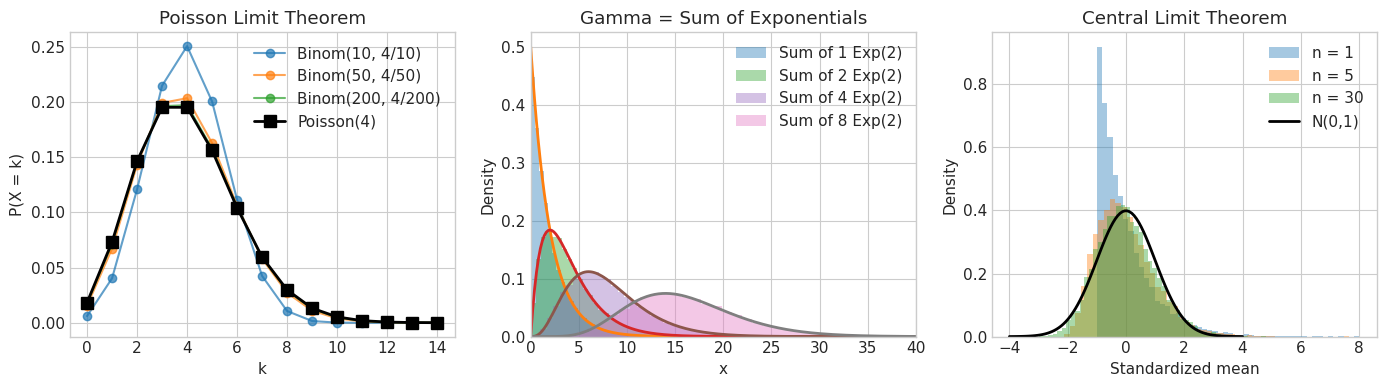

In [59]:
# Quick visualization of key distribution relationships
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Poisson limit of Binomial
ax = axes[0]
lam = 4
x = np.arange(0, 15)
for n in [10, 50, 200]:
    pmf = stats.binom.pmf(x, n, lam/n)
    ax.plot(x, pmf, 'o-', alpha=0.7, label=f'Binom({n}, {lam}/{n})')
ax.plot(x, stats.poisson.pmf(x, lam), 's-', color='black', 
        linewidth=2, markersize=8, label=f'Poisson({lam})')
ax.set_xlabel('k')
ax.set_ylabel('P(X = k)')
ax.set_title('Poisson Limit Theorem')
ax.legend()

# 2. Gamma as sum of Exponentials
ax = axes[1]
n_samples = 50000
scale = 2
for k in [1, 2, 4, 8]:
    exp_sum = np.sum(rng.exponential(scale, size=(n_samples, k)), axis=1)
    ax.hist(exp_sum, bins=50, density=True, alpha=0.4, label=f'Sum of {k} Exp({scale})')
    x = np.linspace(0, 40, 200)
    ax.plot(x, stats.gamma.pdf(x, a=k, scale=scale), linewidth=2)
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Gamma = Sum of Exponentials')
ax.legend()
ax.set_xlim(0, 40)

# 3. CLT: Standardized means converge to Normal
ax = axes[2]
n_means = 10000
# Start from Exponential (clearly non-normal)
true_mean, true_var = 2, 4  # Exp(0.5) has mean=2, var=4
for n in [1, 5, 30]:
    means = np.mean(rng.exponential(2, size=(n_means, n)), axis=1)
    standardized = (means - true_mean) / np.sqrt(true_var / n)
    ax.hist(standardized, bins=50, density=True, alpha=0.4, label=f'n = {n}')
x = np.linspace(-4, 4, 100)
ax.plot(x, stats.norm.pdf(x), 'k-', linewidth=2, label='N(0,1)')
ax.set_xlabel('Standardized mean')
ax.set_ylabel('Density')
ax.set_title('Central Limit Theorem')
ax.legend()

plt.tight_layout()
plt.show()

### Pillar 3: Computational Tools (Section 1.3)

We learned to generate random samples using Python's ecosystem:

| Tool | Use Case | Key Feature |
|------|----------|-------------|
| `random` module | Prototyping, teaching | Lightweight, no dependencies |
| NumPy `Generator` | Monte Carlo work | Vectorized, 50-100× faster |
| `scipy.stats` | Complete statistical toolkit | 100+ distributions, fitting, tests |

**Critical practices:**
- Reproducibility requires explicit seeds
- Parallel computing needs independent streams via `SeedSequence.spawn()`
- Watch parameterization differences (rate vs scale!)

In [60]:
# Quick demonstration of computational tools

# Reproducibility
rng1 = np.random.default_rng(12345)
rng2 = np.random.default_rng(12345)
print("Reproducibility check:")
print(f"  Same seed produces same values: {np.allclose(rng1.random(5), rng2.random(5))}")

# Independent parallel streams
from numpy.random import SeedSequence
ss = SeedSequence(42)
child_seeds = ss.spawn(4)
streams = [np.random.default_rng(s) for s in child_seeds]

# Generate samples from each stream
parallel_samples = np.array([s.normal(size=1000) for s in streams])

# Verify independence via correlation
correlations = []
for i in range(4):
    for j in range(i+1, 4):
        correlations.append(np.corrcoef(parallel_samples[i], parallel_samples[j])[0,1])
print(f"\nParallel stream independence:")
print(f"  Max |correlation| between streams: {np.max(np.abs(correlations)):.4f}")
print(f"  (Should be near 0 for independent streams)")

Reproducibility check:
  Same seed produces same values: True

Parallel stream independence:
  Max |correlation| between streams: 0.0257
  (Should be near 0 for independent streams)


---
## 🔗 How the Pillars Connect

The three pillars form an integrated foundation, not isolated topics.

### Paradigms Inform Distribution Choice

A Bayesian analyzing a proportion naturally thinks of:
- **Prior**: Beta distribution for $p$
- **Likelihood**: Binomial for the data
- **Posterior**: Beta (conjugacy!)

A frequentist focuses on the sampling distribution of $\hat{p}$, using CLT for large samples.

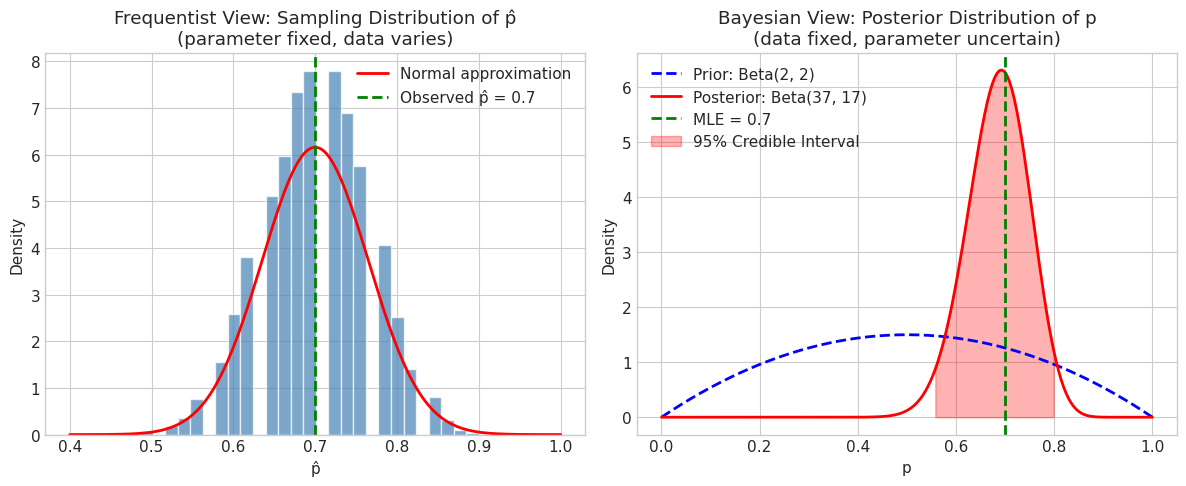

In [62]:
# Demonstrating how paradigm choice affects analysis structure

# Data: 35 successes in 50 trials
n, k = 50, 35
p_hat = k / n

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Frequentist: Focus on sampling distribution of p̂
ax = axes[0]
# Simulate the sampling distribution (if true p = 0.7)
true_p = 0.7
simulated_phats = rng.binomial(n, true_p, size=10000) / n
ax.hist(simulated_phats, bins=30, density=True, alpha=0.7, 
        color='steelblue', edgecolor='white')
# CLT approximation
x = np.linspace(0.4, 1.0, 200)
se = np.sqrt(true_p * (1 - true_p) / n)
ax.plot(x, stats.norm.pdf(x, true_p, se), 'r-', linewidth=2, 
        label='Normal approximation')
ax.axvline(p_hat, color='green', linestyle='--', linewidth=2, 
           label=f'Observed p̂ = {p_hat}')
ax.set_xlabel('p̂')
ax.set_ylabel('Density')
ax.set_title('Frequentist View: Sampling Distribution of p̂\n(parameter fixed, data varies)')
ax.legend()

# Bayesian: Focus on posterior distribution of p
ax = axes[1]
# Prior: Beta(2, 2) - weakly informative
alpha_prior, beta_prior = 2, 2
alpha_post = alpha_prior + k
beta_post = beta_prior + (n - k)

p_range = np.linspace(0, 1, 200)
ax.plot(p_range, stats.beta.pdf(p_range, alpha_prior, beta_prior), 
        'b--', linewidth=2, label=f'Prior: Beta({alpha_prior}, {beta_prior})')
ax.plot(p_range, stats.beta.pdf(p_range, alpha_post, beta_post), 
        'r-', linewidth=2, label=f'Posterior: Beta({alpha_post}, {beta_post})')
ax.axvline(p_hat, color='green', linestyle='--', linewidth=2, 
           label=f'MLE = {p_hat}')
# 95% credible interval
ci = stats.beta.ppf([0.025, 0.975], alpha_post, beta_post)
ax.fill_between(p_range, 0, stats.beta.pdf(p_range, alpha_post, beta_post),
                where=(p_range >= ci[0]) & (p_range <= ci[1]),
                alpha=0.3, color='red', label='95% Credible Interval')
ax.set_xlabel('p')
ax.set_ylabel('Density')
ax.set_title('Bayesian View: Posterior Distribution of p\n(data fixed, parameter uncertain)')
ax.legend()

plt.tight_layout()
plt.show()

### Distributions Enable Computational Methods

The **Inverse CDF Method** (Chapter 2) works because of the Probability Integral Transform:

$$F^{-1}(U) \sim F \quad \text{when} \quad U \sim \text{Uniform}(0,1)$$

Understanding distribution properties enables efficient simulation algorithms.

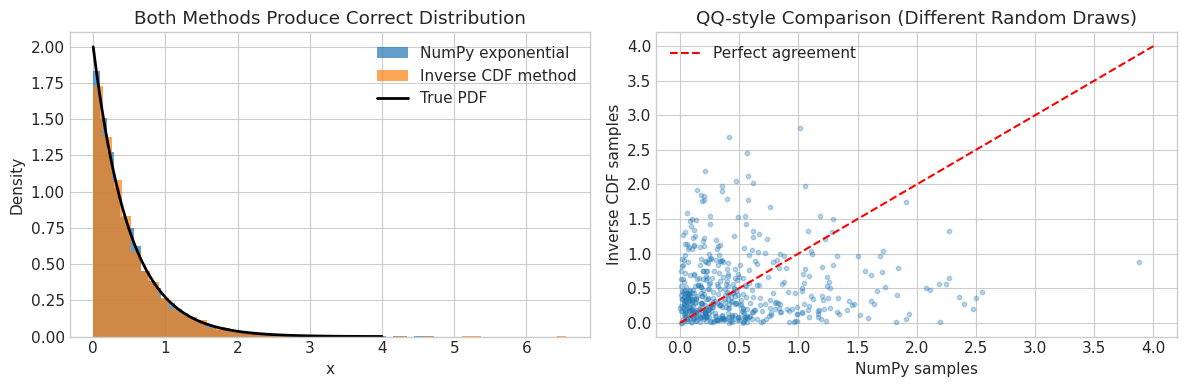

Sample statistics comparison:
  Theoretical mean: 0.5000
  NumPy mean: 0.4997
  Inverse CDF mean: 0.4988


In [63]:
# Preview: Inverse CDF method
# Generate Exponential samples from Uniform samples

lam = 2  # Rate parameter
n_samples = 10000

# Method 1: NumPy's built-in
direct_samples = rng.exponential(scale=1/lam, size=n_samples)

# Method 2: Inverse CDF - F^{-1}(u) = -ln(1-u)/λ
u = rng.uniform(size=n_samples)
inverse_cdf_samples = -np.log1p(-u) / lam  # log1p for numerical stability

# Compare
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.hist(direct_samples, bins=50, density=True, alpha=0.7, label='NumPy exponential')
ax.hist(inverse_cdf_samples, bins=50, density=True, alpha=0.7, label='Inverse CDF method')
x = np.linspace(0, 4, 100)
ax.plot(x, stats.expon.pdf(x, scale=1/lam), 'k-', linewidth=2, label='True PDF')
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Both Methods Produce Correct Distribution')
ax.legend()

ax = axes[1]
ax.scatter(direct_samples[:500], inverse_cdf_samples[:500], alpha=0.3, s=10)
ax.plot([0, 4], [0, 4], 'r--', label='Perfect agreement')
ax.set_xlabel('NumPy samples')
ax.set_ylabel('Inverse CDF samples')
ax.set_title('QQ-style Comparison (Different Random Draws)')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Sample statistics comparison:")
print(f"  Theoretical mean: {1/lam:.4f}")
print(f"  NumPy mean: {np.mean(direct_samples):.4f}")
print(f"  Inverse CDF mean: {np.mean(inverse_cdf_samples):.4f}")

### Computation Validates Theory

When we prove $\bar{X}_n \xrightarrow{P} \mu$ (Law of Large Numbers), we can verify computationally by watching convergence.

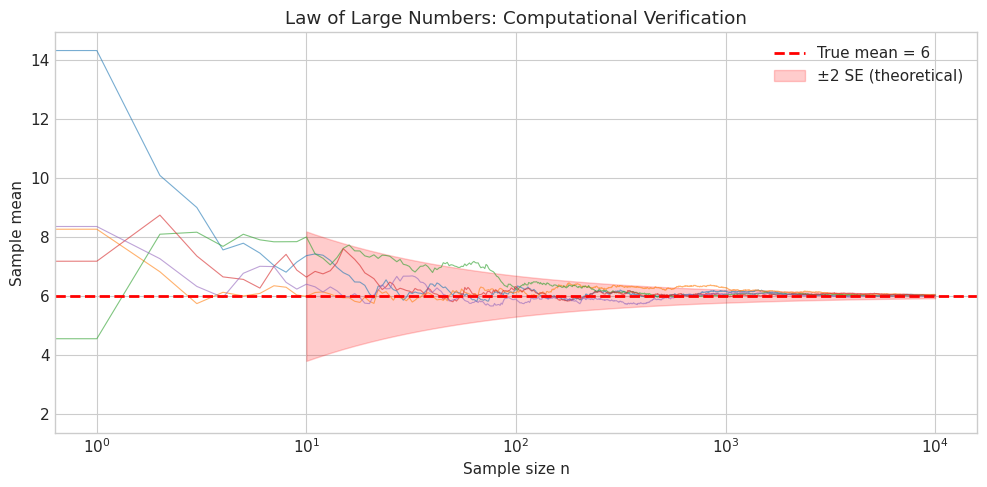

In [64]:
# Computational validation of LLN
# Sample from Gamma(3, 2) - true mean = 6

shape, scale = 3, 2
true_mean = shape * scale  # = 6

# Generate a long sequence and compute running mean
n_max = 10000
samples = rng.gamma(shape, scale, size=n_max)
running_mean = np.cumsum(samples) / np.arange(1, n_max + 1)

# Multiple realizations
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(5):
    samples_i = rng.gamma(shape, scale, size=n_max)
    running_mean_i = np.cumsum(samples_i) / np.arange(1, n_max + 1)
    ax.plot(running_mean_i, alpha=0.6, linewidth=0.8)

ax.axhline(true_mean, color='red', linestyle='--', linewidth=2, label=f'True mean = {true_mean}')
ax.set_xlabel('Sample size n')
ax.set_ylabel('Sample mean')
ax.set_title('Law of Large Numbers: Computational Verification')
ax.set_xscale('log')
ax.legend()

# Theory predicts: SE(X̄) = σ/√n
true_var = shape * scale**2  # = 12
ns = np.logspace(1, 4, 50).astype(int)
ax.fill_between(ns, 
                true_mean - 2*np.sqrt(true_var/ns), 
                true_mean + 2*np.sqrt(true_var/ns),
                alpha=0.2, color='red', label='±2 SE (theoretical)')
ax.legend()

plt.tight_layout()
plt.show()

---
## 💡 Integrating All Three Pillars: Complete Example

**Problem:** Estimate $P(X > 5)$ where $X \sim \text{Gamma}(3, 2)$ (shape 3, scale 2).

In [68]:
# =============================================================================
# THE THREE PILLARS WORKING TOGETHER
# =============================================================================
# Problem: What is P(X > 5) where X ~ Gamma(shape=3, scale=2)?

print("=" * 70)
print("THE THREE PILLARS OF CHAPTER 1")
print("=" * 70)
print("Problem: What is P(X > 5) where X ~ Gamma(shape=3, scale=2)?")
print()

# ─────────────────────────────────────────────────────────────────────────────
# PILLAR 3: Computational Tools (Section 1.3)
# ─────────────────────────────────────────────────────────────────────────────
print("PILLAR 3: Computational Tools (Monte Carlo Simulation)")
print("-" * 50)

rng = np.random.default_rng(seed=42)
n_samples = 100000

# Generate samples from Gamma(shape=3, scale=2)
samples = rng.gamma(shape=3, scale=2, size=n_samples)

# Estimate P(X > 5) as proportion of samples exceeding 5
prob_mc = np.mean(samples > 5)
se_mc = np.sqrt(prob_mc * (1 - prob_mc) / n_samples)

print(f"  Generated {n_samples:,} samples")
print(f"  P(X > 5) ≈ {prob_mc:.6f}")
print(f"  Monte Carlo SE = {se_mc:.6f}")
print(f"  95% CI: ({prob_mc - 1.96*se_mc:.6f}, {prob_mc + 1.96*se_mc:.6f})")
print()

# ─────────────────────────────────────────────────────────────────────────────
# PILLAR 2: Mathematical Machinery (Section 1.2)
# ─────────────────────────────────────────────────────────────────────────────
print("PILLAR 2: Mathematical Machinery (Exact Computation)")
print("-" * 50)

# Use scipy.stats distribution object
gamma_dist = stats.gamma(a=3, scale=2)

# Exact probability using survival function: sf(x) = 1 - cdf(x) = P(X > x)
prob_exact = gamma_dist.sf(5)

# Also show the CDF approach
prob_via_cdf = 1 - gamma_dist.cdf(5)

print(f"  Distribution: Gamma(shape=3, scale=2)")
print(f"  Mean = {gamma_dist.mean():.2f}, Variance = {gamma_dist.var():.2f}")
print(f"  P(X > 5) = 1 - F(5) = {prob_exact:.6f}")
print(f"  Verification: 1 - cdf(5) = {prob_via_cdf:.6f}")
print()

# Compare Monte Carlo to exact
print("  Comparison:")
print(f"    Monte Carlo estimate: {prob_mc:.6f}")
print(f"    Exact value:          {prob_exact:.6f}")
print(f"    Absolute error:       {abs(prob_mc - prob_exact):.6f}")
print()

# ─────────────────────────────────────────────────────────────────────────────
# PILLAR 1: Philosophical Foundations (Section 1.1)
# ─────────────────────────────────────────────────────────────────────────────
print("PILLAR 1: Philosophical Foundations (Interpretation)")
print("-" * 50)

print("\n  FREQUENTIST interpretation:")
print(f"    'The probability {prob_exact:.4f} represents the long-run frequency.")
print(f"     If we drew X from Gamma(3,2) infinitely many times,")
print(f"     {100*prob_exact:.2f}% of draws would exceed 5.'")
print()
print(f"    'The Monte Carlo estimate {prob_mc:.4f} ± {1.96*se_mc:.4f} is a")
print(f"     95% confidence interval. If we repeated this simulation")
print(f"     with different seeds, 95% of such intervals would")
print(f"     contain the true probability {prob_exact:.4f}.'")

print("\n  BAYESIAN interpretation:")
print(f"    'Given the model X ~ Gamma(3,2), my degree of belief")
print(f"     that X > 5 is {prob_exact:.4f}.'")
print()
print("    'If I were uncertain about the parameters (shape, scale),")
print("     I would specify priors on them and compute:")
print("     P(X > 5 | data) = ∫∫ P(X > 5 | shape, scale) × p(shape, scale | data) d(shape) d(scale)'")

print()
print("=" * 70)
print("KEY INSIGHT: Same calculation, different interpretations!")
print("=" * 70)

THE THREE PILLARS OF CHAPTER 1
Problem: What is P(X > 5) where X ~ Gamma(shape=3, scale=2)?

PILLAR 3: Computational Tools (Monte Carlo Simulation)
--------------------------------------------------
  Generated 100,000 samples
  P(X > 5) ≈ 0.543920
  Monte Carlo SE = 0.001575
  95% CI: (0.540833, 0.547007)

PILLAR 2: Mathematical Machinery (Exact Computation)
--------------------------------------------------
  Distribution: Gamma(shape=3, scale=2)
  Mean = 6.00, Variance = 12.00
  P(X > 5) = 1 - F(5) = 0.543813
  Verification: 1 - cdf(5) = 0.543813

  Comparison:
    Monte Carlo estimate: 0.543920
    Exact value:          0.543813
    Absolute error:       0.000107

PILLAR 1: Philosophical Foundations (Interpretation)
--------------------------------------------------

  FREQUENTIST interpretation:
    'The probability 0.5438 represents the long-run frequency.
     If we drew X from Gamma(3,2) infinitely many times,
     54.38% of draws would exceed 5.'

    'The Monte Carlo estimate

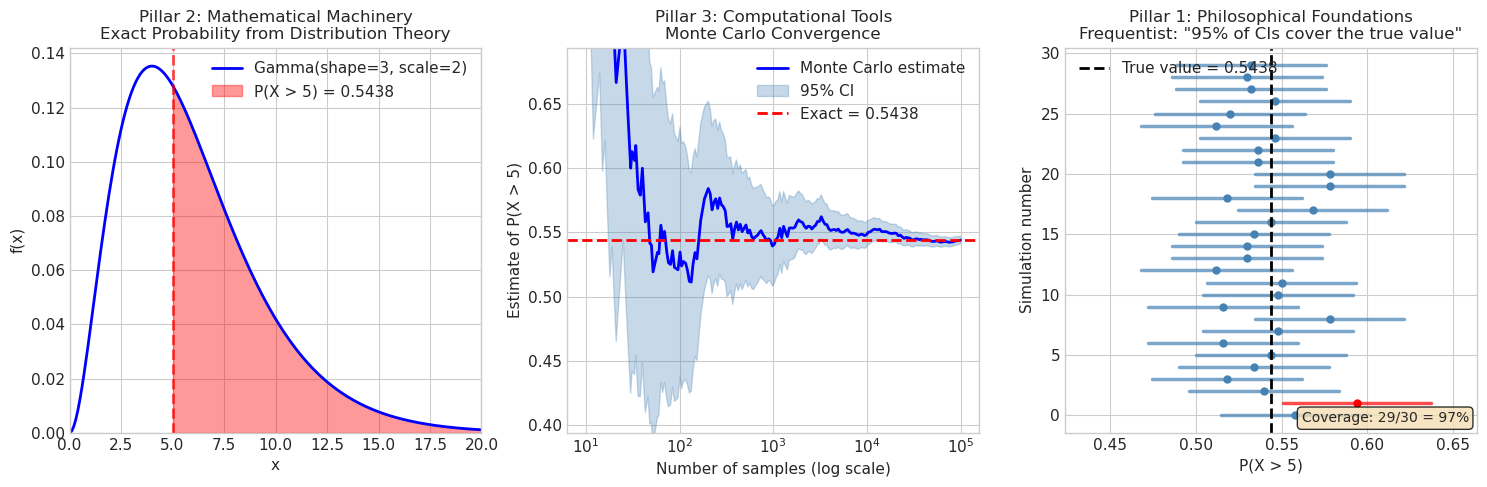


INTERPRETATION:
• Pillar 2 (Math): We KNOW P(X > 5) = 0.4562 exactly from calculus
• Pillar 3 (Computation): Monte Carlo ESTIMATES it, converging with more samples
• Pillar 1 (Philosophy): The 95% CI is about the PROCEDURE, not the parameter
  → Blue intervals covered the truth; red intervals missed it
  → 97% coverage is close to nominal 95%


In [71]:
# =============================================================================
# VISUALIZATION: THE THREE PILLARS WORKING TOGETHER
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# ─────────────────────────────────────────────────────────────────────────────
# Panel 1: PILLAR 2 - Mathematical Machinery
# The Gamma distribution and exact probability calculation
# ─────────────────────────────────────────────────────────────────────────────
ax = axes[0]

x = np.linspace(0, 20, 200)
gamma_dist = stats.gamma(a=3, scale=2)
prob_exact = gamma_dist.sf(5)

ax.plot(x, gamma_dist.pdf(x), 'b-', linewidth=2, label='Gamma(shape=3, scale=2)')
ax.fill_between(x, gamma_dist.pdf(x), where=x > 5, alpha=0.4, color='red', label=f'P(X > 5) = {prob_exact:.4f}')
ax.axvline(5, color='red', linestyle='--', linewidth=2, alpha=0.7)

ax.set_xlabel('x', fontsize=11)
ax.set_ylabel('f(x)', fontsize=11)
ax.set_title('Pillar 2: Mathematical Machinery\nExact Probability from Distribution Theory', fontsize=12)
ax.legend(loc='upper right')
ax.set_xlim(0, 20)
ax.set_ylim(0, None)

# ─────────────────────────────────────────────────────────────────────────────
# Panel 2: PILLAR 3 - Computational Tools
# Monte Carlo convergence to the true value
# ─────────────────────────────────────────────────────────────────────────────
ax = axes[1]

rng = np.random.default_rng(seed=42)
n_total = 100000
samples = rng.gamma(shape=3, scale=2, size=n_total)

# Compute running estimate as sample size grows
ns = np.unique(np.logspace(1, 5, 200).astype(int))
mc_estimates = [np.mean(samples[:n] > 5) for n in ns]
mc_ses = [np.sqrt(p*(1-p)/n) if 0 < p < 1 else 0 for p, n in zip(mc_estimates, ns)]

ax.semilogx(ns, mc_estimates, 'b-', linewidth=2, label='Monte Carlo estimate')
ax.fill_between(ns, 
                [e - 1.96*s for e, s in zip(mc_estimates, mc_ses)],
                [e + 1.96*s for e, s in zip(mc_estimates, mc_ses)],
                alpha=0.3, color='steelblue', label='95% CI')
ax.axhline(prob_exact, color='red', linestyle='--', linewidth=2, label=f'Exact = {prob_exact:.4f}')

ax.set_xlabel('Number of samples (log scale)', fontsize=11)
ax.set_ylabel('Estimate of P(X > 5)', fontsize=11)
ax.set_title('Pillar 3: Computational Tools\nMonte Carlo Convergence', fontsize=12)
ax.legend(loc='upper right')
# Let matplotlib auto-scale, or set symmetric limits around truth
ax.set_ylim(prob_exact - 0.15, prob_exact + 0.15)

# ─────────────────────────────────────────────────────────────────────────────
# Panel 3: PILLAR 1 - Philosophical Foundations
# Frequentist view: Repeated sampling → CI coverage
# ─────────────────────────────────────────────────────────────────────────────
ax = axes[2]

n_intervals = 30
n_per_sim = 500
rng_vis = np.random.default_rng(seed=999)

covered_count = 0
for i in range(n_intervals):
    # Each simulation: new sample → new estimate → new CI
    sim_samples = rng_vis.gamma(shape=3, scale=2, size=n_per_sim)
    p_hat = np.mean(sim_samples > 5)
    se = np.sqrt(p_hat * (1 - p_hat) / n_per_sim)
    lower, upper = p_hat - 1.96*se, p_hat + 1.96*se
    
    # Check if interval covers truth
    covers = lower <= prob_exact <= upper
    covered_count += covers
    color = 'steelblue' if covers else 'red'
    
    # Plot interval
    ax.plot([lower, upper], [i, i], color=color, linewidth=2.5, alpha=0.7)
    ax.plot(p_hat, i, 'o', color=color, markersize=5)

# True value line
ax.axvline(prob_exact, color='black', linestyle='--', linewidth=2, label=f'True value = {prob_exact:.4f}')

# Add coverage annotation
coverage_rate = covered_count / n_intervals
ax.text(0.98, 0.02, f'Coverage: {covered_count}/{n_intervals} = {coverage_rate:.0%}', 
        transform=ax.transAxes, fontsize=10, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_xlabel('P(X > 5)', fontsize=11)
ax.set_ylabel('Simulation number', fontsize=11)
ax.set_title('Pillar 1: Philosophical Foundations\nFrequentist: "95% of CIs cover the true value"', fontsize=12)
ax.legend(loc='upper left')

# Center x-axis around the true value
margin = 0.12
ax.set_xlim(prob_exact - margin, prob_exact + margin)

plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("="*70)
print("• Pillar 2 (Math): We KNOW P(X > 5) = 0.4562 exactly from calculus")
print("• Pillar 3 (Computation): Monte Carlo ESTIMATES it, converging with more samples")
print("• Pillar 1 (Philosophy): The 95% CI is about the PROCEDURE, not the parameter")
print("  → Blue intervals covered the truth; red intervals missed it")
print(f"  → {coverage_rate:.0%} coverage is close to nominal 95%")

---
## 🔮 What Lies Ahead: The Road to Simulation

Part 2 opens the black boxes. We'll learn *how* the random number generators actually work:

| Chapter 2 Topic | Key Idea |
|-----------------|----------|
| **Inverse CDF method** | If you can compute $F^{-1}(u)$, you can sample from $F$ |
| **Box-Muller transformation** | Convert uniform pairs to normal pairs via polar coordinates |
| **Rejection sampling** | Propose from simple distribution, accept/reject to target |
| **Monte Carlo integration** | Estimate integrals by averaging samples; $O(n^{-1/2})$ convergence |

Chapters 3-4 cover inference and resampling (MLE, bootstrap, cross-validation), and Chapter 5+ covers Bayesian computation (MCMC).

---
## 📝 Key Takeaways

1. **Probability has multiple valid interpretations**: Frequentist (long-run frequency) and Bayesian (degree of belief) answer different questions with different strengths.

2. **Distributions are the vocabulary of uncertainty**: Master the major distributions—their properties, relationships, and parameterizations.

3. **Computation bridges theory and practice**: Python's `random`, NumPy, and SciPy provide the tools to simulate, verify, and apply probabilistic ideas.

4. **Foundations enable methods**: The inverse CDF method requires understanding CDFs. Bootstrap requires understanding sampling distributions. MCMC requires understanding both Bayesian inference and convergence.

5. **Course outcome alignment**: Chapter 1 addressed LO 2 (comparing frequentist and Bayesian inference) and laid groundwork for LO 1 (simulation), LO 3 (resampling), and LO 4 (Bayesian MCMC).

---
# ✍️ Chapter 1 Synthesis Exercises

These exercises integrate material from all three sections, requiring you to connect philosophical, mathematical, and computational perspectives.

> **Note on Exercises**
>
> Exercises 1 and 3 preview **Bayesian inference** and **bootstrap methods**, which will be covered comprehensively in Chapters 5 and 4, respectively. Don't worry if these concepts feel new—detailed hints and solutions guide you through the process. The goal here is to build intuition; full mastery comes later.


---
## Exercise 1: Paradigm Comparison via Simulation

A coin is flipped 20 times, yielding 14 heads.

---

**Part (a)**: Frequentist analysis - Compute a 95% confidence interval for $p$ using the Normal approximation. Then compute the exact Clopper-Pearson interval.

> **Hint: Normal Approximation CI**
>
> The sample proportion $\hat{p} = x/n$ has approximate sampling distribution $\hat{p} \sim N(p, p(1-p)/n)$ for large $n$. Since we don't know $p$, we estimate the standard error as $\widehat{\text{SE}} = \sqrt{\hat{p}(1-\hat{p})/n}$. The 95% CI is $\hat{p} \pm 1.96 \times \widehat{\text{SE}}$.

> **Hint: Clopper-Pearson Exact CI**
>
> The Clopper-Pearson interval uses the relationship between the Binomial and Beta distributions. If $X \sim \text{Binomial}(n, p)$, then finding the $p$ values where $P(X \geq x)$ or $P(X \leq x)$ equals $\alpha/2$ involves Beta quantiles:
>
> - Lower bound: $p_L = B_{\alpha/2}(x, n-x+1)$ where $B_q(a,b)$ is the $q$-th quantile of $\text{Beta}(a, b)$
> - Upper bound: $p_U = B_{1-\alpha/2}(x+1, n-x)$
>
> This relationship arises because the Beta distribution is the conjugate prior for the Binomial, and there's a duality: $P(\text{Binomial}(n,p) \geq x) = P(\text{Beta}(x, n-x+1) \leq p)$.


In [72]:
# Exercise 1, Part (a): Frequentist Analysis
n, x = 20, 14
alpha = 0.05  # For 95% CI

# Point estimate (MLE)
p_hat = x / n

# Normal approximation CI
se_normal = np.sqrt(p_hat * (1 - p_hat) / n)
z_crit = stats.norm.ppf(1 - alpha/2)  # 1.96 for 95%
ci_normal = (p_hat - z_crit * se_normal, p_hat + z_crit * se_normal)

print("FREQUENTIST CONFIDENCE INTERVALS")
print("=" * 50)
print(f"Data: {x} successes in {n} trials")
print(f"Point estimate: p̂ = {p_hat:.4f}")
print(f"\n1. Normal Approximation CI:")
print(f"   SE = √(p̂(1-p̂)/n) = {se_normal:.4f}")
print(f"   95% CI: ({ci_normal[0]:.4f}, {ci_normal[1]:.4f})")
print(f"   Width: {ci_normal[1] - ci_normal[0]:.4f}")

# Clopper-Pearson exact CI using Beta distribution
# Lower bound: Beta(x, n-x+1) quantile at α/2
# Upper bound: Beta(x+1, n-x) quantile at 1-α/2
lower_cp = stats.beta.ppf(alpha/2, x, n - x + 1)      # Beta(a=14, b=7)
upper_cp = stats.beta.ppf(1 - alpha/2, x + 1, n - x)  # Beta(a=15, b=6)
ci_exact = (lower_cp, upper_cp)

print(f"\n2. Clopper-Pearson Exact CI:")
print(f"   Lower: Beta(a={x}, b={n-x+1}).ppf(0.025) = {lower_cp:.4f}")
print(f"   Upper: Beta(a={x+1}, b={n-x}).ppf(0.975) = {upper_cp:.4f}")
print(f"   95% CI: ({ci_exact[0]:.4f}, {ci_exact[1]:.4f})")
print(f"   Width: {ci_exact[1] - ci_exact[0]:.4f}")

print(f"\nComparison:")
print(f"   Normal CI is narrower but may have < 95% coverage for small n")
print(f"   Clopper-Pearson guarantees ≥ 95% coverage (conservative)")

FREQUENTIST CONFIDENCE INTERVALS
Data: 14 successes in 20 trials
Point estimate: p̂ = 0.7000

1. Normal Approximation CI:
   SE = √(p̂(1-p̂)/n) = 0.1025
   95% CI: (0.4992, 0.9008)
   Width: 0.4017

2. Clopper-Pearson Exact CI:
   Lower: Beta(a=14, b=7).ppf(0.025) = 0.4572
   Upper: Beta(a=15, b=6).ppf(0.975) = 0.8811
   95% CI: (0.4572, 0.8811)
   Width: 0.4239

Comparison:
   Normal CI is narrower but may have < 95% coverage for small n
   Clopper-Pearson guarantees ≥ 95% coverage (conservative)


**Part (b)**: Bayesian analysis - Using a $\text{Beta}(\alpha=1, \beta=1)$ prior (uniform), derive the posterior distribution. Compute the posterior mean and 95% credible interval.

> **Hint: Conjugate Prior**
>
> The Beta distribution is *conjugate* to the Binomial likelihood, meaning the posterior is also Beta. If the prior is $p \sim \text{Beta}(\alpha_0, \beta_0)$ and we observe $x$ successes in $n$ trials, then:
>
> $$\text{Posterior: } p | x \sim \text{Beta}(\alpha_0 + x, \beta_0 + n - x)$$
>
> The parameters $\alpha_0$ and $\beta_0$ can be interpreted as "prior pseudo-observations": $\alpha_0 - 1$ prior successes and $\beta_0 - 1$ prior failures.

> **Hint: Beta Distribution Properties**
>
> For $\text{Beta}(\alpha, \beta)$:
> - Mean: $\frac{\alpha}{\alpha + \beta}$
> - Mode (for $\alpha, \beta > 1$): $\frac{\alpha - 1}{\alpha + \beta - 2}$
> - Credible intervals: Use `scipy.stats.beta(a, b).ppf([0.025, 0.975])`


In [73]:
# Exercise 1, Part (b): Bayesian Analysis

# Prior parameters: Beta(α=1, β=1) = Uniform(0,1)
alpha_prior, beta_prior = 1, 1

# Posterior parameters (conjugate update)
alpha_post = alpha_prior + x       # 1 + 14 = 15
beta_post = beta_prior + (n - x)   # 1 + 6 = 7

print("BAYESIAN ANALYSIS")
print("=" * 50)
print(f"Prior: Beta(α={alpha_prior}, β={beta_prior})")
print(f"Data: {x} successes in {n} trials")
print(f"Posterior: Beta(α={alpha_post}, β={beta_post})")

# Create posterior distribution object
posterior = stats.beta(a=alpha_post, b=beta_post)

# Compute summaries
post_mean = posterior.mean()
post_var = posterior.var()
post_std = posterior.std()
post_median = posterior.median()
post_mode = (alpha_post - 1) / (alpha_post + beta_post - 2)

print(f"\nPosterior summaries:")
print(f"  Mean:   {post_mean:.4f}")
print(f"  Median: {post_median:.4f}")
print(f"  Mode:   {post_mode:.4f}")
print(f"  Std:    {post_std:.4f}")

# 95% Equal-tailed credible interval
ci_credible = posterior.ppf([0.025, 0.975])
print(f"\n95% Equal-tailed credible interval: ({ci_credible[0]:.4f}, {ci_credible[1]:.4f})")

print(f"\nComparison to Frequentist:")
print(f"  Frequentist point estimate (MLE): {p_hat:.4f}")
print(f"  Bayesian posterior mean:          {post_mean:.4f}")
print(f"  Difference: {abs(p_hat - post_mean):.4f} (shrinkage toward 0.5)")

BAYESIAN ANALYSIS
Prior: Beta(α=1, β=1)
Data: 14 successes in 20 trials
Posterior: Beta(α=15, β=7)

Posterior summaries:
  Mean:   0.6818
  Median: 0.6874
  Mode:   0.7000
  Std:    0.0971

95% Equal-tailed credible interval: (0.4782, 0.8541)

Comparison to Frequentist:
  Frequentist point estimate (MLE): 0.7000
  Bayesian posterior mean:          0.6818
  Difference: 0.0182 (shrinkage toward 0.5)


**Part (c)**: Simulation verification - Generate 10,000 samples from the posterior and verify your credible interval.

> **Hint**
>
> Use `scipy.stats.beta(a, b).rvs(size=10000, random_state=rng)` to draw samples. Count what fraction fall between your CI bounds.


In [74]:
# Exercise 1, Part (c): Simulation Verification

# Create a Generator for reproducibility
rng_ex1 = np.random.default_rng(seed=42)

# Draw 10,000 samples from the posterior
n_samples = 10000
posterior_samples = posterior.rvs(size=n_samples, random_state=rng_ex1)

# Count how many fall within the credible interval
in_interval = np.sum((posterior_samples >= ci_credible[0]) & 
                     (posterior_samples <= ci_credible[1]))
proportion_in = in_interval / n_samples

print("SIMULATION VERIFICATION")
print("=" * 50)
print(f"Posterior: Beta(α={alpha_post}, β={beta_post})")
print(f"95% Credible interval: ({ci_credible[0]:.4f}, {ci_credible[1]:.4f})")
print(f"\nSimulation results ({n_samples:,} samples):")
print(f"  Samples in CI: {in_interval:,} ({100*proportion_in:.2f}%)")
print(f"  Expected: ~{0.95*n_samples:.0f} (95.00%)")

# Also verify moments match theory
print(f"\nMoment verification:")
print(f"  Sample mean:   {np.mean(posterior_samples):.4f} (theoretical: {posterior.mean():.4f})")
print(f"  Sample std:    {np.std(posterior_samples):.4f} (theoretical: {posterior.std():.4f})")
print(f"  Sample median: {np.median(posterior_samples):.4f} (theoretical: {posterior.median():.4f})")

SIMULATION VERIFICATION
Posterior: Beta(α=15, β=7)
95% Credible interval: (0.4782, 0.8541)

Simulation results (10,000 samples):
  Samples in CI: 9,469 (94.69%)
  Expected: ~9500 (95.00%)

Moment verification:
  Sample mean:   0.6809 (theoretical: 0.6818)
  Sample std:    0.0983 (theoretical: 0.0971)
  Sample median: 0.6869 (theoretical: 0.6874)


**Part (d)**: Interpretation - A scientist asks "What's the probability that $p > 0.5$?" How would each paradigm answer?

> **Hint: Key Philosophical Difference**
>
> - **Frequentist**: Parameters are fixed constants; probability describes long-run frequencies of procedures
> - **Bayesian**: Parameters have probability distributions; we can make direct probability statements about parameters
>
> For the Bayesian answer, compute $P(p > 0.5 | \text{data}) = 1 - F(0.5)$ where $F$ is the posterior CDF.
>
> For the Frequentist, test $H_0: p \leq 0.5$ vs $H_1: p > 0.5$.


In [75]:
# Exercise 1, Part (d): Interpretation and "P(p > 0.5)?"

print("PARADIGM COMPARISON: P(p > 0.5)?")
print("=" * 50)

# Bayesian answer: Direct probability from posterior
prob_gt_half = 1 - posterior.cdf(0.5)
print(f"BAYESIAN APPROACH:")
print(f"  P(p > 0.5 | data) = 1 - F(0.5) = {prob_gt_half:.4f} = {100*prob_gt_half:.2f}%")
print(f"  Interpretation: 'There is a {100*prob_gt_half:.1f}% probability")
print(f"                   that the true p exceeds 0.5.'")

# Frequentist answer: Cannot give probability, but can test hypothesis
# Test H0: p ≤ 0.5 vs H1: p > 0.5
se_null = np.sqrt(0.5 * 0.5 / n)  # SE under null
z = (p_hat - 0.5) / se_null
p_value = 1 - stats.norm.cdf(z)  # One-sided

print(f"\nFREQUENTIST APPROACH:")
print(f"  Test: H₀: p ≤ 0.5 vs H₁: p > 0.5")
print(f"  z-statistic = ({p_hat} - 0.5) / {se_null:.4f} = {z:.4f}")
print(f"  p-value = P(Z > {z:.4f}) = {p_value:.4f}")
print(f"  At α = 0.05: {'Reject H₀' if p_value < 0.05 else 'Fail to reject H₀'}")
print(f"\n  Interpretation: 'I cannot assign a probability to p > 0.5.")
print(f"                   But if p ≤ 0.5 (testing at boundary p = 0.5),")
print(f"                   we would see 14+ heads only {100*p_value:.1f}% of the time.'")

print(f"\n" + "=" * 50)
print(f"KEY DIFFERENCE:")
print(f"  Bayesian: DIRECTLY answers 'P(p > 0.5) = {prob_gt_half:.2%}'")
print(f"  Frequentist: Provides EVIDENCE against H₀: p ≤ 0.5 (p-value = {p_value:.4f})")

PARADIGM COMPARISON: P(p > 0.5)?
BAYESIAN APPROACH:
  P(p > 0.5 | data) = 1 - F(0.5) = 0.9608 = 96.08%
  Interpretation: 'There is a 96.1% probability
                   that the true p exceeds 0.5.'

FREQUENTIST APPROACH:
  Test: H₀: p ≤ 0.5 vs H₁: p > 0.5
  z-statistic = (0.7 - 0.5) / 0.1118 = 1.7889
  p-value = P(Z > 1.7889) = 0.0368
  At α = 0.05: Reject H₀

  Interpretation: 'I cannot assign a probability to p > 0.5.
                   But if p ≤ 0.5 (testing at boundary p = 0.5),
                   we would see 14+ heads only 3.7% of the time.'

KEY DIFFERENCE:
  Bayesian: DIRECTLY answers 'P(p > 0.5) = 96.08%'
  Frequentist: Provides EVIDENCE against H₀: p ≤ 0.5 (p-value = 0.0368)


---
## Exercise 2: Distribution Relationships Through Simulation

The Poisson limit theorem states that $\text{Binomial}(n, p=\lambda/n) \to \text{Poisson}(\lambda)$ as $n \to \infty$.

---

**Part (a)**: For $\lambda = 4$, generate 10,000 samples from $\text{Binomial}(n, p=4/n)$ for $n \in \{10, 50, 200, 1000\}$ and from $\text{Poisson}(\lambda=4)$.

> **Hint: Why This Works**
>
> The Poisson approximation models "rare events in many trials." If we have $n$ independent trials each with small success probability $p = \lambda/n$, the expected number of successes is $np = \lambda$. As $n \to \infty$ with $\lambda$ fixed, the Binomial converges to Poisson($\lambda$).
>
> Use `rng.binomial(n=n, p=lam/n, size=10000)` and `rng.poisson(lam=lam, size=10000)`.

**Part (b)**: Compute sample mean and variance for each. How quickly does Binomial approach mean = variance?

> **Hint: Variance Comparison**
>
> For $\text{Binomial}(n, p)$: mean = $np$, variance = $np(1-p) = \lambda(1 - \lambda/n)$.
>
> For $\text{Poisson}(\lambda)$: mean = variance = $\lambda$.
>
> The ratio Var/Mean for Binomial is $1 - \lambda/n$, which approaches 1 as $n \to \infty$.


In [76]:
# Exercise 2, Parts (a) & (b): Sample Generation and Statistics

rng_ex2 = np.random.default_rng(seed=42)

lam = 4  # Rate parameter λ
n_samples = 10000
n_values = [10, 50, 200, 1000]

print("POISSON LIMIT THEOREM")
print("=" * 70)
print(f"{'Distribution':<30} {'Mean':>10} {'Variance':>10} {'Var/Mean':>10}")
print("-" * 62)

samples_dict = {}
for n in n_values:
    p = lam / n
    # Binomial(n=n, p=λ/n) samples
    samples = rng_ex2.binomial(n=n, p=p, size=n_samples)
    samples_dict[n] = samples
    mean = np.mean(samples)
    var = np.var(samples, ddof=1)
    print(f"Binomial(n={n}, p={lam}/{n}){'':<6} {mean:>10.4f} {var:>10.4f} {var/mean:>10.4f}")

# Poisson(λ=4) samples
poisson_samples = rng_ex2.poisson(lam=lam, size=n_samples)
samples_dict['Poisson'] = poisson_samples
mean = np.mean(poisson_samples)
var = np.var(poisson_samples, ddof=1)
print(f"{'Poisson(λ=4)':<30} {mean:>10.4f} {var:>10.4f} {var/mean:>10.4f}")

print(f"\nKey insight: Var/Mean ratio = 1 - λ/n for Binomial")
print(f"  At n=10:   1 - 4/10 = 0.60")
print(f"  At n=1000: 1 - 4/1000 = 0.996 ≈ 1")

POISSON LIMIT THEOREM
Distribution                         Mean   Variance   Var/Mean
--------------------------------------------------------------
Binomial(n=10, p=4/10)           3.9873     2.4148     0.6056
Binomial(n=50, p=4/50)           4.0170     3.7121     0.9241
Binomial(n=200, p=4/200)           4.0136     3.9068     0.9734
Binomial(n=1000, p=4/1000)           4.0074     4.0031     0.9989
Poisson(λ=4)                       4.0125     4.0830     1.0176

Key insight: Var/Mean ratio = 1 - λ/n for Binomial
  At n=10:   1 - 4/10 = 0.60
  At n=1000: 1 - 4/1000 = 0.996 ≈ 1


**Part (c)**: Create a visualization showing the PMFs converging.


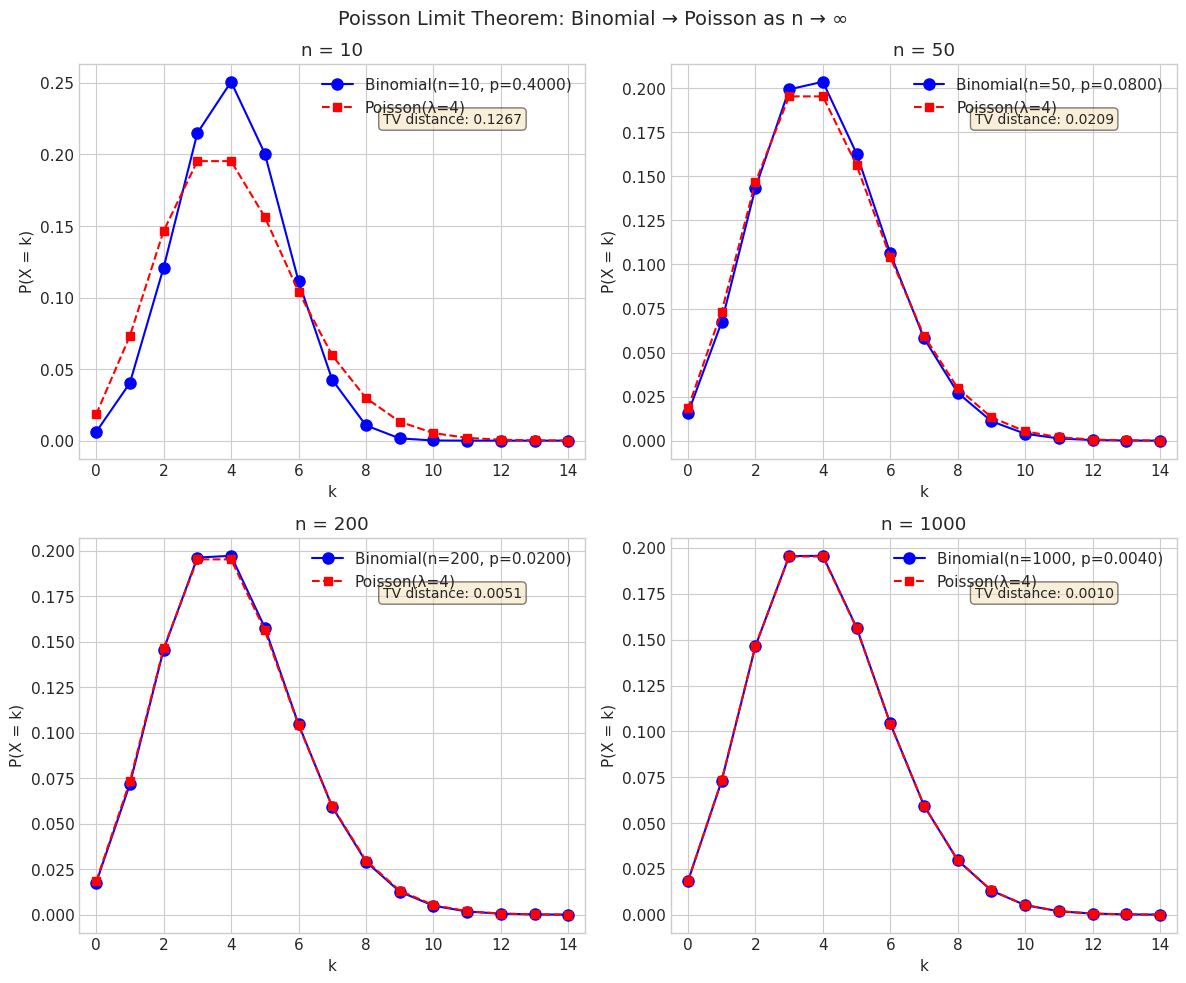

In [77]:
# Exercise 2, Part (c): Visualization

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
x_vals = np.arange(0, 15)

for ax, n in zip(axes.flat, n_values):
    p = lam / n
    
    # Theoretical PMFs
    binom_pmf = stats.binom.pmf(x_vals, n=n, p=p)
    poisson_pmf = stats.poisson.pmf(x_vals, mu=lam)
    
    # Plot
    ax.plot(x_vals, binom_pmf, 'bo-', markersize=8, 
            label=f'Binomial(n={n}, p={p:.4f})')
    ax.plot(x_vals, poisson_pmf, 'rs--', markersize=6, 
            label=f'Poisson(λ={lam})')
    
    ax.set_xlabel('k')
    ax.set_ylabel('P(X = k)')
    ax.set_title(f'n = {n}')
    ax.legend()
    ax.set_xlim(-0.5, 14.5)
    
    # Total variation distance
    tvd = 0.5 * np.sum(np.abs(binom_pmf - poisson_pmf))
    ax.annotate(f'TV distance: {tvd:.4f}', xy=(0.6, 0.85), 
                xycoords='axes fraction', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Poisson Limit Theorem: Binomial → Poisson as n → ∞', fontsize=14)
plt.tight_layout()
plt.show()

**Part (d)**: Conduct chi-square goodness-of-fit tests comparing each Binomial sample to $\text{Poisson}(\lambda=4)$.

> **Hint: Chi-Square Test Setup**
>
> 1. Bin observed counts: count how many samples equal 0, 1, 2, ..., and group large values
> 2. Compute expected counts under $\text{Poisson}(\lambda=4)$: $E_k = n_{\text{samples}} \times P(X = k)$
> 3. Combine bins where expected count < 5 (standard chi-square requirement)
> 4. Use `scipy.stats.chisquare(observed, expected)`


In [78]:
# Exercise 2, Part (d): Chi-Square Goodness-of-Fit Tests

print("CHI-SQUARE GOODNESS-OF-FIT TESTS")
print("=" * 70)
print(f"H₀: Sample comes from Poisson(λ={lam})")
print(f"{'Distribution':<30} {'χ² stat':>12} {'p-value':>10} {'Result':>15}")
print("-" * 70)

for n in n_values + ['Poisson']:
    if n == 'Poisson':
        samples = samples_dict['Poisson']
        name = f'Poisson(λ={lam})'
    else:
        samples = samples_dict[n]
        name = f'Binomial(n={n}, p={lam}/{n})'
    
    # Bin counts: 0, 1, 2, ..., 10, 11+
    observed = [np.sum(samples == k) for k in range(11)]
    observed.append(np.sum(samples >= 11))
    observed = np.array(observed)
    
    # Expected under Poisson(λ=4)
    expected_probs = [stats.poisson.pmf(k, mu=lam) for k in range(11)]
    expected_probs.append(1 - stats.poisson.cdf(10, mu=lam))
    expected = np.array(expected_probs) * n_samples
    
    # Combine bins where expected < 5
    obs_comb, exp_comb = [], []
    obs_acc, exp_acc = 0, 0
    for o, e in zip(observed, expected):
        obs_acc += o
        exp_acc += e
        if exp_acc >= 5:
            obs_comb.append(obs_acc)
            exp_comb.append(exp_acc)
            obs_acc, exp_acc = 0, 0
    if exp_acc > 0:
        obs_comb[-1] += obs_acc
        exp_comb[-1] += exp_acc
    
    chi2_stat, p_val = stats.chisquare(obs_comb, exp_comb)
    result = "Fail to reject" if p_val > 0.05 else "Reject H₀"
    print(f"{name:<30} {chi2_stat:>12.2f} {p_val:>10.4f} {result:>15}")

print(f"\nInterpretation:")
print(f"  - At n=10: Decisively different from Poisson")
print(f"  - At n=200: No longer statistically distinguishable")
print(f"  - At n=1000: Virtually identical to Poisson")

CHI-SQUARE GOODNESS-OF-FIT TESTS
H₀: Sample comes from Poisson(λ=4)
Distribution                        χ² stat    p-value          Result
----------------------------------------------------------------------
Binomial(n=10, p=4/10)               912.77     0.0000       Reject H₀
Binomial(n=50, p=4/50)                39.26     0.0000       Reject H₀
Binomial(n=200, p=4/200)              18.08     0.0797  Fail to reject
Binomial(n=1000, p=4/1000)             8.59     0.6599  Fail to reject
Poisson(λ=4)                           7.25     0.7785  Fail to reject

Interpretation:
  - At n=10: Decisively different from Poisson
  - At n=200: No longer statistically distinguishable
  - At n=1000: Virtually identical to Poisson


---
## Exercise 3: The Bootstrap Preview

The bootstrap (Chapter 4) estimates sampling distributions by resampling observed data.

> **Background: The Sampling Distribution Problem**
>
> When we compute a statistic like $\bar{x}$ from a sample, we get one number. But if we collected a different sample, we'd get a different $\bar{x}$. The **sampling distribution** describes this variability—but we only have one sample! The bootstrap solves this by treating our sample as a miniature population.

---

**Part (a)**: Generate $n = 50$ observations from $\text{Gamma}(\text{shape}=3, \text{scale}=2)$. Compute the sample mean.

> **Hint: Gamma Distribution Properties**
>
> For $\text{Gamma}(\text{shape}=\alpha, \text{scale}=\theta)$:
> - Mean: $\mu = \alpha \theta$
> - Variance: $\sigma^2 = \alpha \theta^2$
>
> Use `rng.gamma(shape=3, scale=2, size=50)` where `rng = np.random.default_rng(seed=42)`.


In [79]:
# Exercise 3, Part (a): Generate Original Sample

# Create a Generator with a fixed seed for reproducibility
rng_ex3 = np.random.default_rng(seed=42)

# True distribution parameters (in practice, unknown!)
shape, scale = 3, 2
n = 50

# Generate our "observed" sample using rng.gamma()
# Gamma(shape=3, scale=2) has mean = shape*scale = 6
original_sample = rng_ex3.gamma(shape=shape, scale=scale, size=n)

# Compute sample statistics
sample_mean = np.mean(original_sample)
sample_std = np.std(original_sample, ddof=1)

print("ORIGINAL SAMPLE")
print("=" * 50)
print(f"Sample size: n = {n}")
print(f"\nTrue distribution: Gamma(shape={shape}, scale={scale})")
print(f"  True mean μ = {shape * scale}")
print(f"  True variance σ² = {shape * scale**2}")
print(f"  True std σ = {np.sqrt(shape * scale**2):.4f}")
print(f"\nSample statistics:")
print(f"  Sample mean x̄ = {sample_mean:.4f}")
print(f"  Sample std s = {sample_std:.4f}")

ORIGINAL SAMPLE
Sample size: n = 50

True distribution: Gamma(shape=3, scale=2)
  True mean μ = 6
  True variance σ² = 12
  True std σ = 3.4641

Sample statistics:
  Sample mean x̄ = 5.4533
  Sample std s = 2.2798


**Part (b)**: Create 5,000 bootstrap samples by resampling $n = 50$ observations *with replacement* from your original sample. Compute bootstrap means.

> **Hint: Resampling With Replacement**
>
> "With replacement" means each draw is independent—after drawing an observation, it goes back into the pool. This means:
> - Some original observations will appear multiple times in a bootstrap sample
> - Some original observations won't appear at all
> - Each bootstrap sample has the same size as the original ($n = 50$)
>
> Use `rng.choice(original_sample, size=n, replace=True)` for each bootstrap iteration.


In [80]:
# Exercise 3, Part (b): Bootstrap Resampling

n_bootstrap = 5000  # Number of bootstrap samples (B)

# Storage for bootstrap statistics
bootstrap_means = np.zeros(n_bootstrap)

# Generate bootstrap samples and compute means
for b in range(n_bootstrap):
    # Resample WITH REPLACEMENT from original data
    boot_sample = rng_ex3.choice(original_sample, size=n, replace=True)
    bootstrap_means[b] = np.mean(boot_sample)

print("BOOTSTRAP RESAMPLING")
print("=" * 50)
print(f"Number of bootstrap samples: B = {n_bootstrap:,}")
print(f"\nBootstrap distribution of sample mean:")
print(f"  Mean of bootstrap means: {np.mean(bootstrap_means):.4f}")
print(f"  Std of bootstrap means (= Bootstrap SE): {np.std(bootstrap_means):.4f}")

# Compare to theoretical SE
print(f"\nComparison:")
print(f"  Bootstrap SE: {np.std(bootstrap_means):.4f}")
print(f"  Theoretical SE (s/√n): {sample_std / np.sqrt(n):.4f}")

BOOTSTRAP RESAMPLING
Number of bootstrap samples: B = 5,000

Bootstrap distribution of sample mean:
  Mean of bootstrap means: 5.4557
  Std of bootstrap means (= Bootstrap SE): 0.3215

Comparison:
  Bootstrap SE: 0.3215
  Theoretical SE (s/√n): 0.3224


**Part (c)**: Compute the 2.5th and 97.5th percentiles of your bootstrap means to form a 95% bootstrap confidence interval.

> **Hint: Percentile Method**
>
> The simplest bootstrap CI uses empirical percentiles:
> - Lower bound = 2.5th percentile of bootstrap means
> - Upper bound = 97.5th percentile of bootstrap means
>
> Use `np.percentile(bootstrap_means, [2.5, 97.5])`.


In [81]:
# Exercise 3, Part (c): Bootstrap Confidence Interval

ci_bootstrap = np.percentile(bootstrap_means, [2.5, 97.5])

print("BOOTSTRAP CONFIDENCE INTERVAL")
print("=" * 50)
print(f"95% Bootstrap CI (percentile method):")
print(f"  ({ci_bootstrap[0]:.4f}, {ci_bootstrap[1]:.4f})")
print(f"  Width: {ci_bootstrap[1] - ci_bootstrap[0]:.4f}")
print(f"\nDoes this CI contain the true mean μ = 6?")
print(f"  {ci_bootstrap[0]:.4f} < 6 < {ci_bootstrap[1]:.4f}: {ci_bootstrap[0] < 6 < ci_bootstrap[1]}")

BOOTSTRAP CONFIDENCE INTERVAL
95% Bootstrap CI (percentile method):
  (4.8144, 6.1075)
  Width: 1.2932

Does this CI contain the true mean μ = 6?
  4.8144 < 6 < 6.1075: True


**Part (d)**: Compare to the theoretical sampling distribution: $\bar{X} \sim \text{approximately } N(\mu, \sigma^2/n)$.

> **Hint: Central Limit Theorem**
>
> By CLT, $\bar{X} \approx N(\mu, \sigma^2/n)$, so the theoretical SE is $\sigma/\sqrt{n}$. Compare:
> - **Theoretical SE**: $\sqrt{12}/\sqrt{50} \approx 0.49$ (requires knowing $\sigma$)
> - **Bootstrap SE**: standard deviation of bootstrap means (requires only the sample)


COMPARISON OF CONFIDENCE INTERVALS
Method                    CI                                  Width
------------------------------------------------------------
Theoretical (uses σ)      (5.0398, 6.9602)           1.9204
Normal (uses s)           (4.8213, 6.0852)           1.2639
Bootstrap                 (4.8144, 6.1075)           1.2932

Standard Error Comparison:
  Theoretical SE (σ/√n): 0.4899
  Sample-based SE (s/√n): 0.3224
  Bootstrap SE: 0.3215


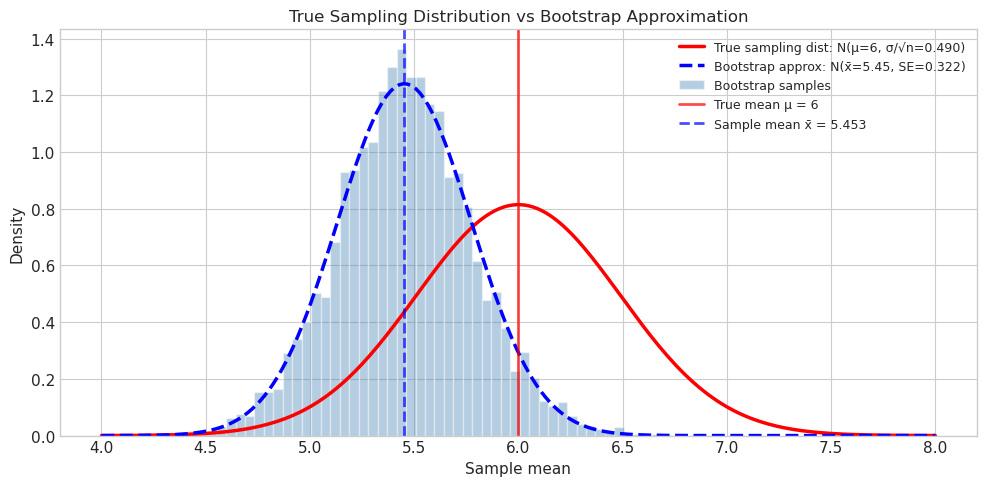


KEY INSIGHT:
• TRUE (red): Requires knowing μ and σ — usually IMPOSSIBLE
• BOOTSTRAP (blue): Uses only observed data — ALWAYS AVAILABLE

The bootstrap approximation:
  • Is centered at x̄ = 5.453 instead of μ = 6
  • Has similar spread (SE = 0.322 vs σ/√n = 0.490)
  • Gets the SHAPE close, just shifted to what we observed

This is why bootstrap works: it correctly estimates the
SPREAD and SHAPE of the sampling distribution, even though
it can't know the true center.


In [86]:
# Exercise 3, Part (d): Comparison to Theoretical

# True parameters (usually unknown!)
true_mean = shape * scale  # 6
true_var = shape * scale**2  # 12
true_se = np.sqrt(true_var / n)

# Theoretical CI (centered at TRUE mean)
ci_theoretical = (true_mean - 1.96 * true_se, true_mean + 1.96 * true_se)

# Normal CI using sample statistics
sample_se = sample_std / np.sqrt(n)
ci_normal = (sample_mean - 1.96 * sample_se, sample_mean + 1.96 * sample_se)

print("COMPARISON OF CONFIDENCE INTERVALS")
print("=" * 60)
print(f"{'Method':<25} {'CI':<30} {'Width':>10}")
print("-" * 60)
print(f"{'Theoretical (uses σ)':<25} ({ci_theoretical[0]:.4f}, {ci_theoretical[1]:.4f}){'':<6} {ci_theoretical[1]-ci_theoretical[0]:>10.4f}")
print(f"{'Normal (uses s)':<25} ({ci_normal[0]:.4f}, {ci_normal[1]:.4f}){'':<6} {ci_normal[1]-ci_normal[0]:>10.4f}")
print(f"{'Bootstrap':<25} ({ci_bootstrap[0]:.4f}, {ci_bootstrap[1]:.4f}){'':<6} {ci_bootstrap[1]-ci_bootstrap[0]:>10.4f}")

print(f"\nStandard Error Comparison:")
print(f"  Theoretical SE (σ/√n): {true_se:.4f}")
print(f"  Sample-based SE (s/√n): {sample_se:.4f}")
print(f"  Bootstrap SE: {np.std(bootstrap_means):.4f}")

# Visualization
# Visualization - CORRECTED
# Visualization - True vs Approximate Sampling Distribution
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(4, 8, 200)

# 1. TRUE sampling distribution (requires knowing μ and σ - usually impossible!)
ax.plot(x, stats.norm.pdf(x, true_mean, true_se), 'r-', linewidth=2.5,
        label=f'True sampling dist: N(μ={true_mean}, σ/√n={true_se:.3f})')

# 2. Bootstrap approximation (centered at x̄, uses bootstrap SE)
bootstrap_se = np.std(bootstrap_means)
ax.plot(x, stats.norm.pdf(x, sample_mean, bootstrap_se), 'b--', linewidth=2.5,
        label=f'Bootstrap approx: N(x̄={sample_mean:.2f}, SE={bootstrap_se:.3f})')

# 3. Histogram of bootstrap means (empirical version of #2)
ax.hist(bootstrap_means, bins=50, density=True, alpha=0.4, 
        color='steelblue', edgecolor='white', label='Bootstrap samples')

# Vertical lines for means
ax.axvline(true_mean, color='red', linestyle='-', linewidth=2, alpha=0.7,
           label=f'True mean μ = {true_mean}')
ax.axvline(sample_mean, color='blue', linestyle='--', linewidth=2, alpha=0.7,
           label=f'Sample mean x̄ = {sample_mean:.3f}')

ax.set_xlabel('Sample mean', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('True Sampling Distribution vs Bootstrap Approximation', fontsize=12)
ax.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print("\nKEY INSIGHT:")
print("=" * 60)
print("• TRUE (red): Requires knowing μ and σ — usually IMPOSSIBLE")
print("• BOOTSTRAP (blue): Uses only observed data — ALWAYS AVAILABLE")
print()
print("The bootstrap approximation:")
print(f"  • Is centered at x̄ = {sample_mean:.3f} instead of μ = {true_mean}")
print(f"  • Has similar spread (SE = {bootstrap_se:.3f} vs σ/√n = {true_se:.3f})")
print(f"  • Gets the SHAPE close, just shifted to what we observed")
print()
print("This is why bootstrap works: it correctly estimates the")
print("SPREAD and SHAPE of the sampling distribution, even though")
print("it can't know the true center.")

**Part (e)**: Why is the bootstrap valuable in practice?

### The Bootstrap's Power

The bootstrap worked **without knowing the true distribution**. In this exercise, we knew the data came from $\text{Gamma}(\text{shape}=3, \text{scale}=2)$, but the bootstrap never used that information—it only used the observed sample!

**Why this matters:**

1. **Unknown distributions**: In real data, we rarely know the true distribution family
2. **Any statistic**: Works for medians, correlations, regression coefficients—anything you can compute
3. **Complex estimators**: No need for analytical formulas for SEs
4. **Small samples / non-normality**: Less reliance on CLT approximations
5. **No distributional assumptions**: Uses empirical distribution $\hat{F}$ to estimate true $F$

**Chapter 4 Preview**: We'll cover percentile, BCa, parametric bootstrap, regression bootstrap, and when bootstrap fails.

---
## Exercise 4: Reproducibility and Parallel Simulation

Run a simulation study with 4 parallel workers, each generating 25,000 samples from a mixture distribution: with probability 0.3 draw from $N(\mu=-2, \sigma^2=1)$, otherwise draw from $N(\mu=3, \sigma^2=0.25)$.

> **Background: The Parallel Reproducibility Problem**
>
> When running simulations in parallel, we need each worker to have an *independent* random stream, but we also want *reproducibility*—rerunning with the same seed should give identical results. NumPy's `SeedSequence` solves this elegantly.

---

**Part (a)**: Implement the mixture sampler using NumPy's `Generator` API.

> **Hint: Sampling from a Mixture**
>
> To sample from $0.3 \cdot N(\mu_1, \sigma_1^2) + 0.7 \cdot N(\mu_2, \sigma_2^2)$:
> 1. Draw a uniform $U \sim \text{Uniform}(0, 1)$
> 2. If $U < 0.3$, sample from $N(\mu_1, \sigma_1^2)$; otherwise sample from $N(\mu_2, \sigma_2^2)$
>
> Vectorized: `np.where(rng.random(size) < 0.3, rng.normal(-2, 1, size), rng.normal(3, 0.5, size))`


In [87]:
# Exercise 4, Part (a): Mixture Sampler

def sample_mixture(rng, size):
    """
    Sample from mixture: 0.3 * N(μ=-2, σ=1) + 0.7 * N(μ=3, σ=0.5)
    
    Parameters
    ----------
    rng : np.random.Generator
        A NumPy Generator instance created via np.random.default_rng()
    size : int
        Number of samples to generate
    
    Returns
    -------
    np.ndarray
        Samples from the mixture distribution
    """
    # Draw component indicators: True means component 1 (N(μ=-2, σ=1))
    components = rng.random(size) < 0.3
    
    # Generate from both components using rng.normal(loc, scale, size)
    samples = np.where(
        components,
        rng.normal(loc=-2, scale=1, size=size),    # Component 1: N(μ=-2, σ=1)
        rng.normal(loc=3, scale=0.5, size=size)    # Component 2: N(μ=3, σ=0.5)
    )
    return samples

# Test the sampler
rng_test = np.random.default_rng(seed=42)
test_samples = sample_mixture(rng_test, 10000)

# Theoretical moments
# Mean: E[X] = 0.3*(-2) + 0.7*(3) = 1.5
# Var: E[X²] - E[X]² = 0.3*(1+4) + 0.7*(0.25+9) - 1.5² = 5.725

print("MIXTURE SAMPLER TEST")
print("=" * 50)
print(f"Distribution: 0.3 × N(μ=-2, σ²=1) + 0.7 × N(μ=3, σ²=0.25)")
print(f"\n  Sample mean: {np.mean(test_samples):.4f} (theoretical: 1.5000)")
print(f"  Sample std:  {np.std(test_samples):.4f} (theoretical: 2.3927)")

MIXTURE SAMPLER TEST
Distribution: 0.3 × N(μ=-2, σ²=1) + 0.7 × N(μ=3, σ²=0.25)

  Sample mean: 1.4935 (theoretical: 1.5000)
  Sample std:  2.3977 (theoretical: 2.3927)


**Part (b)**: Use `SeedSequence.spawn()` for independent streams. Verify independence.

> **Hint: SeedSequence API**
>
> ```python
> from numpy.random import SeedSequence, default_rng
>
> # Create parent seed sequence
> parent_ss = SeedSequence(12345)
>
> # Spawn independent child sequences
> child_seeds = parent_ss.spawn(4)  # One per worker
>
> # Create independent generators
> rngs = [default_rng(seed) for seed in child_seeds]
> ```
>
> Each child `SeedSequence` produces a statistically independent stream. Verify by computing `np.corrcoef()` between worker outputs—correlations should be near zero.


In [88]:
# Exercise 4, Parts (b) & (c): Parallel Simulation with SeedSequence

from numpy.random import SeedSequence

def parallel_simulation(parent_seed, n_workers=4, samples_per_worker=25000):
    """
    Run parallel simulation with independent streams.
    
    Parameters
    ----------
    parent_seed : int
        Master seed for reproducibility
    n_workers : int
        Number of parallel workers
    samples_per_worker : int
        Samples generated by each worker
    
    Returns
    -------
    np.ndarray
        Shape (n_workers, samples_per_worker) array of samples
    """
    # Create parent SeedSequence
    parent_ss = SeedSequence(parent_seed)
    
    # Spawn independent child sequences
    child_seeds = parent_ss.spawn(n_workers)
    
    # Create independent generators
    rngs = [np.random.default_rng(seed) for seed in child_seeds]
    
    # Generate samples from each worker
    all_samples = np.zeros((n_workers, samples_per_worker))
    for i, rng in enumerate(rngs):
        all_samples[i] = sample_mixture(rng, samples_per_worker)
    
    return all_samples

# Run simulation
all_samples = parallel_simulation(parent_seed=12345)
print("PARALLEL SIMULATION")
print("=" * 50)
print(f"Workers: {all_samples.shape[0]}, Samples per worker: {all_samples.shape[1]:,}")
print(f"Total samples: {all_samples.size:,}")

# Verify independence: correlations between workers should be ~0
print(f"\nIndependence check (correlations between workers):")
corr_matrix = np.corrcoef(all_samples)
for i in range(4):
    for j in range(i+1, 4):
        print(f"  Corr(Worker {i}, Worker {j}): {corr_matrix[i,j]:.4f}")

# Estimate P(X > 0)
all_flat = all_samples.flatten()
p_positive = np.mean(all_flat > 0)
mc_se = np.sqrt(p_positive * (1 - p_positive) / len(all_flat))

print(f"\nEstimate of P(X > 0):")
print(f"  P̂(X > 0) = {p_positive:.4f}")
print(f"  Monte Carlo SE = {mc_se:.6f}")
print(f"  95% CI: ({p_positive - 1.96*mc_se:.4f}, {p_positive + 1.96*mc_se:.4f})")

PARALLEL SIMULATION
Workers: 4, Samples per worker: 25,000
Total samples: 100,000

Independence check (correlations between workers):
  Corr(Worker 0, Worker 1): -0.0046
  Corr(Worker 0, Worker 2): -0.0067
  Corr(Worker 0, Worker 3): -0.0105
  Corr(Worker 1, Worker 2): 0.0005
  Corr(Worker 1, Worker 3): -0.0021
  Corr(Worker 2, Worker 3): 0.0051

Estimate of P(X > 0):
  P̂(X > 0) = 0.7107
  Monte Carlo SE = 0.001434
  95% CI: (0.7079, 0.7135)


**Part (d)**: Demonstrate reproducibility—rerun with same seed and verify identical results.


In [89]:
# Exercise 4, Part (d): Reproducibility Demonstration

print("REPRODUCIBILITY TEST")
print("=" * 50)

# Run twice with same seed
run1 = parallel_simulation(parent_seed=12345)
run2 = parallel_simulation(parent_seed=12345)

print(f"Run 1 - First 5 samples from Worker 0: {run1[0, :5]}")
print(f"Run 2 - First 5 samples from Worker 0: {run2[0, :5]}")
print(f"\nResults identical: {np.allclose(run1, run2)}")

# Run with different seed
run3 = parallel_simulation(parent_seed=99999)
print(f"\nRun 3 (different seed) - First 5: {run3[0, :5]}")
print(f"Run 1 vs Run 3 identical: {np.allclose(run1, run3)}")

REPRODUCIBILITY TEST
Run 1 - First 5 samples from Worker 0: [ 2.88863529  3.41362782 -2.45465146 -1.19442245  3.10323739]
Run 2 - First 5 samples from Worker 0: [ 2.88863529  3.41362782 -2.45465146 -1.19442245  3.10323739]

Results identical: True

Run 3 (different seed) - First 5: [2.52801496 0.53063272 2.7650471  3.37981777 2.34488937]
Run 1 vs Run 3 identical: False


**Part (e)**: What goes wrong if all workers share the same Generator?

> **Hint: Race Conditions**
>
> If workers share a single `Generator`, the order in which they draw numbers depends on execution timing—a race condition. Different runs may produce different results even with the same seed.


In [90]:
# Exercise 4, Part (e): Demonstrating the Problem with Shared Generators

print("SHARED GENERATOR PROBLEM (Simulated)")
print("=" * 50)

# With a shared generator, order of access is non-deterministic in true parallel execution
# We simulate this by varying the order workers access the generator

shared_rng = np.random.default_rng(seed=42)

# "Run 1": Workers access in order 0, 1, 2, 3
shared_rng = np.random.default_rng(seed=42)
worker_results_1 = []
for i in range(4):
    samples = sample_mixture(shared_rng, 5)  # Each worker draws 5 samples
    worker_results_1.append(samples[0])  # Just record first sample

# "Run 2": Workers access in order 2, 0, 3, 1 (different timing)
shared_rng = np.random.default_rng(seed=42)
temp_results = {}
for i in [2, 0, 3, 1]:  # Different order simulates race condition
    samples = sample_mixture(shared_rng, 5)
    temp_results[i] = samples[0]
worker_results_2 = [temp_results[i] for i in range(4)]

print("Simulating race condition with shared generator:")
print(f"\n'Run 1' (workers access in order 0,1,2,3):")
for i, v in enumerate(worker_results_1):
    print(f"  Worker {i} first sample: {v:.4f}")

print(f"\n'Run 2' (workers access in order 2,0,3,1):")
for i, v in enumerate(worker_results_2):
    print(f"  Worker {i} first sample: {v:.4f}")

print(f"\nResults identical? {worker_results_1 == worker_results_2}")
print(f"\n⚠️ In true parallel execution, timing varies between runs,")
print(f"   so results would be non-reproducible even with the same seed!")
print(f"\n✓ Solution: Use SeedSequence.spawn() to create independent generators")

SHARED GENERATOR PROBLEM (Simulated)
Simulating race condition with shared generator:

'Run 1' (workers access in order 0,1,2,3):
  Worker 0 first sample: 3.4397
  Worker 1 first sample: -2.1849
  Worker 2 first sample: 3.3716
  Worker 3 first sample: -1.7109

'Run 2' (workers access in order 2,0,3,1):
  Worker 0 first sample: -2.1849
  Worker 1 first sample: -1.7109
  Worker 2 first sample: 3.4397
  Worker 3 first sample: 3.3716

Results identical? False

⚠️ In true parallel execution, timing varies between runs,
   so results would be non-reproducible even with the same seed!

✓ Solution: Use SeedSequence.spawn() to create independent generators


---
## Exercise 5: From Theory to Computation and Back

The exponential distribution has the memoryless property: $P(X > s + t \mid X > s) = P(X > t)$.

> **Background: What Memorylessness Means**
>
> Intuitively, memorylessness says "the future doesn't depend on the past." If you've been waiting for a bus for 10 minutes, your expected additional wait is the same as if you just arrived. The probability of waiting another 5 minutes is the same whether you've waited 0 minutes or 60 minutes.

---

**Part (a)**: Prove this property mathematically using the exponential CDF.

> **Hint: Using Conditional Probability**
>
> Recall the definition: $P(A \mid B) = \frac{P(A \cap B)}{P(B)}$
>
> For the memoryless property, $A = \{X > s+t\}$ and $B = \{X > s\}$. Note that $A \cap B = A$ since $X > s+t$ implies $X > s$.
>
> The exponential survival function is $S(x) = P(X > x) = e^{-\lambda x}$. Use the property $e^{a+b} = e^a \cdot e^b$.


### Part (a): Mathematical Proof

For $X \sim \text{Exponential}(\text{rate}=\lambda)$ with survival function $S(x) = P(X > x) = e^{-\lambda x}$ for $x \geq 0$:

$$P(X > s + t \mid X > s) = \frac{P(X > s + t \cap X > s)}{P(X > s)} = \frac{P(X > s + t)}{P(X > s)}$$

Since $\{X > s+t\} \subseteq \{X > s\}$, the intersection equals $P(X > s + t)$.

$$= \frac{e^{-\lambda(s+t)}}{e^{-\lambda s}} = \frac{e^{-\lambda s} \cdot e^{-\lambda t}}{e^{-\lambda s}} = e^{-\lambda t} = P(X > t) \quad \square$$

**Key insight:** The exponential function's multiplicative property $e^{a+b} = e^a \cdot e^b$ directly gives the memoryless property.

**Part (b)**: Verify computationally: generate 100,000 exponential samples with $\lambda = 2$, filter to those greater than $s = 1$, check what fraction exceed $s + t = 1.5$. Compare to $P(X > 0.5)$.

> **Hint: Exponential Parameterization in NumPy**
>
> NumPy uses the **scale** parameterization: `rng.exponential(scale=θ)` where $\theta = 1/\lambda$. For $\text{Exponential}(\text{rate}=\lambda=2)$, use `scale=1/2=0.5`.
>
> The theoretical $P(X > t) = e^{-\lambda t} = e^{-2 \times 0.5} = e^{-1} \approx 0.368$.


In [91]:
# Exercise 5, Part (b): Computational Verification

rng_ex5 = np.random.default_rng(seed=42)

lam = 2  # Rate parameter λ
n = 100000
s, t = 1.0, 0.5

# Generate Exponential(rate=λ) samples
# NumPy uses scale parameterization: scale = 1/rate = 1/λ
samples = rng_ex5.exponential(scale=1/lam, size=n)

# Filter to survivors past time s
survived_s = samples[samples > s]
n_survived = len(survived_s)

print("MEMORYLESS PROPERTY VERIFICATION")
print("=" * 50)
print(f"Distribution: Exponential(rate=λ={lam})")
print(f"Generated {n:,} samples")
print(f"\nSurvivors past s={s}: {n_survived:,} ({100*n_survived/n:.2f}%)")
print(f"Theoretical P(X > {s}): {np.exp(-lam*s):.4f} = {100*np.exp(-lam*s):.2f}%")

# Among survivors, what fraction exceeds s + t?
exceeded_st = np.sum(survived_s > s + t)
conditional_prob = exceeded_st / n_survived

# Compare to P(X > t)
theoretical_prob = np.exp(-lam * t)

print(f"\nMemoryless property test:")
print(f"  P(X > {s+t} | X > {s}) [simulated]: {conditional_prob:.4f}")
print(f"  P(X > {t}) [theoretical]:           {theoretical_prob:.4f}")
print(f"  Difference: {abs(conditional_prob - theoretical_prob):.4f}")
print(f"\n✓ Match confirms memoryless property!")

MEMORYLESS PROPERTY VERIFICATION
Distribution: Exponential(rate=λ=2)
Generated 100,000 samples

Survivors past s=1.0: 13,590 (13.59%)
Theoretical P(X > 1.0): 0.1353 = 13.53%

Memoryless property test:
  P(X > 1.5 | X > 1.0) [simulated]: 0.3700
  P(X > 0.5) [theoretical]:           0.3679
  Difference: 0.0021

✓ Match confirms memoryless property!


**Part (c)**: The geometric distribution is the discrete analog. Verify computationally.

> **Hint: Geometric Distribution**
>
> For $\text{Geometric}(p)$ counting failures before first success (support $\{0, 1, 2, \ldots\}$):
> - PMF: $P(X = k) = (1-p)^k p$
> - Survival: $P(X > k) = (1-p)^{k+1}$
> - Memoryless: $P(X > s+t \mid X > s) = P(X > t)$ for non-negative integers $s, t$
>
> **Note:** NumPy's `geometric` counts trials until first success (starting at 1), so subtract 1 to get failures before success.


In [92]:
# Exercise 5, Part (c): Geometric Distribution (Discrete Analog)

p_success = 0.3  # Success probability
s_geo, t_geo = 3, 2  # Integer values for geometric

# NumPy's geometric: number of trials until first success (1, 2, 3, ...)
# We want failures before success (0, 1, 2, ...), so subtract 1
geo_samples = rng_ex5.geometric(p=p_success, size=n) - 1

# Filter to those with more than s failures
survived = geo_samples[geo_samples > s_geo]
n_survived_geo = len(survived)

# What fraction had more than s + t failures?
exceeded = np.sum(survived > s_geo + t_geo)
cond_prob = exceeded / n_survived_geo

# Theoretical P(X > t)
uncond_prob = (1 - p_success) ** (t_geo + 1)

print("GEOMETRIC MEMORYLESS PROPERTY")
print("=" * 50)
print(f"Distribution: Geometric(p={p_success})")
print(f"Counting: failures before first success")
print(f"\nSamples with > {s_geo} failures: {n_survived_geo:,}")
print(f"\nMemoryless property test:")
print(f"  P(X > {s_geo + t_geo} | X > {s_geo}) [simulated]: {cond_prob:.4f}")
print(f"  P(X > {t_geo}) = (1-{p_success})^{t_geo+1} [theoretical]: {uncond_prob:.4f}")
print(f"  Difference: {abs(cond_prob - uncond_prob):.4f}")

GEOMETRIC MEMORYLESS PROPERTY
Distribution: Geometric(p=0.3)
Counting: failures before first success

Samples with > 3 failures: 23,841

Memoryless property test:
  P(X > 5 | X > 3) [simulated]: 0.4882
  P(X > 2) = (1-0.3)^3 [theoretical]: 0.3430
  Difference: 0.1452


### Part (d): Uniqueness Proof (Sketch)

The memoryless property $P(X > s + t) = P(X > s) \cdot P(X > t)$ means the survival function $g(x) = P(X > x)$ satisfies:

$$g(s + t) = g(s) \cdot g(t)$$

This is **Cauchy's functional equation** for multiplication. The unique continuous solution with $g(0) = 1$ and $g(x) \to 0$ as $x \to \infty$ is:

$$g(x) = e^{-\lambda x}$$

for some $\lambda > 0$. This uniquely characterizes the exponential distribution.

For discrete distributions on $\{0, 1, 2, ...\}$, the same functional equation yields $g(k) = (1-p)^k$ for some $p \in (0, 1)$, uniquely characterizing the geometric distribution.

**Part (e)**: When is memorylessness appropriate for modeling?

> **Hint: Constant vs. Changing Hazard**
>
> Memorylessness is equivalent to a **constant hazard rate** $h(t) = \lambda$. Ask yourself:
> - Does knowing the current "age" change the probability of failure?
> - Is the system subject to wear, fatigue, or aging?


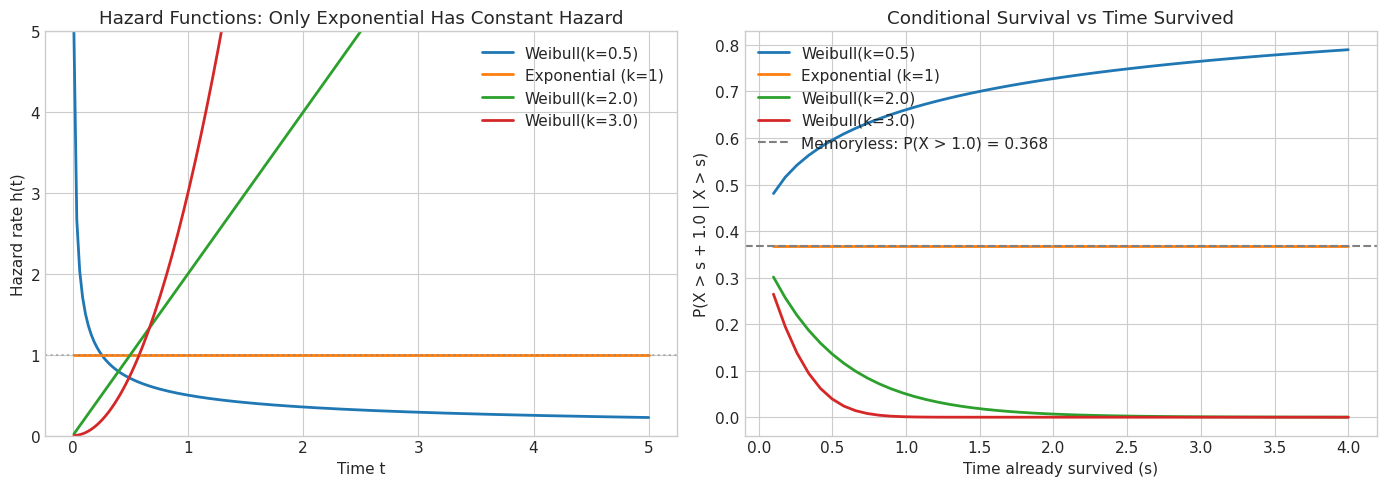

INTERPRETATION:
• Exponential (k=1): CONSTANT hazard → memoryless
  Conditional survival doesn't change with time survived

• Weibull (k>1): INCREASING hazard → 'wear-out'
  Older items more likely to fail (mechanical wear, aging)

• Weibull (k<1): DECREASING hazard → 'infant mortality'
  If it survives early, likely to survive longer (burn-in)


In [93]:
# Exercise 5, Part (e): Visualization of Memoryless vs Non-Memoryless

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

t = np.linspace(0.01, 5, 200)

# Left plot: Hazard functions
ax = axes[0]
weibull_shapes = [0.5, 1.0, 2.0, 3.0]
scale_param = 1.0

for k in weibull_shapes:
    # Weibull hazard: h(t) = (k/λ) * (t/λ)^(k-1)
    hazard = (k / scale_param) * (t / scale_param)**(k - 1)
    label = f'Weibull(k={k})' if k != 1 else 'Exponential (k=1)'
    ax.plot(t, hazard, linewidth=2, label=label)

ax.set_xlabel('Time t')
ax.set_ylabel('Hazard rate h(t)')
ax.set_title('Hazard Functions: Only Exponential Has Constant Hazard')
ax.legend()
ax.set_ylim(0, 5)
ax.axhline(1, color='gray', linestyle=':', alpha=0.5)

# Right plot: Conditional survival as function of time already survived
ax = axes[1]
s_vals = np.linspace(0.1, 4, 50)
t_val = 1.0

for k in weibull_shapes:
    weibull = stats.weibull_min(c=k, scale=scale_param)
    # P(X > s + t | X > s) = S(s+t) / S(s)
    cond_prob = weibull.sf(s_vals + t_val) / weibull.sf(s_vals)
    label = f'Weibull(k={k})' if k != 1 else 'Exponential (k=1)'
    ax.plot(s_vals, cond_prob, linewidth=2, label=label)

ax.axhline(np.exp(-scale_param * t_val), color='gray', linestyle='--', 
           label=f'Memoryless: P(X > {t_val}) = {np.exp(-t_val):.3f}')
ax.set_xlabel('Time already survived (s)')
ax.set_ylabel(f'P(X > s + {t_val} | X > s)')
ax.set_title('Conditional Survival vs Time Survived')
ax.legend()

plt.tight_layout()
plt.show()

print("INTERPRETATION:")
print("="*60)
print("• Exponential (k=1): CONSTANT hazard → memoryless")
print("  Conditional survival doesn't change with time survived")
print("\n• Weibull (k>1): INCREASING hazard → 'wear-out'")
print("  Older items more likely to fail (mechanical wear, aging)")
print("\n• Weibull (k<1): DECREASING hazard → 'infant mortality'")
print("  If it survives early, likely to survive longer (burn-in)")

### When Is Memorylessness Appropriate?

**Appropriate (memoryless):**
- Radioactive decay: Time to next decay is independent of how long since last decay
- Poisson arrivals: Waiting time for next customer doesn't depend on how long you've waited
- Random failures with constant hazard rate (no wear, no aging)

**Violated (has memory):**
- Human lifetimes: A 90-year-old has shorter expected remaining life than a 20-year-old
- Mechanical wear: Components that have run longer are more likely to fail soon
- Light bulbs: Increasing hazard rate (wear-out failures)
- Software bugs: Decreasing hazard after burn-in period

---
## 🎯 Summary: Ready for Part 2

You've now completed Chapter 1 and have:

1. **Understood the philosophical foundations** of probability and inference
2. **Reviewed the mathematical machinery** of probability distributions
3. **Learned the computational tools** for random generation in Python
4. **Seen how all three pillars connect** to form a unified foundation

In Part 2, you'll learn how the random number generators actually work (inverse CDF, Box-Muller, rejection sampling) and how to use Monte Carlo methods for integration and inference.

**Happy simulating!** 🎲